<h1><center>PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS NÚCLEO DE EDUCAÇÃO A DISTÂNCIA</center></h1>


<h2><center>TRABALHO DE CONCLUSÃO DE CURSO</center></h2>


<h2><center> Pós-graduação Lato Sensu em Ciência de Dados e Big Data </center></h2>

<h3><left> Título : Análise Preditiva dos principais mercados de ações com aplicação em técnicas de modelo de séries temporais com Machine Learning </left></h3>

<h3><left>  Lucas Augusto Domeneghetti Pedrino </left></h3>

In [1]:
#Import dos pacotes de pandas, beautifulsoup, numpy, requests, time, matplotlib e seaborn

import pandas as pd
from bs4 import BeautifulSoup as bs
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter

In [2]:
#Import do sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
import warnings
from tqdm import tqdm
from prophet import Prophet
import itertools

In [4]:
#Import do statismodels 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


In [5]:
#import dos pacotes selenium

from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_auto_update import check_driver
check_driver('C:/Users/ladpe/.wdm/drivers/chromedriver')
driver = webdriver.Chrome()
driver.get("http://www.python.org")

Local chromedriver version: 103.0.5060.134
Latest online chromedriver version: 104.0.5112.79
Attempting to download latest driver online......
https://chromedriver.storage.googleapis.com/104.0.5112.79/chromedriver_win32.zip

Successfully downloaded version 104.0.5112.79 to:
C:/Users/ladpe/.wdm/drivers/chromedriver


In [6]:
options = webdriver.ChromeOptions()
options.add_experimental_option("prefs", {
  "download.default_directory": r"C:\Users\ladpe\notebook_TCC"})
driver = webdriver.Chrome(chrome_options=options)

C:\Users\ladpe\AppData\Local\Temp\ipykernel_30204\3797809092.py:4: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chrome_options=options)


# WebScrapping - Coleta De Dados

### Webscrapping da pagina da B3

In [7]:
def busca_carteira_teorica(indice, espera=5):
    url_b3 = f'https://sistemaswebb3-listados.b3.com.br/indexPage/day/{indice.upper()}?language=pt-br'  
    driver.get(url_b3);  
    time.sleep(espera)

    #Id 'segment' é o id usado no código da página, pode-se confirmar visualizando o código HTML da 
    #URL usada.
    driver.find_element_by_id('segment').send_keys("Setor de Atuação")
    time.sleep(espera)
  
    #Encontra um link com texto 'Download' e executa um click no link, o texto 'Download' também pode
    #ser confirmado no código HTML
    driver.find_element_by_link_text("Download").click()
    time.sleep(espera) 
    
    #Recebe o arquivo em .csv
    if indice == 'ibov':
        arquivo = open(r'ibovdia_22-04-22.csv')
    elif indice == 'ibxx':
        arquivo = open(r'ibxxdia_22-04-22.csv')
    
    #retorna em formato de dataframe 
    return pd.read_csv(arquivo, sep=';', encoding='ISO-8859-1', skipfooter=2, engine='python',
                       thousands='.', decimal=',', header=1, index_col=False)

In [8]:
df_ibov = busca_carteira_teorica('ibov',5)


C:\Users\ladpe\AppData\Local\Temp\ipykernel_30204\3503781761.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id('segment').send_keys("Setor de Atuação")
C:\Users\ladpe\AppData\Local\Temp\ipykernel_30204\3503781761.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_link_text("Download").click()


In [9]:
df_ibxx  = busca_carteira_teorica('ibxx',5)

C:\Users\ladpe\AppData\Local\Temp\ipykernel_30204\3503781761.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id('segment').send_keys("Setor de Atuação")
C:\Users\ladpe\AppData\Local\Temp\ipykernel_30204\3503781761.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_link_text("Download").click()


In [10]:
df_ibov.sort_values('Part. (%)', ascending=False).head(10)

Setor Código          Ação  \
55                           Mats Básicos / Mineração  VALE3          VALE   
64                    Petróleo/ Gás e Biocombustíveis  PETR4     PETROBRAS   
43                  Financ e Outros / Interms Financs  ITUB4  ITAUUNIBANCO   
39                  Financ e Outros / Interms Financs  BBDC4      BRADESCO   
63                    Petróleo/ Gás e Biocombustíveis  PETR3     PETROBRAS   
48  Financeiro e Outros/Serviços Financeiros Diversos  B3SA3            B3   
12                           Cons N Cíclico / Bebidas  ABEV3     AMBEV S/A   
40                  Financ e Outros / Interms Financs  BBAS3        BRASIL   
9              Cons N  Básico / Alimentos Processados  JBSS3           JBS   
42                  Financ e Outros / Interms Financs  ITSA4        ITAUSA   

          Tipo  Qtde. Teórica  Part. (%)  Part. (%)Acum.  
55  ON      NM     3843570705     15.357          16.008  
64  PN  EDR N2     4566442248      6.794          15.822  
43  PN      N1     4780002924      5.855          19.093  
39  PN  EB  N1     5160570290      4.708          19.093  
63  ON  EDR N2     2703343822      4.442          15.822  
48  ON      NM     6065856318      4.169           4.357  
12          ON     4359908680      3.005           3.005  
40  ON      NM     1420530937      2.337          19.093  
9   ON      NM     1290736673      2.317           3.538  
42  PN      N1     4736048447      2.229          19.093

In [11]:
df_ibxx.sort_values('Part. (%)', ascending=False).head(10)

Setor Código          Ação  \
59                           Mats Básicos / Mineração  VALE3          VALE   
68                    Petróleo/ Gás e Biocombustíveis  PETR4     PETROBRAS   
67                    Petróleo/ Gás e Biocombustíveis  PETR3     PETROBRAS   
46                  Financ e Outros / Interms Financs  ITUB4  ITAUUNIBANCO   
42                  Financ e Outros / Interms Financs  BBDC4      BRADESCO   
52  Financeiro e Outros/Serviços Financeiros Diversos  B3SA3            B3   
13                           Cons N Cíclico / Bebidas  ABEV3     AMBEV S/A   
43                  Financ e Outros / Interms Financs  BBAS3        BRASIL   
10             Cons N  Básico / Alimentos Processados  JBSS3           JBS   
45                  Financ e Outros / Interms Financs  ITSA4        ITAUSA   

          Tipo  Qtde. Teórica  Part. (%)  Part. (%)Acum.  
59  ON      NM     4891940489     18.150          18.754  
68  PN  EDR N2     4566442248      6.309          16.189  
67  ON  EDR N2     3684060179      5.621          16.189  
46  PN      N1     4780002924      5.437          17.731  
42  PN  EB  N1     5160570290      4.372          17.731  
52  ON      NM     6065856318      3.871           4.046  
13          ON     4359908680      2.790           2.790  
43  ON      NM     1420530937      2.170          17.731  
10  ON      NM     1290736673      2.152           3.286  
45  PN      N1     4736048447      2.070          17.731

Vimos que as empresas que possuem maior possuem particição (%), são:

VALE3<br>
PETR4<br>
PETR3<br>
ITUB4<br>
BBDC4<br>
ABEV3<br>
BBAS3<br>
ITSA4<br>

# Agora será analisado os top 08 do pregão da Ibovespa

## Coleta dos Dados

Os dados foram obtidos no yahoo finance (https://finance.yahoo.com/).

O objetivo do portal Yahoo Finance é de informar através de notícias o mercado financeiro e o histórico dos diversos pregões de bolsas do brasil e do mundo.

# Dicionário de variáveis

Abaixo temos a descrição de cada coluna do dataframe.

*	`Date`: Data da abertura e fechamento das negociações (Formatado como Ano/Mês/Dia).
*	`Open`: Preço no momento da abertura do pregão no dia.
*	`High`: Maior preço registrado do pregão no dia.
*	`Low`:  Menor preço registrado do pregão no dia.
*	`Close`: Preço no momento do fechamento do pregão no dia.
*	`Adj Close`: preço de fechamento ajustado no dia.
*	`Volume`: Quantia de um ativo ou título que muda de mãos ao longo do dia.

In [12]:
from pandas_datareader import data as web

In [13]:
indices_bolsa = ["VALE3.SA", "PETR4.SA", "PETR3.SA", "ITUB4.SA", "BBDC4.SA", "ABEV3.SA","BBAS3.SA", "ITSA4.SA"]
indices_vale3 = "VALE3.SA"
indices_petr4 = "PETR4.SA"
indices_petr3 = "PETR3.SA"
indices_itub4 = "ITUB4.SA"
indices_bbdc4 = "BBDC4.SA"
indices_abev3 = "ABEV3.SA"
indices_bbas3 = "BBAS3.SA"
indices_itasa4 = 'ITSA4.SA'

#### Função de download do indice da bolsa

In [14]:
def download_indices_bolsa(indice,inicio, fim):
 
    df = web.get_data_yahoo(indice, start=inicio, end=fim)
    df['codigo']= ""
    df['codigo'] = indice
    primeira_coluna = df.pop('codigo')
    df.insert(0, 'codigo', primeira_coluna)
    df.columns= df.columns.str.lower().str.replace(' ','_')
    df = df.reset_index()
    return df

In [15]:
df_vale3 = download_indices_bolsa(indices_vale3,'01/07/2018', '01/07/2022')
df_petr4 = download_indices_bolsa(indices_petr4 ,'01/07/2018', '01/07/2022')
df_petr3 = download_indices_bolsa(indices_petr3 ,'01/07/2018', '01/07/2022')
df_itub4 = download_indices_bolsa(indices_itub4 ,'01/07/2018', '01/07/2022')
df_bbdc4 = download_indices_bolsa(indices_bbdc4 ,'01/07/2018', '01/07/2022')
df_abev3 = download_indices_bolsa(indices_abev3 ,'01/07/2018', '01/07/2022')
df_bbas3 = download_indices_bolsa(indices_bbas3 ,'01/07/2018', '01/07/2022')
df_itasa4 = download_indices_bolsa(indices_itasa4 ,'01/07/2018', '01/07/2022')

In [16]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       990 non-null    datetime64[ns]
 1   codigo     990 non-null    object        
 2   high       990 non-null    float64       
 3   low        990 non-null    float64       
 4   open       990 non-null    float64       
 5   close      990 non-null    float64       
 6   volume     990 non-null    float64       
 7   adj_close  990 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 62.0+ KB


##  Processamento e Tratamento de Dados

#### Função de criação das variáveis

In [17]:
#criação da função de criação das variáveis
def criacao_variaveis_variacao(df):    
    df['variation_close_open'] = df['close'] - df['open']
    conditions = [(df['variation_close_open'] < 0), (df['variation_close_open'] > 0)]
    choices = ['Negativo', 'Positivo']
    df['condicao_variacao'] = np.select(conditions, choices, default="zero")
    amplitude = lambda x: (x['close'] - x['open']) if (x['close'] > x['open']) else (x['open']  - x['close'])
    df['amplitude'] = abs(df['variation_close_open'])
    df['Date'] = pd.to_datetime(df.Date, format = '%d-%m-%Y')
    df.set_index('Date', inplace = True)
    return df

In [18]:
df_vale3 = criacao_variaveis_variacao(df_vale3)
df_petr4 = criacao_variaveis_variacao(df_petr4)
df_petr3 = criacao_variaveis_variacao(df_petr3)
df_itub4 = criacao_variaveis_variacao(df_itub4)
df_bbdc4 = criacao_variaveis_variacao(df_bbdc4)
df_abev3 = criacao_variaveis_variacao(df_abev3)
df_bbas3 = criacao_variaveis_variacao(df_bbas3)
df_itasa4 = criacao_variaveis_variacao(df_itasa4)

In [19]:
lista_dataframes = [df_vale3,df_petr4, df_petr3, df_itub4, df_bbdc4, df_abev3, df_bbas3,df_itasa4]

df_geral = pd.concat(lista_dataframes, axis=0)

In [20]:
df_geral.index

DatetimeIndex(['2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',
               '2018-01-18', '2018-01-19',
               ...
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07'],
              dtype='datetime64[ns]', name='Date', length=7920, freq=None)

In [21]:
print(f' A quantidade de linhas é : {df_geral.shape[0]}')
print(f' A quantidade de colunas é : {df_geral.shape[1]}')

 A quantidade de linhas é : 7920
 A quantidade de colunas é : 10


In [22]:
df_duplicados = df_geral[df_geral.duplicated()]
print(df_duplicados)

Empty DataFrame
Columns: [codigo, high, low, open, close, volume, adj_close, variation_close_open, condicao_variacao, amplitude]
Index: []


In [23]:
df_geral.isna().sum()

codigo                  0
high                    0
low                     0
open                    0
close                   0
volume                  0
adj_close               0
variation_close_open    0
condicao_variacao       0
amplitude               0
dtype: int64

In [24]:
df_geral.tail(5)

codigo  high   low  open  close      volume  adj_close  \
Date                                                                   
2022-01-03  ITSA4.SA  9.19  8.92  9.02   9.02  28542600.0   8.688617   
2022-01-04  ITSA4.SA  9.17  8.97  9.03   9.09  38831200.0   8.756044   
2022-01-05  ITSA4.SA  9.11  8.92  9.05   8.99  34712800.0   8.659718   
2022-01-06  ITSA4.SA  9.14  8.94  8.98   9.07  25383800.0   8.736777   
2022-01-07  ITSA4.SA  9.19  9.01  9.07   9.18  21446300.0   8.842736   

            variation_close_open condicao_variacao  amplitude  
Date                                                           
2022-01-03              0.000000              zero   0.000000  
2022-01-04              0.060000          Positivo   0.060000  
2022-01-05             -0.060000          Negativo   0.060000  
2022-01-06              0.090000          Positivo   0.090000  
2022-01-07              0.110001          Positivo   0.110001

In [25]:
df_geral.head(5)

codigo       high        low       open      close      volume  \
Date                                                                           
2018-01-08  VALE3.SA  43.230000  42.400002  42.400002  43.230000  14542800.0   
2018-01-09  VALE3.SA  43.750000  42.930000  43.580002  43.070000  15986200.0   
2018-01-10  VALE3.SA  42.950001  42.419998  42.740002  42.470001  12149500.0   
2018-01-11  VALE3.SA  43.299999  42.599998  42.599998  43.299999  10236300.0   
2018-01-12  VALE3.SA  43.660000  42.750000  42.950001  43.549999  15014300.0   

            adj_close  variation_close_open condicao_variacao  amplitude  
Date                                                                      
2018-01-08  30.235323              0.829998          Positivo   0.829998  
2018-01-09  30.123417             -0.510002          Negativo   0.510002  
2018-01-10  29.703777             -0.270000          Negativo   0.270000  
2018-01-11  30.284281              0.700001          Positivo   0.700001  
2018-01-12  30.459133              0.599998          Positivo   0.599998

# Análise e Exploração dos dados

#### Análise dos Outliers - Variável Open

In [26]:
#Box Plot Variável Open
def boxplot_open(df):

    df.open.plot(kind = 'box', vert = False, figsize = (15,5))
    plt.show()

    #Cálculo do IQR
    q1 = np.percentile(df.open, 25)  # Q1
    q3 = np.percentile(df.open, 75)  # Q3
    iqr = q3 - q1
    
    
    #Cálculo do mínimo e máximo extremo
    min_extremo = q1 - 1.5 * iqr 
    max_extremo = q3 + 1.5 * iqr
    
    
    #Verificar a quantidade de valores acima do valor máximo na abertura da bolsa
    print("{} entradas".format(len(df[df.open > max_extremo])))
    print("{:.2f}% de valores acima do valor máximo na abertura da bolsa".format((len(df[df.open > max_extremo]) / 
                                                                                         df.shape[0])*100)) 
    
    #Verificar a quantidade de valores abaixo do mínimo na abertura da bolsa
    print("{} entradas".format(len(df[df.open < min_extremo])))
    print("{:.2f}% de valores abaixo do valor mínimo na abertura da bolsa".format((len(df[df.open < min_extremo]) / 
                                                                                   df.shape[0])*100)) 

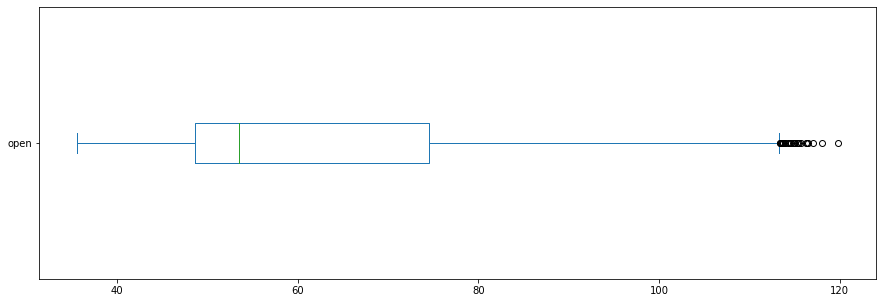

27 entradas
2.73% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [27]:
boxplot_open(df_vale3)

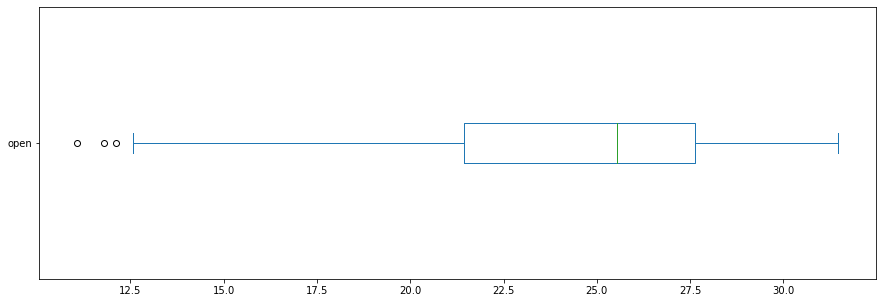

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
3 entradas
0.30% de valores abaixo do valor mínimo na abertura da bolsa


In [28]:
boxplot_open(df_petr4)

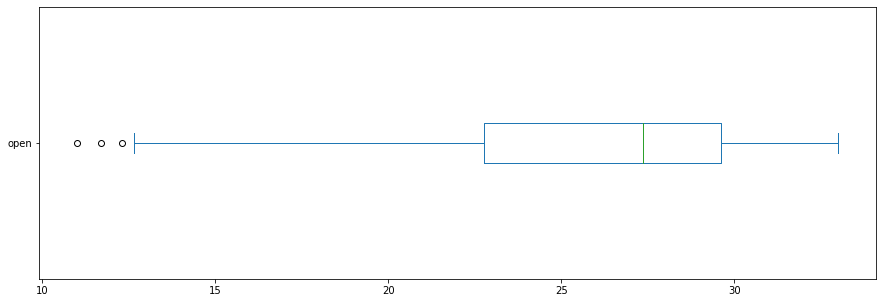

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
3 entradas
0.30% de valores abaixo do valor mínimo na abertura da bolsa


In [29]:
boxplot_open(df_petr3)

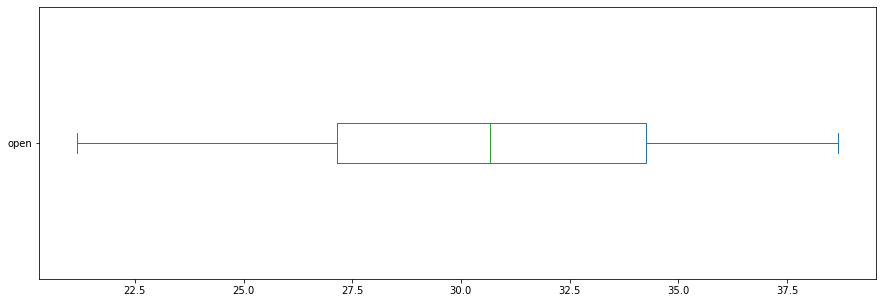

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [30]:
boxplot_open(df_itub4)

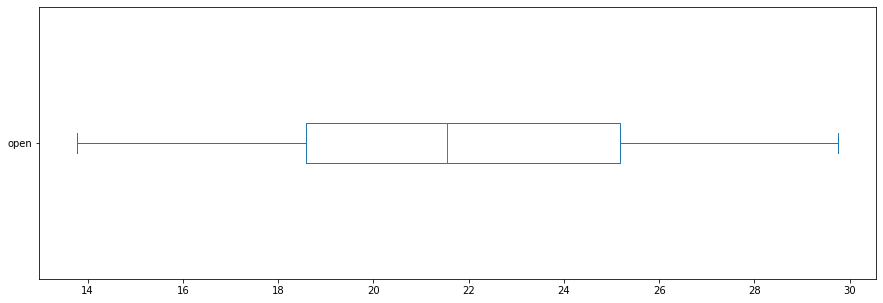

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [31]:
boxplot_open(df_bbdc4)

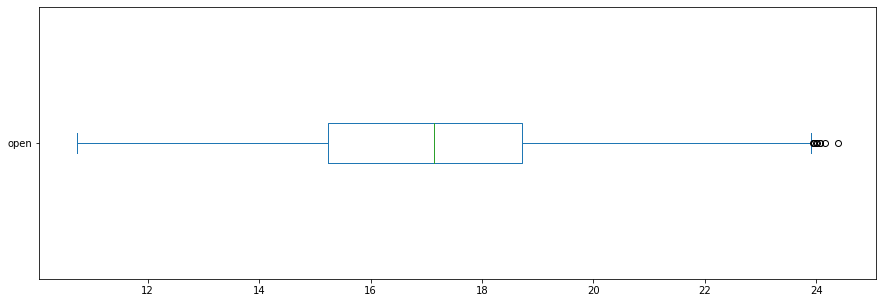

9 entradas
0.91% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [32]:
boxplot_open(df_abev3)

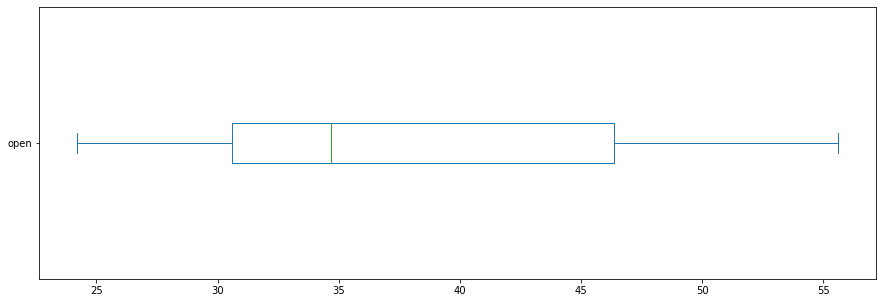

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [33]:
boxplot_open(df_bbas3)

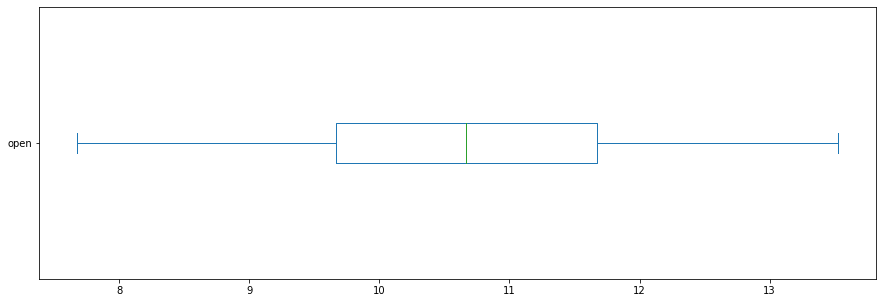

0 entradas
0.00% de valores acima do valor máximo na abertura da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo na abertura da bolsa


In [34]:
boxplot_open(df_itasa4)

#### Análise dos Outliers - Variável Close

In [35]:
#Box Plot Variável Close
def boxplot_close(df):

    df.close.plot(kind = 'box', vert = False, figsize = (15,5))
    plt.show()
    
    #Cálculo do IQR
    q1 = np.percentile(df.close, 25)  # Q1
    q3 = np.percentile(df.close, 75)  # Q3
    iqr = q3 - q1
    
    #Cálculo do mínimo e máximo extremo
    min_extremo = q1 - 1.5 * iqr 
    max_extremo = q3 + 1.5 * iqr 
    #Verificar a quantidade de valores acima do valor máximo na fechamento da bolsa
    print("{} entradas".format(len(df[df.close > max_extremo])))
    print("{:.2f}% de valores acima do valor máximo no fechamento da bolsa".format((len(df[df.close > max_extremo])
                                                                                               / df.shape[0])*100)) 
    
    #Verificar a quantidade de valores abaixo do mínimo na fechamento da bolsa
    print("{} entradas".format(len(df[df.close < min_extremo])))
    print("{:.2f}% de valores abaixo do valor mínimo no fechamento da bolsa".format((len(df[df.close < min_extremo])
                                                                                         / df.shape[0])*100)) 

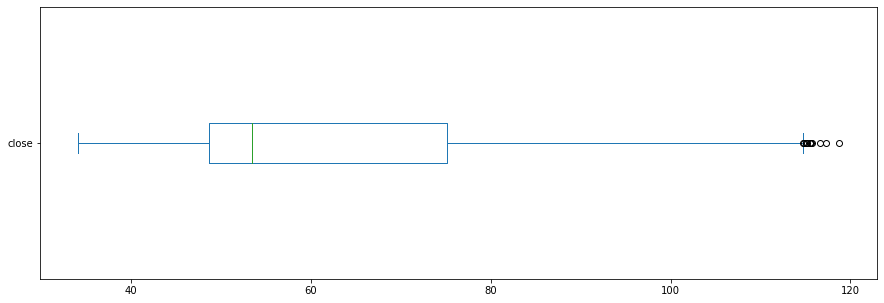

12 entradas
1.21% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [36]:
boxplot_close(df_vale3)

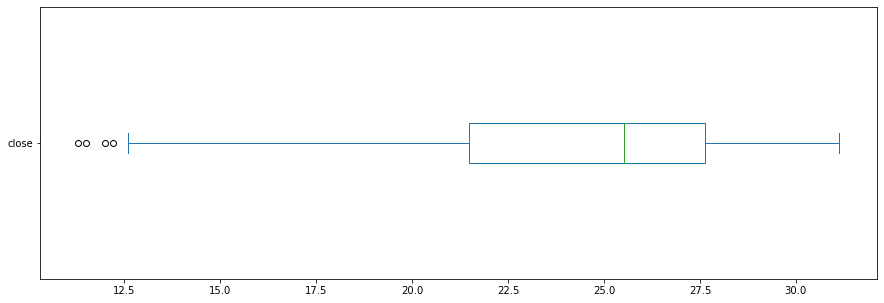

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
4 entradas
0.40% de valores abaixo do valor mínimo no fechamento da bolsa


In [37]:
boxplot_close(df_petr4)

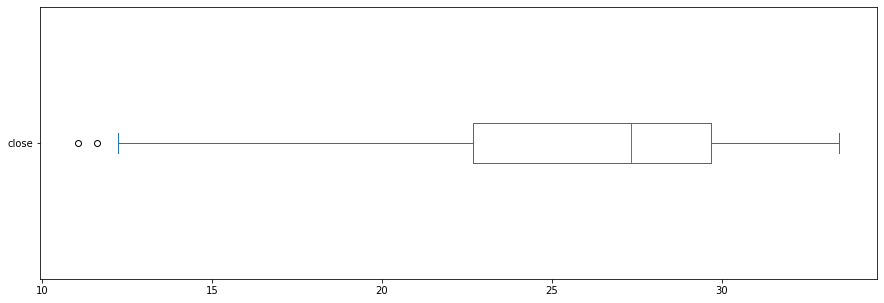

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
2 entradas
0.20% de valores abaixo do valor mínimo no fechamento da bolsa


In [38]:
boxplot_close(df_petr3)

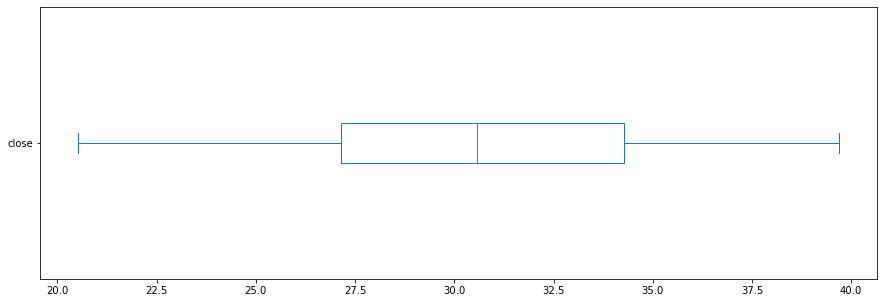

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [39]:
boxplot_close(df_itub4)

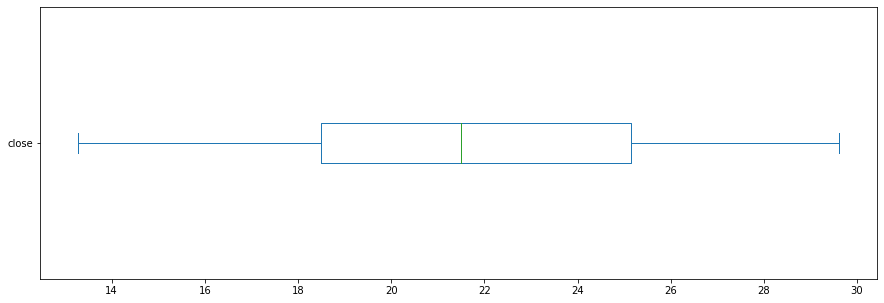

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [40]:
boxplot_close(df_bbdc4)

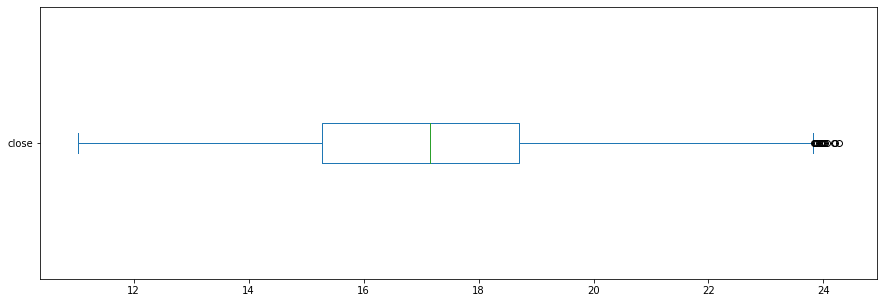

15 entradas
1.52% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [41]:
boxplot_close(df_abev3)

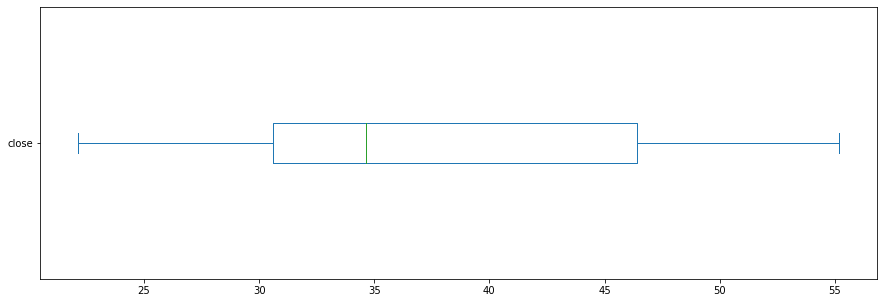

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [42]:
boxplot_close(df_bbas3)

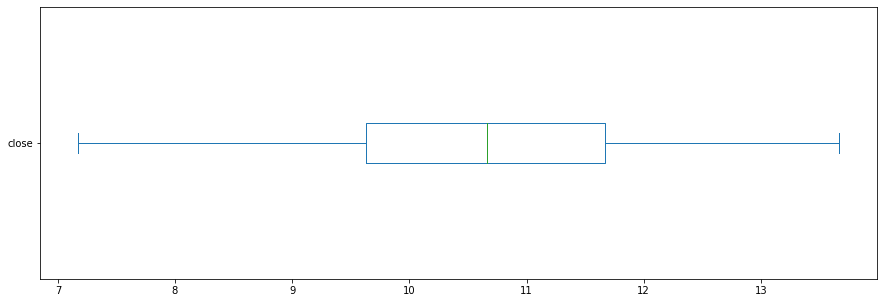

0 entradas
0.00% de valores acima do valor máximo no fechamento da bolsa
0 entradas
0.00% de valores abaixo do valor mínimo no fechamento da bolsa


In [43]:
boxplot_close(df_itasa4)

#### Análise das movimentações de fechamento x abertura da bolsa

<AxesSubplot:xlabel='codigo'>

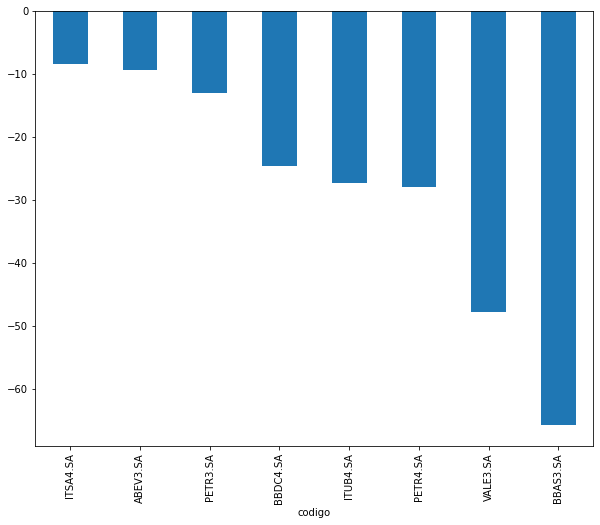

In [44]:
plt.rc('figure', figsize=(10, 8))
df_geral.groupby(['codigo']).variation_close_open.sum().sort_values(ascending = False).plot.bar()

## Análise Gráfica

In [45]:
def plot_candlesticks_new(df, indice):
    width  = 1.5   # width of real body
    width2 = 0.05  # width of shadow
    fig, ax = plt.subplots(figsize=(16,8))
    # find the rows that are bullish
    dfup = df[df.close >= df.open]
    # find the rows that are bearish
    dfdown = df[df.close < df.open]
    
    # plot the bullish candle stick
    ax.bar(dfup.index, dfup.close - dfup.open, width, 
           bottom = dfup.open, edgecolor='g', color='green')
    ax.bar(dfup.index, dfup.high - dfup.close, width2, 
           bottom = dfup.close, edgecolor='g', color='green')
    ax.bar(dfup.index, dfup.low - dfup.open, width2, 
           bottom = dfup.open, edgecolor='g', color='green')
    
    # plot the bearish candle stick
    ax.bar(dfdown.index, dfdown.close - dfdown.open, width, 
           bottom = dfdown.open, edgecolor='r', color='red')
    ax.bar(dfdown.index, dfdown.high - dfdown.open, width2, 
           bottom = dfdown.open, edgecolor='r', color='red')
    ax.bar(dfdown.index, dfdown.low - dfdown.close, width2, 
           bottom = dfdown.close, edgecolor='r', color='red')
    ax.grid(color='gray')
    plt.title('Gráfico de velas do índice {}'.format(indice))
    plt.show()

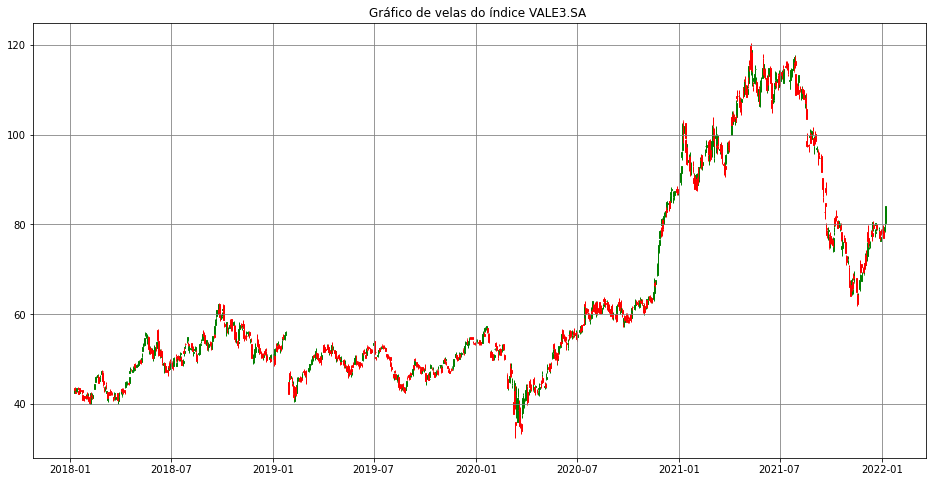

In [46]:
plot_candlesticks_new(df_vale3, 'VALE3.SA ')

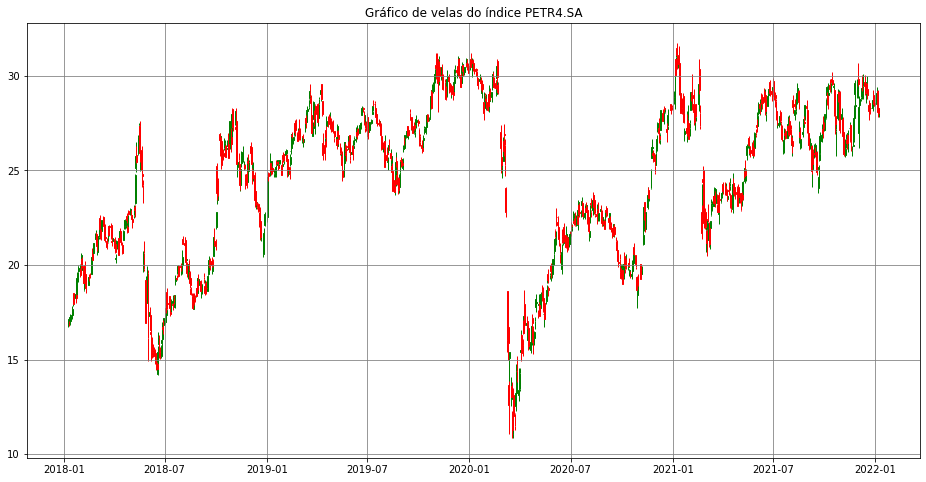

In [47]:
plot_candlesticks_new(df_petr4, 'PETR4.SA')

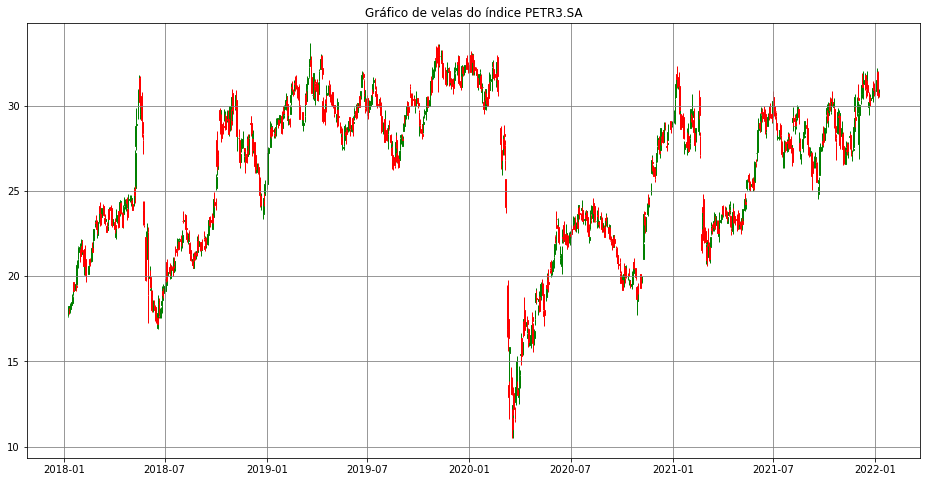

In [48]:
plot_candlesticks_new(df_petr3, 'PETR3.SA')

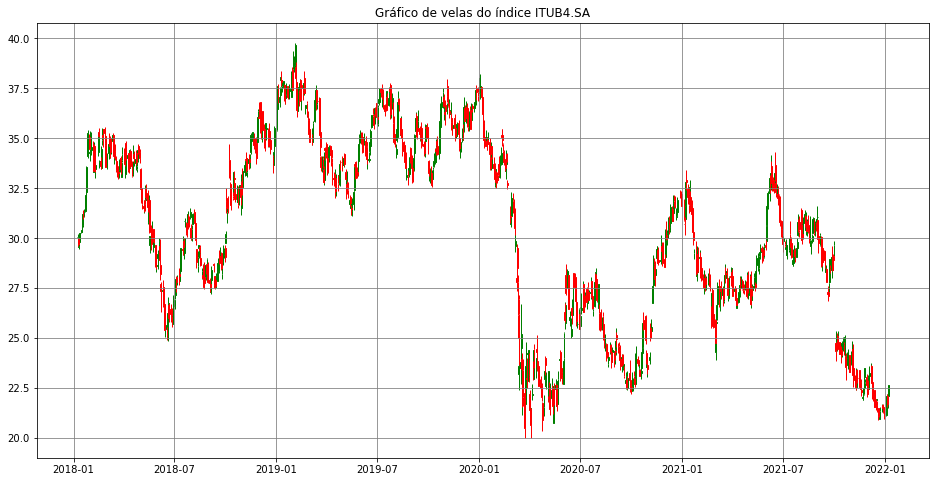

In [49]:
plot_candlesticks_new(df_itub4, 'ITUB4.SA')

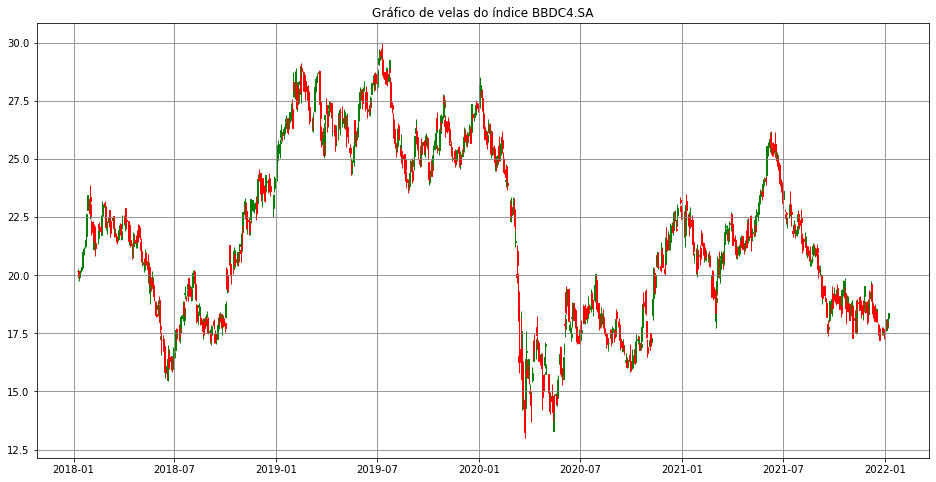

In [50]:
plot_candlesticks_new(df_bbdc4, 'BBDC4.SA')

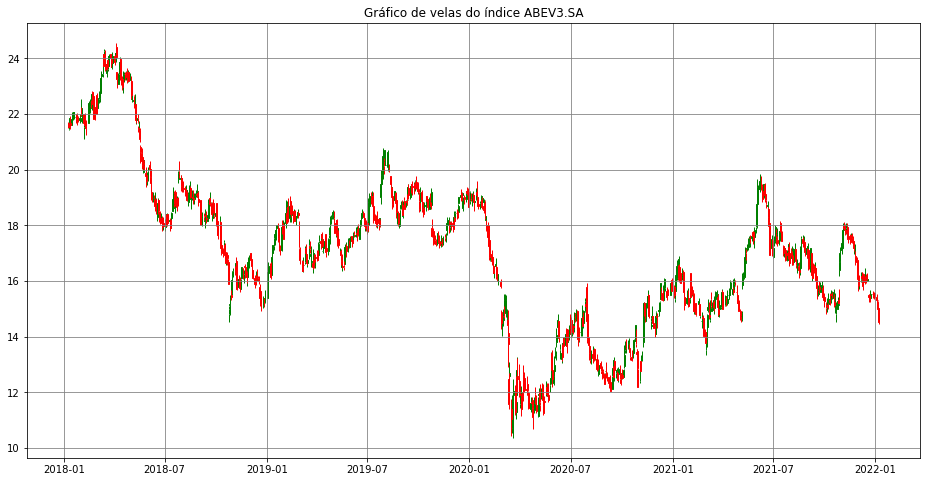

In [51]:
plot_candlesticks_new(df_abev3, 'ABEV3.SA')

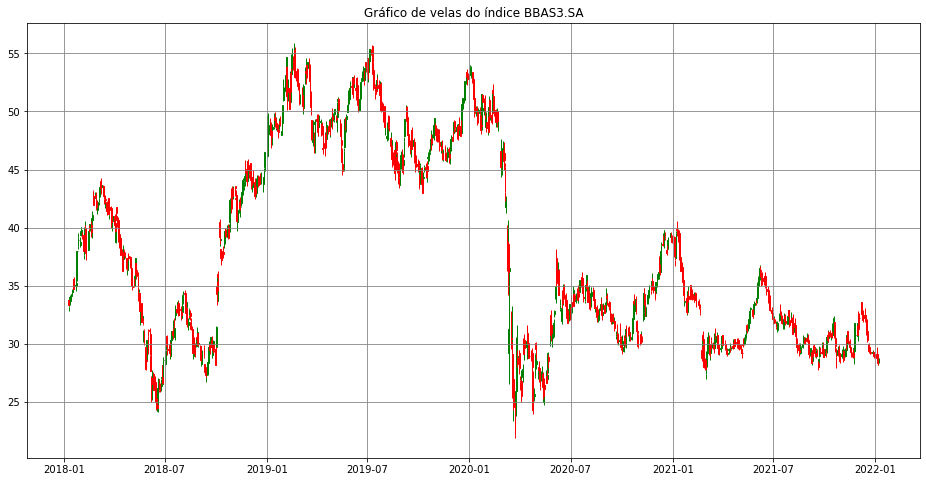

In [52]:
plot_candlesticks_new(df_bbas3, 'BBAS3.SA')

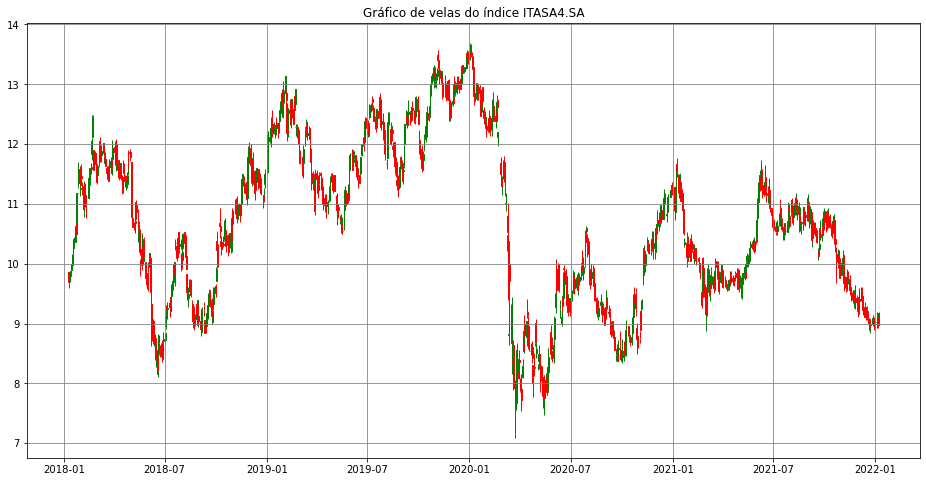

In [53]:
plot_candlesticks_new(df_itasa4, 'ITASA4.SA')

## Normalização

In [54]:
#Criar gráfico de variação do pregão da Vale
#Criar figura
def normalizacao(df):
    fig, ax = plt.subplots(figsize=(16,8))

    #Adicionar eixos
    df = df.reset_index()
    ax.plot(df.Date, df['variation_close_open'])

    

    #Títulos e nome dos eixos
    ax.set(xlabel = "Data",
          ylabel = "Preço de Variação",
          title = "Preço de variação")
    ax.axes.ticklabel_format(axis = 'y', style = 'plain')

    #legenda

    #Definir formato de data
    date_form = DateFormatter("%m-%y")
    ax.xaxis.set_major_formatter(date_form)

    plt.show()

In [55]:
df_bbas3.head(5)

codigo       high        low       open      close     volume  \
Date                                                                          
2018-01-08  BBAS3.SA  33.750000  33.340000  33.639999  33.750000  5130600.0   
2018-01-09  BBAS3.SA  33.799999  33.380001  33.590000  33.430000  5822500.0   
2018-01-10  BBAS3.SA  33.590000  32.820000  33.200001  33.290001  5070000.0   
2018-01-11  BBAS3.SA  34.220001  33.349998  33.430000  34.049999  9684400.0   
2018-01-12  BBAS3.SA  34.160000  33.619999  33.669998  34.130001  7650400.0   

            adj_close  variation_close_open condicao_variacao  amplitude  
Date                                                                      
2018-01-08  26.179523              0.110001          Positivo   0.110001  
2018-01-09  25.931297             -0.160000          Negativo   0.160000  
2018-01-10  25.822702              0.090000          Positivo   0.090000  
2018-01-11  26.412224              0.619999          Positivo   0.619999  
2018-01-12  26.474281              0.460003          Positivo   0.460003

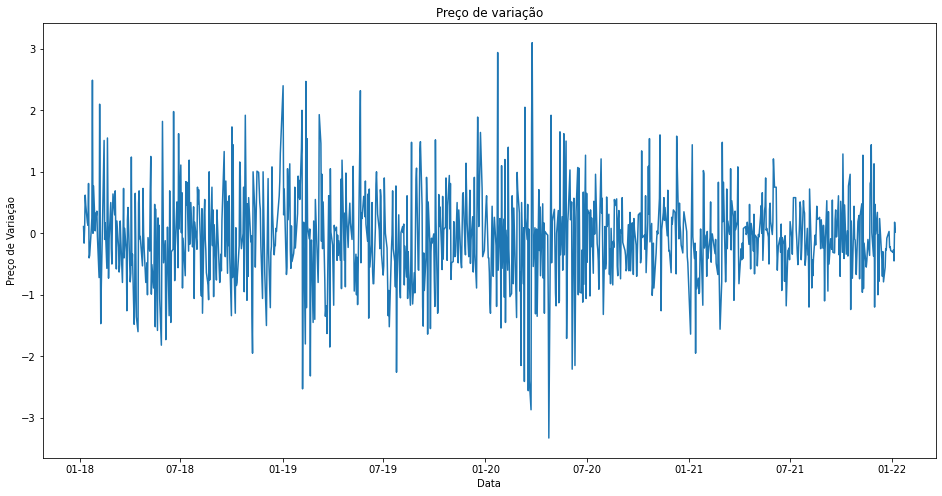

In [56]:
normalizacao(df_bbas3)

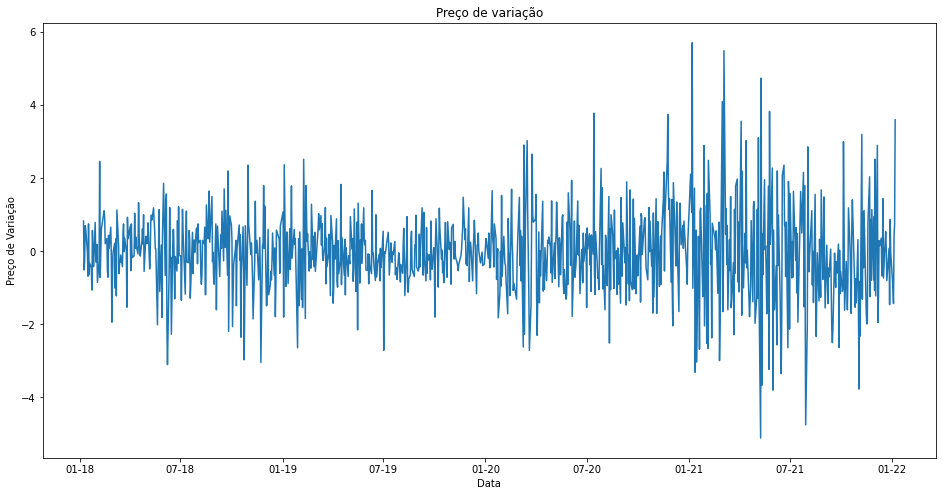

In [57]:
normalizacao(df_vale3)

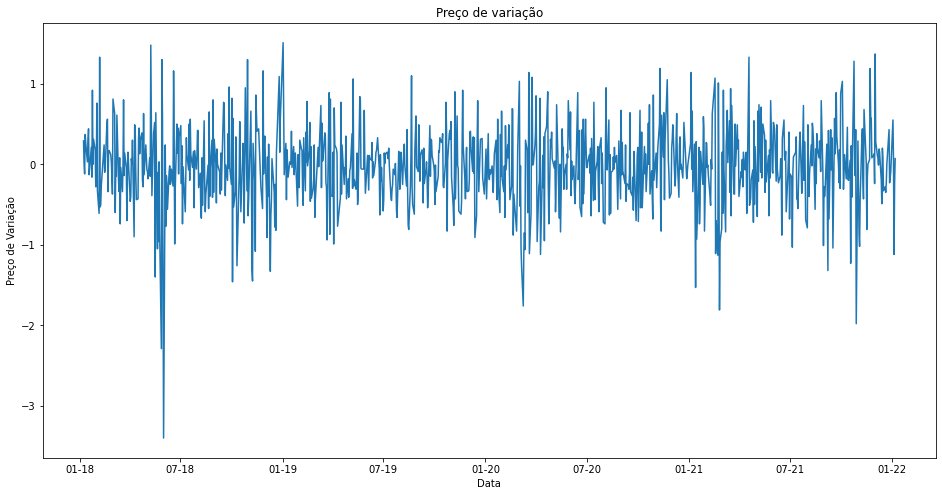

In [58]:
normalizacao(df_petr4)

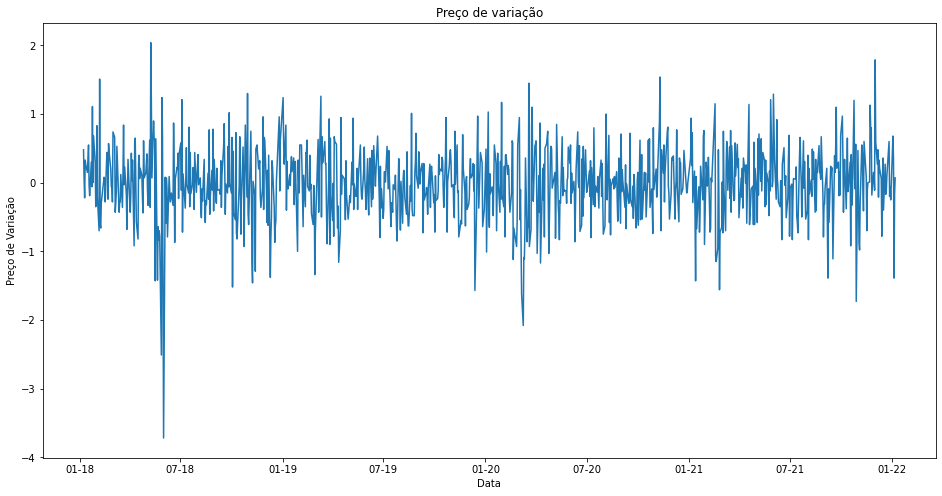

In [59]:
normalizacao(df_petr3)

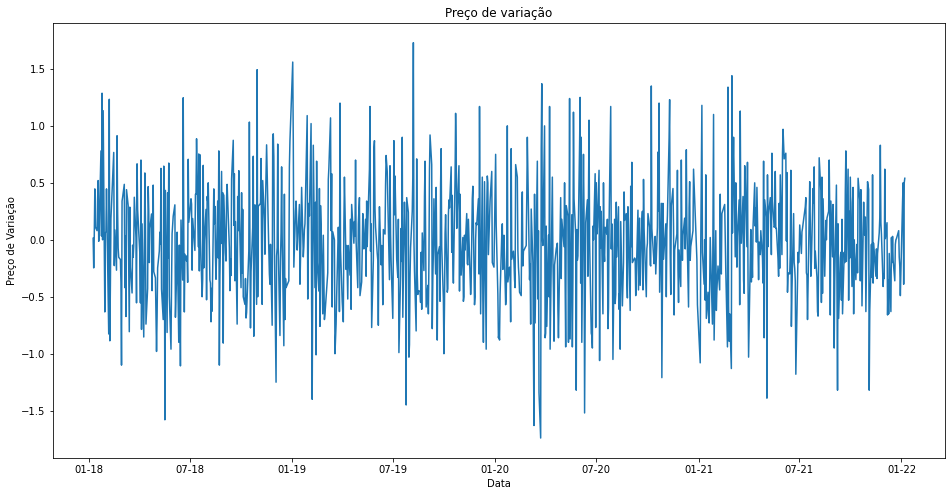

In [60]:
normalizacao(df_itub4)

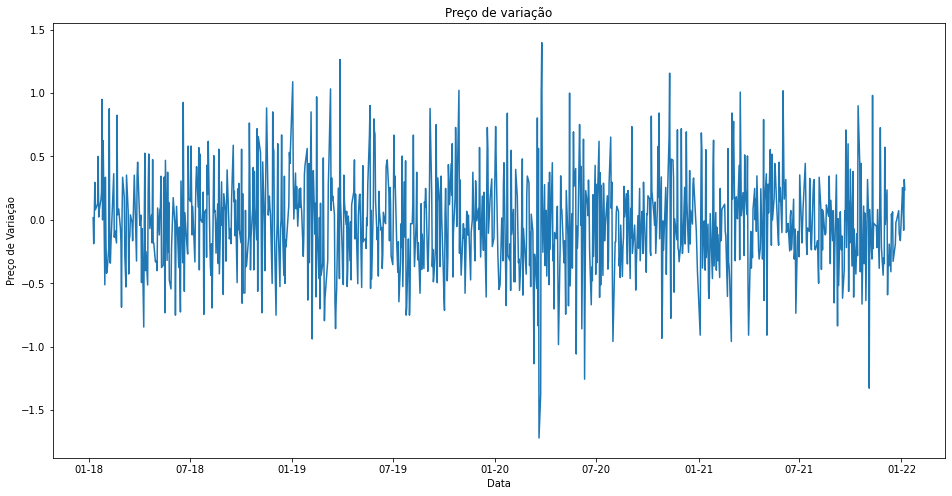

In [61]:
normalizacao(df_bbdc4)

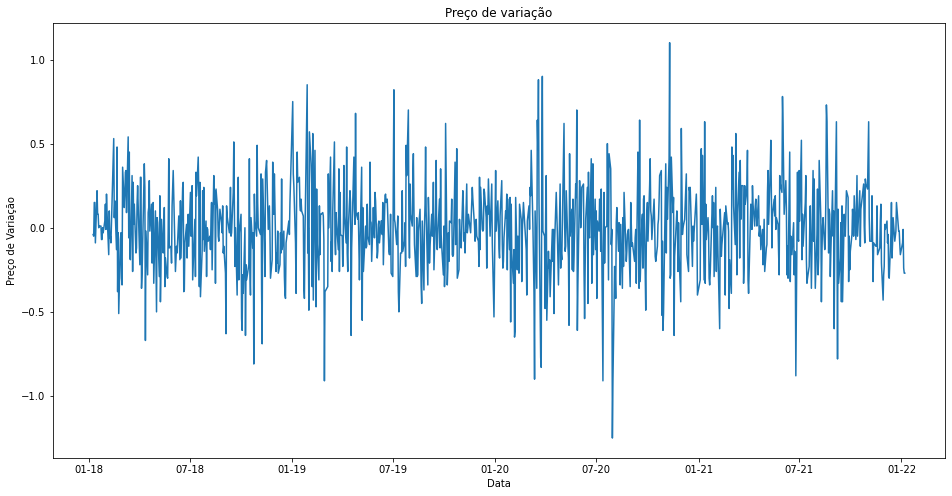

In [62]:
normalizacao(df_abev3)

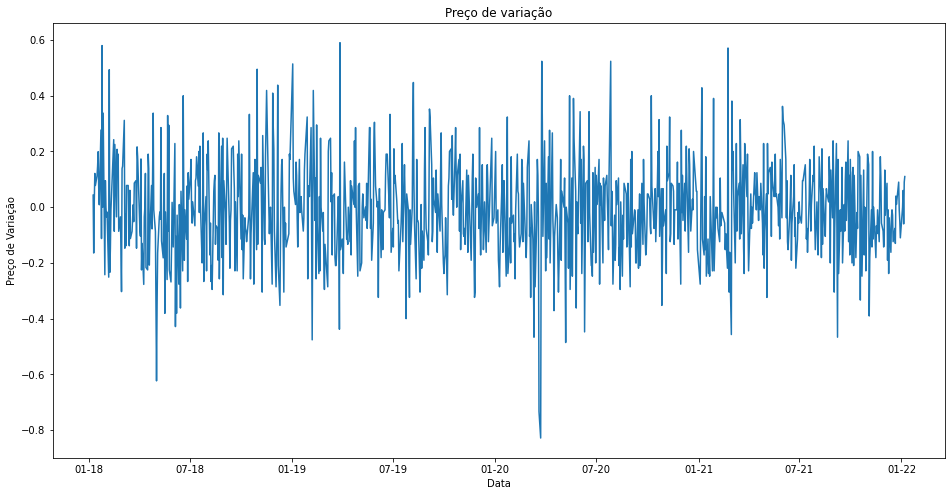

In [63]:
normalizacao(df_itasa4)

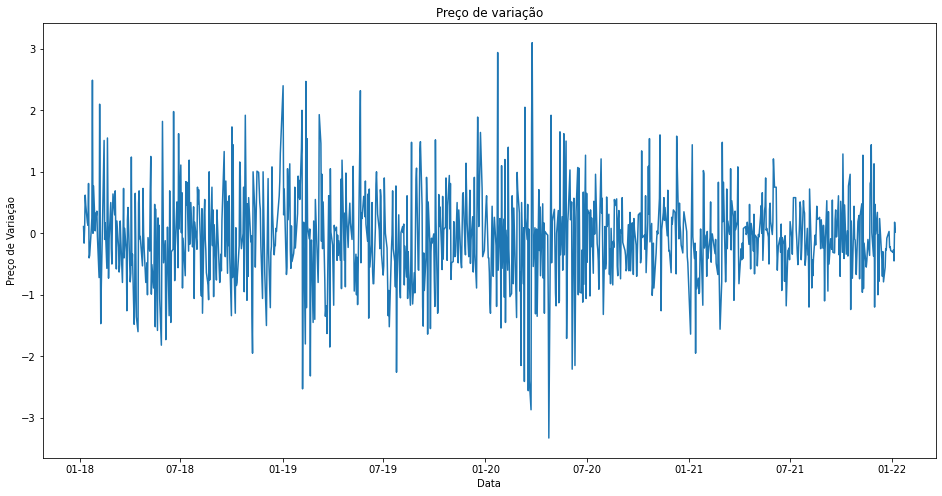

In [64]:
normalizacao(df_bbas3)

## Pré processamento dos dados

#### Split de dados de treino e teste dos dados de índices

In [65]:
periodo_total = df_geral.index.max() - df_geral.index.min()

In [66]:
periodo_total

Timedelta('1460 days 00:00:00')

In [67]:
periodo_total *0.2

Timedelta('292 days 00:00:00')

In [68]:
period = 292
def split_train_test(df, indice, periodo):
    df_indice = df.copy()
    df_indice = df_indice.loc[df_indice['codigo'] == indice]
    
    model_train = df_indice.iloc[:-periodo,4:5].copy()
    model_test= df_indice.iloc[-periodo:,[0,4]].copy()
    
    return model_train, model_test

In [69]:
df_train_vale, df_test_vale = split_train_test(df_geral, "VALE3.SA", period)

In [70]:
df_test_vale.head(5)

codigo      close
Date                           
2020-10-30  VALE3.SA  60.549999
2020-11-03  VALE3.SA  63.340000
2020-11-04  VALE3.SA  61.580002
2020-11-05  VALE3.SA  62.549999
2020-11-06  VALE3.SA  63.189999

In [71]:
df_train_ptr4, df_test_ptr4 = split_train_test(df_geral, "PETR4.SA", period)

In [72]:
df_train_ptr3, df_test_ptr3 = split_train_test(df_geral, "PETR3.SA", period)

In [73]:
df_train_itub4 , df_test_itub4 = split_train_test(df_geral, "ITUB4.SA", period)

In [74]:
df_train_bbdc4, df_test_bbdc4 = split_train_test(df_geral, "BBDC4.SA", period)

In [75]:
df_train_abev3, df_test_abev3 = split_train_test(df_geral, "ABEV3.SA", period)

In [76]:
df_train_bbas3, df_test_bbas3 = split_train_test(df_geral, "BBAS3.SA", period)

In [77]:
df_train_itsa4, df_test_itsa4 = split_train_test(df_geral, "ITSA4.SA", period)

In [78]:
#Visualização da série com a divisão do período entre treino e teste
def visualizacao_serie(modelo_treino, modelo_teste):
    
    
    plt.plot(modelo_treino['close'],  color='b')
    plt.plot(modelo_teste['close'],  color='orange')
    
    plt.title('Série dividida entre treino e teste')
    plt.legend(['Treino','Teste'])
    plt.xlabel('DATA')
    plt.ylabel('FECHAMENTO')
    plt.show()

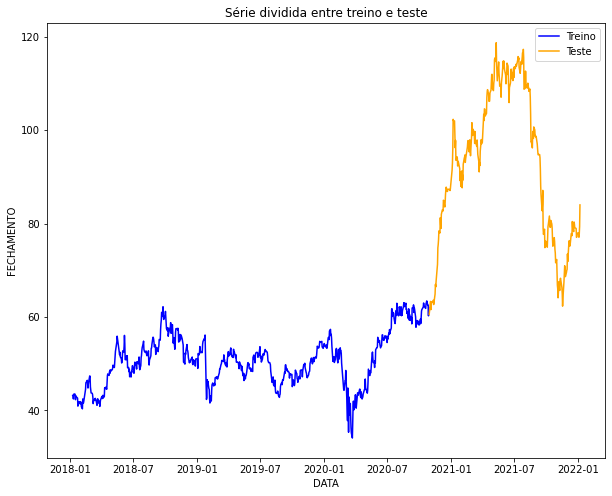

In [79]:
visualizacao_serie(df_train_vale,df_test_vale)

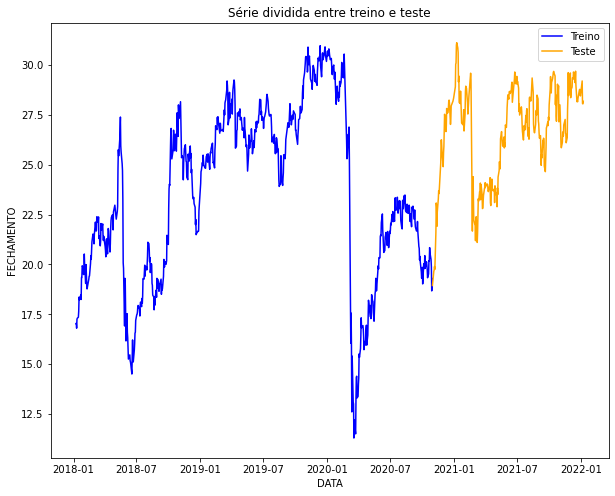

In [80]:
visualizacao_serie(df_train_ptr4,df_test_ptr4)

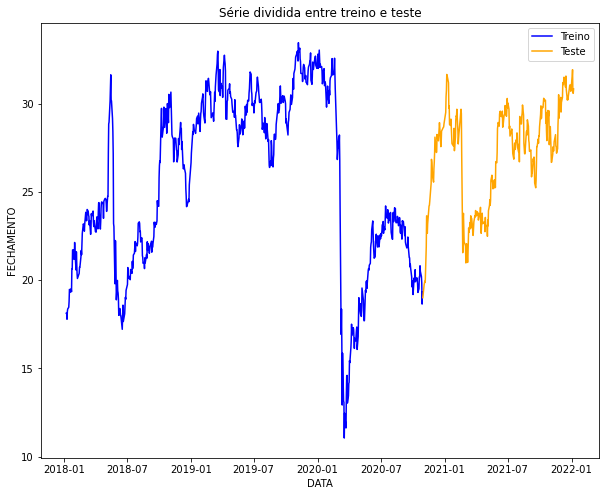

In [81]:
visualizacao_serie(df_train_ptr3,df_test_ptr3)

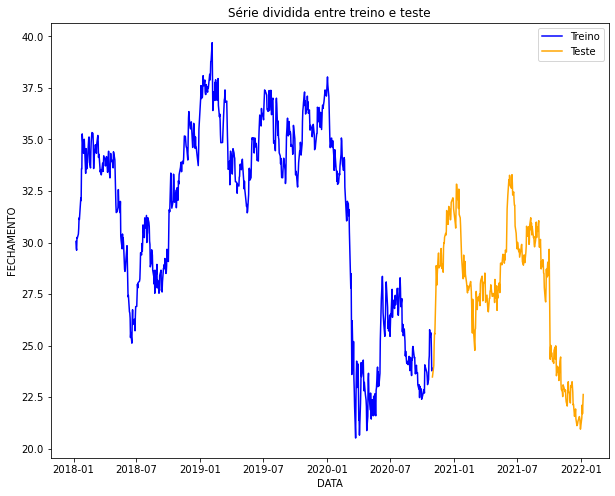

In [82]:
visualizacao_serie(df_train_itub4,df_test_itub4)

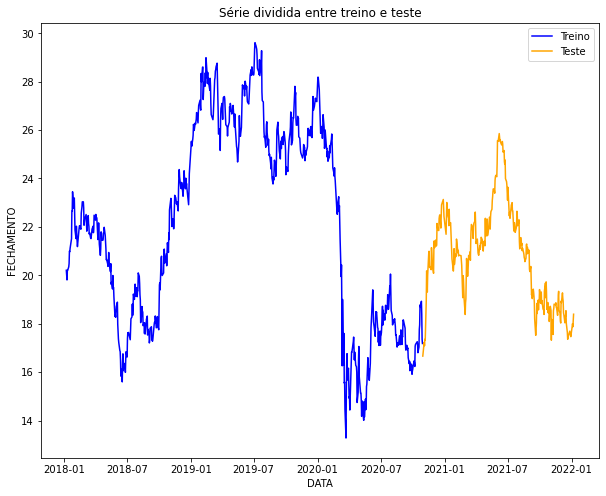

In [83]:
visualizacao_serie(df_train_bbdc4,df_test_bbdc4)

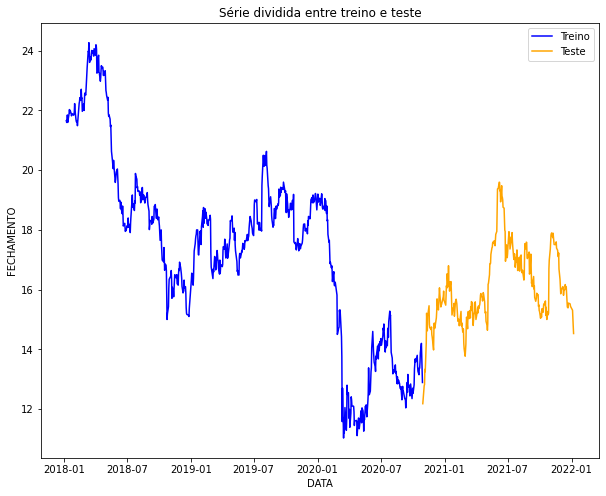

In [84]:
visualizacao_serie(df_train_abev3,df_test_abev3)

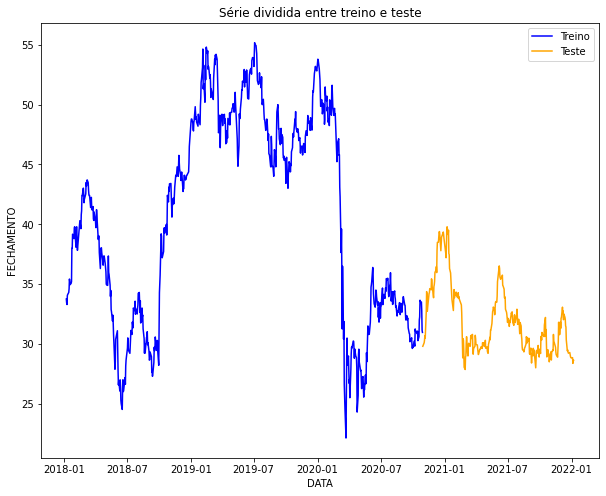

In [85]:
visualizacao_serie(df_train_bbas3,df_test_bbas3)

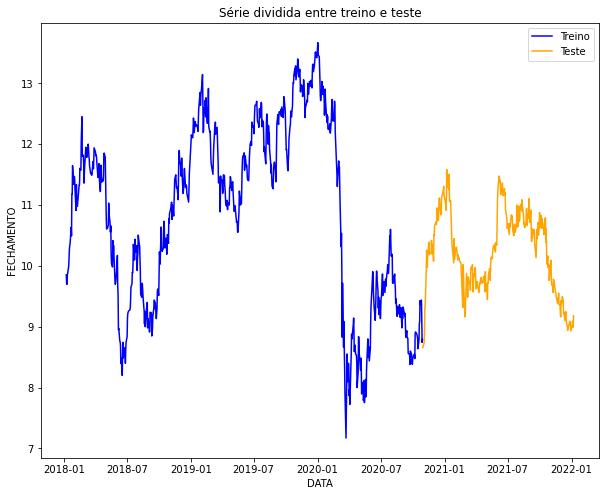

In [86]:
visualizacao_serie(df_train_itsa4,df_test_itsa4)

## Criação de modelos de Machine Learning

### Prophet

In [87]:
def prophet_dict(treino,teste):
    results_prophet = {}
    ph_model = Prophet(daily_seasonality=True, interval_width=0.95)
    
    ph_treino = (pd.DataFrame(treino["close"]).set_index(treino.index).reset_index(drop=False)
                 .rename(columns = {'close': 'y', 'Date' : 'ds','index' : 'ds'}))

    ph_teste = (pd.DataFrame(teste["close"]).set_index(teste.index).reset_index(drop=False)
                 .rename(columns = {'close': 'y_pred', 'Date' : 'ds','index' : 'ds'}))

    if not ph_treino.empty:
        
        ph_model.fit(ph_treino)
        previsao = ph_model.predict(ph_teste)
        
        #Converter os valores negativos em 0                
        previsao['yhat'] = np.where(previsao['yhat']<0,0,previsao['yhat'])
        y_real = ph_teste['y_pred'].values
        result_prophet = pd.DataFrame()
        result_prophet['y_pred_lower'] = previsao['yhat_lower'].values
        result_prophet['y_pred_upper'] = previsao['yhat_upper'].values
        
        result_prophet['y_pred'] = previsao['yhat_lower'].values
        
        result_prophet['y_pred'] = previsao['yhat'].values 
        result_prophet['y_real'] = y_real
        
        result_prophet['codigo'] = (teste['codigo'].values)
        result_prophet = result_prophet[['codigo','y_real','y_pred', 'y_pred_lower', 'y_pred_upper']]
        
    return result_prophet

# Realizar o prophet para outras empresas

In [88]:
resultados_vale_prophet = prophet_dict(df_train_vale, df_test_vale)

In [89]:
resultados_vale_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  VALE3.SA  60.549999  64.179016     58.691627     70.280195
1  VALE3.SA  63.340000  64.649539     58.775258     70.412147
2  VALE3.SA  61.580002  64.660821     59.172877     70.547471
3  VALE3.SA  62.549999  64.608926     58.674870     70.409571
4  VALE3.SA  63.189999  64.714688     58.963243     70.464872

In [90]:
resultados_petr4_prophet = prophet_dict(df_train_ptr4, df_test_ptr4)

In [91]:
resultados_petr4_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  PETR4.SA  18.940001  23.674847     18.945617     28.561909
1  PETR4.SA  19.650000  24.037209     19.038175     29.068437
2  PETR4.SA  19.719999  24.049778     19.278424     29.106795
3  PETR4.SA  19.889999  24.081319     19.144316     29.106253
4  PETR4.SA  19.750000  24.076856     19.249538     29.040535

In [92]:
resultados_petr3_prophet = prophet_dict(df_train_ptr3, df_test_ptr3)

In [93]:
resultados_petr3_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  PETR3.SA  19.000000  23.812980     18.531912     29.069494
1  PETR3.SA  19.750000  24.202406     19.153131     29.742264
2  PETR3.SA  19.840000  24.179430     18.846077     29.730314
3  PETR3.SA  19.940001  24.193832     18.926613     29.561265
4  PETR3.SA  19.870001  24.201940     18.748789     29.779904

In [94]:
resultados_itub4_prophet = prophet_dict(df_train_itub4, df_test_itub4)

In [95]:
resultados_itub4_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  ITUB4.SA  23.480000  25.537020     23.385764     27.740848
1  ITUB4.SA  24.040001  25.631017     23.623159     27.626215
2  ITUB4.SA  25.000000  25.592806     23.498689     27.787285
3  ITUB4.SA  25.590000  25.646361     23.532582     27.901023
4  ITUB4.SA  25.559999  25.666765     23.446132     27.794246

In [96]:
resultados_bbdc4_prophet = prophet_dict(df_train_bbdc4, df_test_bbdc4)

In [97]:
resultados_bbdc4_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  BBDC4.SA  16.661158  19.431749     17.480257     21.313906
1  BBDC4.SA  17.231403  19.606078     17.674717     21.364783
2  BBDC4.SA  17.090908  19.589513     17.728246     21.321614
3  BBDC4.SA  17.355371  19.618726     17.827329     21.403001
4  BBDC4.SA  17.314049  19.636958     17.752103     21.507129

In [98]:
resultados_abev3_prophet = prophet_dict(df_train_abev3, df_test_abev3)

In [99]:
resultados_abev3_prophet.head(5)

codigo  y_real     y_pred  y_pred_lower  y_pred_upper
0  ABEV3.SA   12.18  12.260666     10.894983     13.619378
1  ABEV3.SA   12.78  12.098667     10.788525     13.464920
2  ABEV3.SA   12.82  11.997510     10.761444     13.253077
3  ABEV3.SA   13.33  11.945823     10.609049     13.168063
4  ABEV3.SA   13.25  11.902407     10.623133     13.210646

In [100]:
resultados_bbas3_prophet = prophet_dict(df_train_bbas3, df_test_bbas3)

In [101]:
resultados_bbas3_prophet.head(5)

codigo     y_real     y_pred  y_pred_lower  y_pred_upper
0  BBAS3.SA  29.799999  36.507616     31.346021     41.538665
1  BBAS3.SA  30.100000  36.957675     31.942160     42.100612
2  BBAS3.SA  30.320000  37.010252     32.044709     41.637611
3  BBAS3.SA  30.690001  37.149632     31.897660     41.857228
4  BBAS3.SA  30.490000  37.260569     32.243709     42.231020

In [102]:
resultados_itsa4_prophet = prophet_dict(df_train_itsa4, df_test_itsa4)

In [103]:
resultados_itsa4_prophet.head(5)

codigo    y_real    y_pred  y_pred_lower  y_pred_upper
0  ITSA4.SA  8.657142  9.758165      8.931400     10.644373
1  ITSA4.SA  8.742857  9.876991      9.056538     10.669718
2  ITSA4.SA  8.942857  9.891962      9.108019     10.687819
3  ITSA4.SA  9.314285  9.920726      9.051136     10.726420
4  ITSA4.SA  9.361904  9.926871      9.106808     10.717295

In [104]:
def metricas_prophet(df_test,results):
    mse_prophet = mean_squared_error(results.y_real, results.y_pred)
    rmse_prophet = np.sqrt(mse_prophet)
    mape_prophet = mean_absolute_percentage_error(results.y_real, results.y_pred)
    
    print('O MSE dessa previsão é {}'.format(round(mse_prophet, 2)))
    print('O RMSE dessa previsão é {}'.format(round(rmse_prophet, 2)))
    print('O MAPE dessa previsão é {}'.format(round(mape_prophet, 2)))
    return mse_prophet, rmse_prophet, mape_prophet

In [105]:
mse_vale_prophet, rmse_vale_prophet, mape_vale_prophet = metricas_prophet(df_test_vale,resultados_vale_prophet)

O MSE dessa previsão é 637.84
O RMSE dessa previsão é 25.26
O MAPE dessa previsão é 0.24


In [106]:
mse_petr4_prophet, rmse_petr4_prophet, mape_petr4_prophet = metricas_prophet(df_test_ptr4,resultados_petr4_prophet)

O MSE dessa previsão é 31.38
O RMSE dessa previsão é 5.6
O MAPE dessa previsão é 0.19


In [107]:
mse_petr3_prophet, rmse_petr3_prophet, mape_petr3_prophet = metricas_prophet(df_test_ptr3,resultados_petr3_prophet)

O MSE dessa previsão é 39.67
O RMSE dessa previsão é 6.3
O MAPE dessa previsão é 0.2


In [108]:
mse_itub4_prophet, rmse_itub4_prophet, mape_itub4_prophet = metricas_prophet(df_test_itub4,resultados_itub4_prophet)

O MSE dessa previsão é 55.9
O RMSE dessa previsão é 7.48
O MAPE dessa previsão é 0.22


In [109]:
mse_bbdc4_prophet, rmse_bbdc4_prophet, mape_bbdc4_prophet = metricas_prophet(df_test_bbdc4, resultados_bbdc4_prophet)

O MSE dessa previsão é 14.93
O RMSE dessa previsão é 3.86
O MAPE dessa previsão é 0.15


In [110]:
mse_abev3_prophet, rmse_abev3_prophet, mape_abev3_prophet = metricas_prophet(df_test_abev3, resultados_bbdc4_prophet)

O MSE dessa previsão é 14.93
O RMSE dessa previsão é 3.86
O MAPE dessa previsão é 0.15


In [111]:
mse_bbas3_prophet, rmse_bbas3_prophet, mape_bbas3_prophet = metricas_prophet(df_test_bbas3,resultados_bbas3_prophet)

O MSE dessa previsão é 87.22
O RMSE dessa previsão é 9.34
O MAPE dessa previsão é 0.27


In [112]:
mse_itsa4_prophet, rmse_itsa4_prophet, mape_itsa4_prophet = metricas_prophet(df_test_itsa4,resultados_itsa4_prophet)

O MSE dessa previsão é 1.23
O RMSE dessa previsão é 1.11
O MAPE dessa previsão é 0.09


## Arima Sazonal

In [113]:
#definir intervalo de parâmetros 
p = range(0,4) 
q = range(1,4) 
d = range(0,1) 
s = range(7,8)


# lista de todos os combos de parâmetros 
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = list(itertools.product(p, d, q, s))


season_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q,s))]
print('Exemplos de combinação de parâmetros para Sarima...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Exemplos de combinação de parâmetros para Sarima...
SARIMAX: (0, 0, 2) x (0, 0, 2, 7)
SARIMAX: (0, 0, 2) x (0, 0, 3, 7)
SARIMAX: (0, 0, 3) x (1, 0, 1, 7)
SARIMAX: (0, 0, 3) x (1, 0, 2, 7)


In [114]:
warnings.filterwarnings("ignore")  #Ignorar mensagens de aviso

def sarimax(df_treino, seasonal_pdq, pdq):
    parametros = []
    start_time = time.time()
    treino_array = np.array(df_treino.values)
    for param in tqdm(pdq):
        for param_seasonal in seasonal_pdq:
            try:
                sarima = sm.tsa.statespace.SARIMAX(treino_array,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = sarima.fit()
                print('SARIMA{}x{}7 - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
                                
            except:
                continue
            aic = results.aic
            bic= results.bic
            
            parametros.append([param,param_seasonal,aic,bic])
    print("--- %s seconds ---" % (time.time() - start_time))
    result_table = pd.DataFrame(parametros)
       
    result_table.columns = ['parameters','parameters_seasonal','aic','bic']
    result_table = result_table.sort_values(by=['aic','bic'],ascending = True).reset_index()
    minimo_aic = result_table['aic'].min()
    minino_bic = result_table['bic'].min()
    minimo = result_table.loc[(result_table['aic'] == minimo_aic) | (result_table['bic'] == minino_bic)]
    print(f'A melhor combinação que traz o mínimo de AIC e BIC: {minimo}')

In [115]:
def sarima_table (df_treino, order, seasonal_order):
    start_time = time.time()

    sarima = sm.tsa.statespace.SARIMAX(df_treino.values, order=order, seasonal_order=seasonal_order, enforce_invertibility=False)
    results = sarima.fit()
    print(results.summary().tables[1])

    print("--- %s segundos ---" % (time.time() - start_time))
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    return results

In [116]:
sarimax(df_train_vale, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:5676.418658173039 - BIC:5690.02438198608
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:5090.217240368711 - BIC:5108.317359000085
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:4574.182463250814 - BIC:4596.756026705177
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:2962.60389391465 - BIC:2980.744858998705
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:2939.2960016905636 - BIC:2961.9211499797807
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:2917.0544692096755 - BIC:2944.142745354911
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:2946.737357106427 - BIC:2969.37714669454
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:2940.8366785052212 - BIC:2967.986856452282
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:2930.832760972055 - BIC:2962.4357498081627
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:2922.7462465807157 - BIC:2949.8522742181895
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:2924.937959384241 - BIC:2956.561658294627


  8%|▊         | 1/12 [00:58<10:39, 58.18s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:2918.9420005088077 - BIC:2955.059702035788
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:5182.399488419105 - BIC:5200.534643770839
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:4609.557920310433 - BIC:4632.17573184118
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:4148.829008318553 - BIC:4175.908388984027
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:2963.81173885263 - BIC:2986.4806830422967
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:2817.2734902084453 - BIC:2844.4148640453423
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:2816.3210778784946 - BIC:2847.913688654881
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:2803.050191065826 - BIC:2830.2179385715613
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:2839.7140602267677 - BIC:2871.378996369814
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:2806.9651605975696 - BIC:2843.0710014848682
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:2795.0583997916237 - BIC:2826.6820987020096
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:2782.6483407058727 - BIC:2818.7897108891707


 17%|█▋        | 2/12 [02:14<11:28, 68.85s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:2784.6436474062166 - BIC:2825.2627184044272
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:4629.336497374246 - BIC:4651.998168835358
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:4117.017165434367 - BIC:4144.1497222233875
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:3720.8301705745703 - BIC:3752.4123878820833
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:2669.576891363645 - BIC:2696.770897116979
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:2649.182088428631 - BIC:2680.836738015822
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:2629.5799610503464 - BIC:2665.673923687504
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:2892.4911495793476 - BIC:2924.1868550027057
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:2767.3944490708236 - BIC:2803.571191456185
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:2689.289632468028 - BIC:2729.8953404348304
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:2659.1264989706274 - BIC:2695.2678691539254
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:2638.2892850578164 - BIC:2678.948326514027


 25%|██▌       | 3/12 [04:14<13:51, 92.35s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:2729.8186313548717 - BIC:2774.936084651319
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:2351.577674895092 - BIC:2369.7186399791467
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:2334.2584592619583 - BIC:2356.8836075511754
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:2315.988751448346 - BIC:2343.0770275935815
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:2353.331856846694 - BIC:2376.008063201762
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:2336.2412316829787 - BIC:2363.3914096300396
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:2317.9243729335644 - BIC:2349.527361769672
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:2338.7025085844634 - BIC:2365.8614777418884
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:2338.6073560828527 - BIC:2370.282563687757
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:2318.518410559611 - BIC:2354.6361120865913
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:2320.5290285987408 - BIC:2352.1423801310416
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:2340.8498140526917 - BIC:2376.9793586610353


 33%|███▎      | 4/12 [04:59<09:49, 73.63s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:2321.590155253528 - BIC:2362.2225694713807
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:2348.4413985507254 - BIC:2371.1103427403923
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:2331.0727278319664 - BIC:2358.2141016688633
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:2313.10333188499 - BIC:2344.695942661376
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:2351.5555285876762 - BIC:2378.7582616152763
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:2333.0390576432305 - BIC:2364.703993786277
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:2318.4207841853176 - BIC:2354.5266250726163
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:2338.5390946162843 - BIC:2370.2245586332797
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:2335.4210636658827 - BIC:2371.609562115079
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:2315.5163263672507 - BIC:2356.1353973654614
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:2320.0097779641 - BIC:2356.1393225724437
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:2320.6253456428067 - BIC:2361.2710833271935


 42%|████▏     | 5/12 [05:44<07:22, 63.19s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:2319.0244802095112 - BIC:2364.1567813186343
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:2347.8241093507777 - BIC:2375.018115104112
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:2330.5292709464857 - BIC:2362.183920533677
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:2312.20404986802 - BIC:2348.2980125051777
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:2349.6801610642215 - BIC:2381.4065011097778
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:2332.5084234288615 - BIC:2368.6851658142227
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:2314.0519860723125 - BIC:2354.657694039115
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:2340.2275760919183 - BIC:2376.4395349684846
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:2335.5043415406462 - BIC:2376.2031767241774
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:2315.2224828192484 - BIC:2360.3399361156958
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:2325.0425089855753 - BIC:2365.688246669962
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:2342.351997603071 - BIC:2387.513928363501


 50%|█████     | 6/12 [06:43<06:10, 61.79s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:2317.941510957324 - BIC:2367.5707095834164
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:2350.69247383137 - BIC:2373.3686801864383
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:2333.6620795239533 - BIC:2360.812257471014
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:2315.549483115462 - BIC:2347.1524719515696
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:2352.542769664761 - BIC:2379.754217290843
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:2337.9178122016806 - BIC:2369.593019806585
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:2319.0487722947496 - BIC:2355.16647382173
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:2335.62812757221 - BIC:2367.303335177114
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:2355.465792341363 - BIC:2391.6660296041105
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:2339.3929228949514 - BIC:2380.025337112804
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:2321.8163006451023 - BIC:2357.9340021720827
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:2318.18968537391 - BIC:2358.8220995917627


 58%|█████▊    | 7/12 [07:44<05:06, 61.39s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:2323.225202133475 - BIC:2368.3723290422
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:2349.018260067777 - BIC:2376.2209930953773
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:2331.769160591755 - BIC:2363.434096734801
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:2313.8271354428052 - BIC:2349.932976330104
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:2350.7601416974903 - BIC:2382.4966635630235
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:2333.7388511955805 - BIC:2369.9273496447768
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:2318.0210555979866 - BIC:2358.640126596197
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:2336.2798424046878 - BIC:2372.4800796674353
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:2336.0815665696036 - BIC:2376.7936273249493
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:2316.5107883941546 - BIC:2361.6430895032777
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:2320.043198928841 - BIC:2360.6756131466936
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:2318.6312716879856 - BIC:2363.7783985967108


 67%|██████▋   | 8/12 [08:37<03:55, 58.92s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:2318.5860104843023 - BIC:2368.231541704338
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:2349.884601765332 - BIC:2381.610941810888
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:2332.719427232432 - BIC:2368.896169617793
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:2313.9255546218656 - BIC:2354.531262588668
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:2353.651222964417 - BIC:2389.9098973021955
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:2355.2535799594325 - BIC:2395.9524151429637
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:2337.334903329238 - BIC:2382.4523566256853
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:2361.3432452300012 - BIC:2402.0685121505926
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:2337.4712435592755 - BIC:2382.692171540977
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:2319.5511500420143 - BIC:2369.1803486681065
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:2325.714892722606 - BIC:2370.862019631331
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:2328.8234144213684 - BIC:2378.4852540209663


 75%|███████▌  | 9/12 [10:11<03:29, 69.69s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:2335.668074317226 - BIC:2389.809018272963
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:2351.7378378124995 - BIC:2378.9492854385812
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:2334.3778401250875 - BIC:2366.0530477299917
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:2316.912013932758 - BIC:2353.0297154597383
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:2351.377416154425 - BIC:2383.1139380199584
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:2336.655885149119 - BIC:2372.8561224118666
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:2318.889488198598 - BIC:2359.5219024164508
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:2334.4102906165876 - BIC:2370.598789065784
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:2352.5768395175282 - BIC:2393.288900272874
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:2319.4245615372174 - BIC:2364.5716884459425
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:2316.9019228186944 - BIC:2357.520993816905
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:2336.337861424904 - BIC:2381.470162534027


 83%|████████▎ | 10/12 [11:20<02:18, 69.50s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:2333.8854318700787 - BIC:2383.5309630901143
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:2351.002214686724 - BIC:2382.7387365522573
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:2333.828204706306 - BIC:2370.0167031555025
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:2317.156059228543 - BIC:2357.775130226754
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:2352.9916508105844 - BIC:2389.261961514051
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:2339.2723977103005 - BIC:2379.984458465646
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:2320.167395392595 - BIC:2365.2996965017182
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:2335.821413530081 - BIC:2376.5334742854266
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:2338.105181585987 - BIC:2383.340804647482
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:2323.8271165313645 - BIC:2373.4726477514
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:2319.7687321997173 - BIC:2364.9010333088404
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:2321.9052952727307 - BIC:2371.550826492766


 92%|█████████▏| 11/12 [12:28<01:09, 69.09s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:2323.0347355566846 - BIC:2377.193496887632
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:2349.1647356492203 - BIC:2385.423409986999
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:2332.620827526671 - BIC:2373.319662710202
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:2312.3170007888675 - BIC:2357.434454085315
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:2357.6865666998833 - BIC:2398.4775753298845
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:2340.0600590164545 - BIC:2385.280986998156
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:2324.9886323697747 - BIC:2374.617830995867
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:2343.57461961221 - BIC:2388.810242673705
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:2355.8571300003023 - BIC:2405.600150780174
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:2338.3677214498143 - BIC:2392.5086654055513
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:2323.768407381974 - BIC:2373.4139386020097
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:2326.389367954618 - BIC:2380.5481292855657


100%|██████████| 12/12 [14:12<00:00, 71.05s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:2326.037168794103 - BIC:2384.689858079484
--- 852.7164134979248 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:    index parameters parameters_seasonal          aic          bic
0     62  (1, 0, 3)        (0, 0, 3, 7)  2312.204050  2348.298013
9     38  (1, 0, 1)        (0, 0, 3, 7)  2315.988751  2343.077028


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.001   1365.559      0.000       0.998       1.001
ma.L1         -0.1514      0.023     -6.543      0.000      -0.197      -0.106
ma.L2         -0.0702      0.026     -2.739      0.006      -0.120      -0.020
ma.L3          0.0161      0.028      0.579      0.563      -0.038       0.070
ma.S.L7        0.0608      0.031      1.953      0.051      -0.000       0.122
ma.S.L14      -0.0206      0.041     -0.509      0.611      -0.100       0.059
ma.S.L21      -0.0094      0.046     -0.207      0.836      -0.099       0.080
sigma2         1.7331      0.033     52.459      0.000       1.668       1.798
--- 4.605345010757446 segundos ---


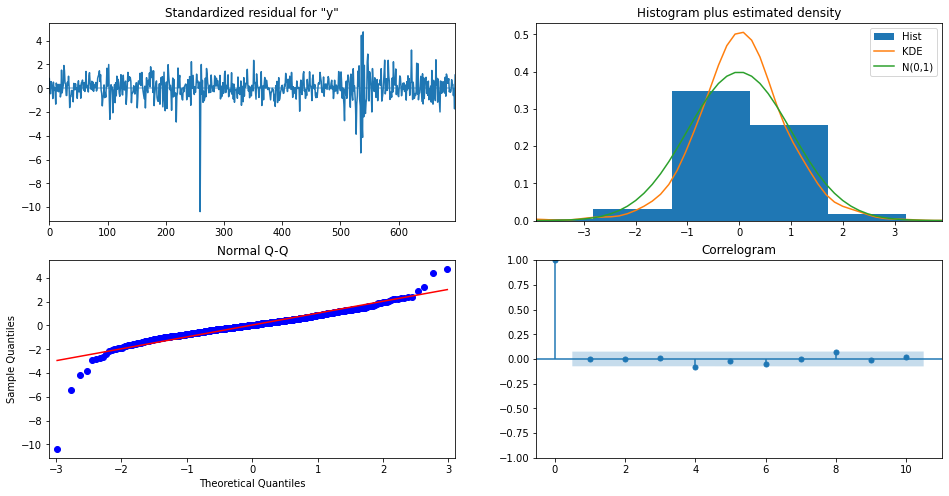

In [117]:
ordem_sazonal = (0, 0, 3, 7)
ordem = (1, 0, 3)
resultados_sarima_vale = sarima_table(df_train_vale, ordem, ordem_sazonal)

In [118]:
sarimax(df_train_ptr4, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4647.223401362056 - BIC:4660.829125175097
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:4001.382186809662 - BIC:4019.482305441036
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:3607.736872812513 - BIC:3630.3104362668755
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:2312.6172450772324 - BIC:2330.758210161287
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:2286.217299656294 - BIC:2308.842447945511
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:2260.0607698148224 - BIC:2287.1490459600577
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:2280.2851712112915 - BIC:2302.9249607994043
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:2281.35298923397 - BIC:2308.503167181031
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:2253.6421639291802 - BIC:2285.245152765288
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:2262.122267750803 - BIC:2289.228295388277
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:2260.872795292149 - BIC:2292.496494202535


  8%|▊         | 1/12 [01:09<12:46, 69.67s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:2254.808827090252 - BIC:2290.9265286172326
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:3870.001141454174 - BIC:3888.1362968059075
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:3363.482100689873 - BIC:3386.0999122206204
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:3081.2417066944413 - BIC:3108.321087359915
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:2124.3027906475227 - BIC:2146.9717348371896
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:2347.93149879923 - BIC:2375.072872636127
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:2069.771204253907 - BIC:2101.363815030293
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:2077.0488057287994 - BIC:2104.216553234535
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:2085.3709252439803 - BIC:2117.0358613870267
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:2080.938147936893 - BIC:2117.0439888241917
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:2063.723359431223 - BIC:2095.3470583416088
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:2261.401622024072 - BIC:2297.54299220737


 17%|█▋        | 2/12 [02:19<11:39, 69.97s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:2106.669795520086 - BIC:2147.288866518297
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:3597.6056127491565 - BIC:3620.2672842102684
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:3291.225053946351 - BIC:3318.357610735372
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:2726.567168393679 - BIC:2758.149385701192
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:1854.0329449627877 - BIC:1881.2269507161218
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:1833.7965759236636 - BIC:1865.4512255108546
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:1863.223074541697 - BIC:1899.317037178855
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:1824.4280051208566 - BIC:1856.1237105442144
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:1838.0806746910505 - BIC:1874.2574170764117
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:1809.5268290220965 - BIC:1850.1325369888991
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:1831.1997456867157 - BIC:1867.341115870014
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:1812.0214540748493 - BIC:1852.6804955310597


 25%|██▌       | 3/12 [03:46<11:38, 77.64s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:1811.3121066752328 - BIC:1856.4295599716802
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:1439.171906189369 - BIC:1457.3128712734238
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:1425.3371508265172 - BIC:1447.9622991157346
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:1420.6466604263762 - BIC:1447.7349365716113
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:1437.453246251329 - BIC:1460.129452606397
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:1427.1314743256803 - BIC:1454.281652272741
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:1414.8261683050855 - BIC:1446.4291571411932
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:1428.2838979468906 - BIC:1455.4428671043154
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:1429.0937947610194 - BIC:1460.7690023659236
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:1417.727805090251 - BIC:1453.8455066172312
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:1416.3260518178276 - BIC:1447.9394033501285
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:1418.4487338124475 - BIC:1454.578278420791


 33%|███▎      | 4/12 [04:22<08:10, 61.33s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:1420.9357320568952 - BIC:1461.568146274748
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:1438.364100958554 - BIC:1461.0330451482207
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:1423.7834849586495 - BIC:1450.9248587955467
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:1417.2541874427657 - BIC:1448.8467982191519
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:1436.29075992164 - BIC:1463.4934929492401
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:1425.5655339825785 - BIC:1457.230470125625
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:1412.7604431702148 - BIC:1448.8662840575132
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:1427.8197948493817 - BIC:1459.5052588663773
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:1429.95354670883 - BIC:1466.142045158026
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:1415.4698148805633 - BIC:1456.088885878774
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:1415.6214369612903 - BIC:1451.750981569634
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:1417.6383682452256 - BIC:1458.2841059296122


 42%|████▏     | 5/12 [05:05<06:22, 54.66s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:1417.973320759963 - BIC:1463.105621869086
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:1433.7536651415999 - BIC:1460.947670894934
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:1419.6528792078434 - BIC:1451.3075287950344
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:1411.867516277574 - BIC:1447.9614789147317
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:1431.2774757660618 - BIC:1463.0038158116183
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:1420.7413180680765 - BIC:1456.9180604534376
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:1408.57360539933 - BIC:1449.1793133661326
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:1424.2896955605627 - BIC:1460.501654437129
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:1425.261691630532 - BIC:1465.9605268140633
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:1412.1306588781579 - BIC:1457.2481121746052
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:1412.801542887787 - BIC:1453.4472805721737
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:1414.9449540731844 - BIC:1460.106884833614


 50%|█████     | 6/12 [05:54<05:16, 52.80s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:1414.1732923162474 - BIC:1463.8024909423393
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:1442.727636710982 - BIC:1465.4038430660503
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:1431.5338431784044 - BIC:1458.684021125465
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:1418.3445775445007 - BIC:1449.9475663806084
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:1438.9520092265343 - BIC:1466.1634568526163
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:1427.9188457695436 - BIC:1459.5940533744479
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:1415.6740308859235 - BIC:1451.7917324129037
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:1427.902621446684 - BIC:1459.5778290515882
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:1430.2829015807993 - BIC:1466.483138843547
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:1417.733478268942 - BIC:1458.3658924867948
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:1415.8012921898312 - BIC:1451.9189937168114
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:1417.7333814365384 - BIC:1458.3657956543911


 58%|█████▊    | 7/12 [06:37<04:07, 49.56s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:1420.0649584867847 - BIC:1465.21208539551
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:1438.9847950050416 - BIC:1466.1875280326417
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:1423.4604063829443 - BIC:1455.1253425259908
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:1418.9817467124367 - BIC:1455.0875875997351
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:1436.3528292869246 - BIC:1468.089351152458
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:1425.5525104666754 - BIC:1461.7410089158714
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:1412.6723009131103 - BIC:1453.2913719113212
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:1425.5091865718396 - BIC:1461.7094238345874
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:1430.3626620803398 - BIC:1471.0747228356854
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:1416.588838940405 - BIC:1461.721140049528
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:1413.426333084171 - BIC:1454.0587473020237
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:1420.380986426213 - BIC:1465.5281133349383


 67%|██████▋   | 8/12 [07:32<03:24, 51.25s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:1419.8789693908807 - BIC:1469.524500610916
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:1432.1709999347136 - BIC:1463.89733998027
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:1418.6930848919387 - BIC:1454.8698272773
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:1410.5221032412644 - BIC:1451.127811208067
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:1429.3570285242358 - BIC:1465.6157028620146
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:1418.1819321282037 - BIC:1458.880767311735
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:1405.728248668092 - BIC:1450.8457019645393
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:1420.7749817960969 - BIC:1461.500248716688
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:1422.6073273651593 - BIC:1467.828255346861
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:1408.5228496511204 - BIC:1458.1520482772123
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:1408.9406760826273 - BIC:1454.0878029913526
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:1409.7151372851931 - BIC:1459.376976884791


 75%|███████▌  | 9/12 [08:41<02:50, 56.79s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:1412.8928667511507 - BIC:1467.0338107068874
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:1443.1363104022128 - BIC:1470.3477580282947
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:1429.6253989842871 - BIC:1461.3006065891914
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:1421.8041838208464 - BIC:1457.9218853478267
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:1436.4004808682284 - BIC:1468.1370027337618
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:1431.1887786438765 - BIC:1467.3890159066243
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:1418.5336330737446 - BIC:1459.1660472915974
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:1428.948980218307 - BIC:1465.137478667503
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:1434.0700611422312 - BIC:1474.7821218975769
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:1421.881642694625 - BIC:1467.0287696033504
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:1418.7973023422662 - BIC:1459.416373340477
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:1420.439760585587 - BIC:1465.57206169471


 83%|████████▎ | 10/12 [09:38<01:53, 56.71s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:1423.7808159421006 - BIC:1473.426347162136
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:1441.9810866550138 - BIC:1473.7176085205472
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:1427.874782230942 - BIC:1464.063280680138
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:1418.266063173735 - BIC:1458.8851341719455
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:1439.321304251604 - BIC:1475.5916149550708
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:1427.6971043350393 - BIC:1468.409165090385
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:1421.0582008048414 - BIC:1466.1905019139645
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:1427.9273636211099 - BIC:1468.6394243764555
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:1435.3774721845048 - BIC:1480.6130952459998
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:1418.982704762911 - BIC:1468.6282359829463
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:1423.118320116647 - BIC:1468.2506212257701
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:1422.9334063427011 - BIC:1472.5789375627364


 92%|█████████▏| 11/12 [11:00<01:04, 64.40s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:1425.3425174852416 - BIC:1479.5012788161894
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:1437.3248292813896 - BIC:1473.5835036191684
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:1431.2041831972583 - BIC:1471.9030183807897
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:1453.675879595013 - BIC:1498.7933328914603
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:1435.8564544844016 - BIC:1476.6474631144029
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:1426.9565671027135 - BIC:1472.177495084415
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:1411.7426716884675 - BIC:1461.3718703145594
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:1426.6655363413215 - BIC:1471.9011594028166
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:1430.4100137857258 - BIC:1480.1530345655974
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:1417.9516999367147 - BIC:1472.0926438924514
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:1414.0480939723502 - BIC:1463.6936251923855
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:1415.8381979715928 - BIC:1469.9969593025405


100%|██████████| 12/12 [12:48<00:00, 64.08s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:1415.084673145367 - BIC:1473.7373624307486
--- 768.9716522693634 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:     index parameters parameters_seasonal          aic          bic
0     101  (2, 0, 3)        (1, 0, 3, 7)  1405.728249  1450.845702
16     41  (1, 0, 1)        (1, 0, 3, 7)  1414.826168  1446.429157


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1955      0.058      3.398      0.001       0.083       0.308
ar.L2          0.8043      0.059     13.652      0.000       0.689       0.920
ma.L1          0.7675      0.062     12.451      0.000       0.647       0.888
ma.L2          0.0090      0.028      0.322      0.747      -0.046       0.064
ma.L3          0.1193      0.027      4.441      0.000       0.067       0.172
ar.S.L7        0.9962      0.139      7.190      0.000       0.725       1.268
ma.S.L7       -0.8975      0.151     -5.943      0.000      -1.194      -0.602
ma.S.L14      -0.0053      0.057     -0.093      0.926      -0.117       0.106
ma.S.L21      -0.0910      0.042     -2.148      0.032      -0.174      -0.008
sigma2         0.4492      0.012     37.892      0.000       0.426       0.472
--- 13.30939269065857 segundos ---


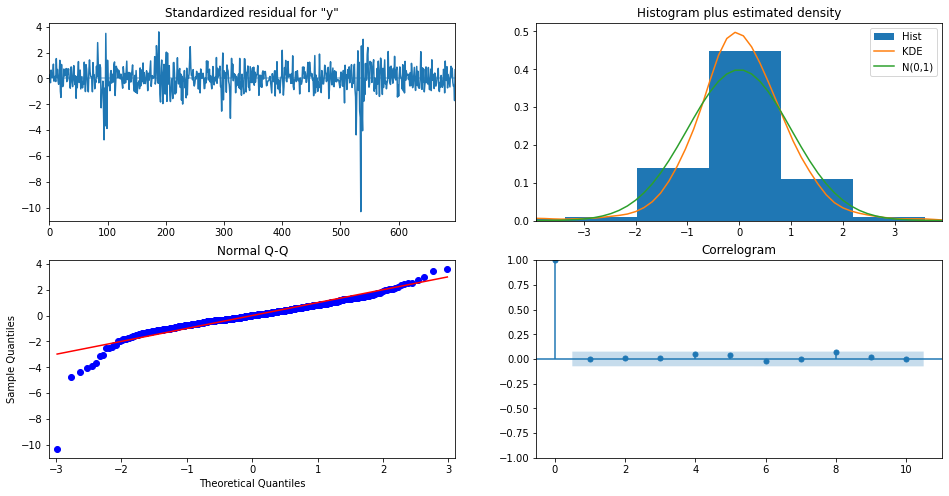

In [119]:
ordem_sazonal = (1,0,3,7)
ordem = (2,0,3)
resultados_sarima_ptr4 = sarima_table(df_train_ptr4, ordem, ordem_sazonal)

In [120]:
sarimax(df_train_ptr3, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4762.2070517798775 - BIC:4775.812775592918
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:4130.518409715251 - BIC:4148.618528346626
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:3725.1610809798794 - BIC:3747.734644434242
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:2446.2522560345765 - BIC:2464.393221118631
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:2423.496066521843 - BIC:2446.1212148110603
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:2394.438806616339 - BIC:2421.5270827615745
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:2416.961192925907 - BIC:2439.60098251402
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:2412.5002310311693 - BIC:2439.65040897823
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:2431.346188804854 - BIC:2462.949177640962
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:2398.0856944983107 - BIC:2425.1917221357844
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:2398.5179876826846 - BIC:2430.1416865930705


  8%|▊         | 1/12 [00:54<09:54, 54.02s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:2390.3603990621154 - BIC:2426.478100589096
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:3987.840071203163 - BIC:4005.9752265548964
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:3783.6917411293207 - BIC:3806.309552660068
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:3186.098263419195 - BIC:3213.177644084669
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:2225.8970624790445 - BIC:2248.5660066687115
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:2203.4940485885454 - BIC:2230.6354224254424
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:2177.173593345972 - BIC:2208.7662041223584
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:2285.2827963100717 - BIC:2312.450543815807
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:2225.410144567347 - BIC:2257.075080710393
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:2212.9426136685347 - BIC:2249.0484545558334
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:2187.8158553924513 - BIC:2219.439554302837
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:2208.4422797808993 - BIC:2244.5836499641973


 17%|█▋        | 2/12 [02:03<10:32, 63.26s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:2179.4234587553974 - BIC:2220.042529753608
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:3712.46170651377 - BIC:3735.123377974882
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:3171.682807467485 - BIC:3198.8153642565057
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:3436.33157496045 - BIC:3467.913792267963
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:1970.0462705991818 - BIC:1997.2402763525158
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:1946.7931002237015 - BIC:1978.4477498108924
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:1915.0080359262956 - BIC:1951.1019985634534
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:1951.9282775768502 - BIC:1983.623983000208
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:1950.2676687309145 - BIC:1986.4444111162757
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:1960.584180834813 - BIC:2001.1898888016156
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:1927.17718063219 - BIC:1963.3185508154882
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:1920.643172956976 - BIC:1961.3022144131864


 25%|██▌       | 3/12 [03:21<10:29, 69.90s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:1938.7922296803129 - BIC:1983.9096829767602
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:1551.046572210208 - BIC:1569.1875372942627
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:1530.4421553480338 - BIC:1553.0673036372511
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:1518.2173581796822 - BIC:1545.3056343249173
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:1546.9255775861038 - BIC:1569.601783941172
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:1532.407806532629 - BIC:1559.5579844796896
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:1518.9469059671483 - BIC:1550.549894803256
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:1533.9691385231686 - BIC:1561.1281076805933
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:1535.0158842793908 - BIC:1566.691091884295
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:1521.5184297573765 - BIC:1557.6361312843567
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:1520.3938393356366 - BIC:1552.0071908679374
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:1522.4416485744682 - BIC:1558.5711931828118


 33%|███▎      | 4/12 [03:57<07:31, 56.42s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:1523.8187229634818 - BIC:1564.4511371813346
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:1548.0918757317013 - BIC:1570.760819921368
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:1525.8408097353959 - BIC:1552.982183572293
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:1516.9388935326692 - BIC:1548.5315043090554
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:1543.2399618299091 - BIC:1570.4426948575092
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:1527.7102596509246 - BIC:1559.3751957939712
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:1514.4252200871697 - BIC:1550.5310609744681
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:1530.7172874883618 - BIC:1562.4027515053574
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:1531.0911936969783 - BIC:1567.2796921461743
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:1516.3179009623 - BIC:1556.9369719605106
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:1516.7165169175018 - BIC:1552.8460615258455
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:1519.0747367058307 - BIC:1559.7204743902173


 42%|████▏     | 5/12 [04:35<05:48, 49.85s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:1519.1044299912492 - BIC:1564.2367311003723
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:1540.8311102687012 - BIC:1568.0251160220353
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:1517.9006733684614 - BIC:1549.5553229556524
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:1509.2265219611334 - BIC:1545.3204845982912
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:1534.9706450179283 - BIC:1566.6969850634848
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:1519.7668973721222 - BIC:1555.9436397574834
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:1506.8475656183637 - BIC:1547.4532735851662
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:1523.8437516538138 - BIC:1560.05571053038
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:1521.7003724447377 - BIC:1562.399207628269
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:1508.4943212123185 - BIC:1553.6117745087658
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:1511.1848926473708 - BIC:1551.8306303317574
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:1513.3118299726655 - BIC:1558.473760733095


 50%|█████     | 6/12 [05:21<04:51, 48.57s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:1512.3246162687076 - BIC:1561.9538148947995
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:1553.5530105601367 - BIC:1576.229216915205
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:1532.6706256826901 - BIC:1559.8208036297508
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:1523.6437585413837 - BIC:1555.2467473774914
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:1547.4564935370793 - BIC:1574.6679411631612
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:1534.9994179179314 - BIC:1566.6746255228356
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:1521.947159620698 - BIC:1558.0648611476781
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:1535.739440702555 - BIC:1567.4146483074592
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:1535.7818540395328 - BIC:1571.9820913022807
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:1524.4314638163642 - BIC:1565.063878034217
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:1522.0680773109134 - BIC:1558.1857788378936
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:1523.9804880525285 - BIC:1564.6129022703813


 58%|█████▊    | 7/12 [06:18<04:17, 51.45s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:1526.9918418634425 - BIC:1572.1389687721678
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:1545.4825796441369 - BIC:1572.685312671737
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:1523.4290019928565 - BIC:1555.093938135903
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:1519.103798755875 - BIC:1555.2096396431734
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:1540.4919220228562 - BIC:1572.2284438883896
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:1524.5172729109522 - BIC:1560.7057713601482
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:1512.379830964761 - BIC:1552.9989019629716
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:1525.827156132706 - BIC:1562.0273933954538
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:1528.0950324835999 - BIC:1568.8070932389455
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:1513.7611932859445 - BIC:1558.8934943950676
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:1512.3912966217758 - BIC:1553.0237108396286
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:1517.184230953612 - BIC:1562.3313578623374


 67%|██████▋   | 8/12 [07:19<03:37, 54.35s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:1516.7400051123602 - BIC:1566.3855363323955
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:1540.8573125420503 - BIC:1572.5836525876068
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:1518.1227016392713 - BIC:1554.2994440246325
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:1505.3001458321705 - BIC:1545.905853798973
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:1535.509749584562 - BIC:1571.7684239223408
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:1518.68104929704 - BIC:1559.3798844805715
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:1506.1513953767649 - BIC:1551.2688486732122
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:1521.661051227603 - BIC:1562.386318148194
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:1523.3458863972337 - BIC:1568.5668143789353
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:1509.6612476032506 - BIC:1559.2904462293425
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:1511.3215887745578 - BIC:1556.468715683283
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:1513.268473904047 - BIC:1562.9303135036448


 75%|███████▌  | 9/12 [08:14<02:43, 54.42s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:1512.7246171503161 - BIC:1566.8655611060528
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:1553.3935928519425 - BIC:1580.6050404780244
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:1531.673827970058 - BIC:1563.3490355749623
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:1529.1671002730995 - BIC:1565.2848018000798
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:1542.0630464284031 - BIC:1573.7995682939365
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:1534.1092664949692 - BIC:1570.309503757717
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:1519.8068666150857 - BIC:1560.4392808329385
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:1532.2756238507245 - BIC:1568.4641222999205
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:1537.068502677413 - BIC:1577.7805634327588
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:1524.5335390214536 - BIC:1569.680665930179
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:1520.486142133373 - BIC:1561.1052131315837
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:1523.887036597732 - BIC:1569.0193377068551


 83%|████████▎ | 10/12 [08:59<01:43, 51.54s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:1525.690922195552 - BIC:1575.3364534155874
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:1549.2442870315358 - BIC:1580.9808088970692
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:1525.2223559820886 - BIC:1561.4108544312846
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:1519.0077308038758 - BIC:1559.6268018020864
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:1544.0356529447106 - BIC:1580.3059636481773
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:1528.321434834803 - BIC:1569.0334955901487
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:1518.1603386295897 - BIC:1563.2926397387128
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:1532.759827126015 - BIC:1573.4718878813605
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:1531.864499846356 - BIC:1577.100122907851
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:1517.0301503602616 - BIC:1566.675681580297
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:1516.5767297757316 - BIC:1561.7090308848547
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:1519.433661539133 - BIC:1569.0791927591683


 92%|█████████▏| 11/12 [09:57<00:53, 53.76s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:1519.8889004948467 - BIC:1574.0476618257944
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:1546.215880154142 - BIC:1582.4745544919208
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:1527.951446122431 - BIC:1568.6502813059624
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:1515.3733111341164 - BIC:1560.4907644305638
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:1535.6379874434147 - BIC:1576.4289960734159
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:1536.2394597015887 - BIC:1581.4603876832903
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:1507.7381403415702 - BIC:1557.3673389676621
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:1549.272790306359 - BIC:1594.508413367854
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:1535.2273831224647 - BIC:1584.9704039023363
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:1511.879227244066 - BIC:1566.0201711998027
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:1513.7113740337675 - BIC:1563.3569052538028
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:1518.9571895545287 - BIC:1573.1159508854764


100%|██████████| 12/12 [11:19<00:00, 56.61s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:1517.6445438751107 - BIC:1576.2972331604922
--- 679.2945454120636 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:     index parameters parameters_seasonal          aic          bic
0      98  (2, 0, 3)        (0, 0, 3, 7)  1505.300146  1545.905854
31     38  (1, 0, 1)        (0, 0, 3, 7)  1518.217358  1545.305634


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1808      0.068      2.658      0.008       0.048       0.314
ar.L2          0.8190      0.068     12.046      0.000       0.686       0.952
ma.L1          0.7912      0.071     11.083      0.000       0.651       0.931
ma.L2          0.0437      0.031      1.431      0.152      -0.016       0.104
ma.L3          0.1446      0.027      5.448      0.000       0.093       0.197
ma.S.L7        0.3723      1.951      0.191      0.849      -3.452       4.196
ma.S.L14       6.9184      2.013      3.436      0.001       2.972      10.864
ma.S.L21       0.3189      2.301      0.139      0.890      -4.190       4.828
sigma2         0.0110      0.006      1.716      0.086      -0.002       0.024
--- 4.727950811386108 segundos ---


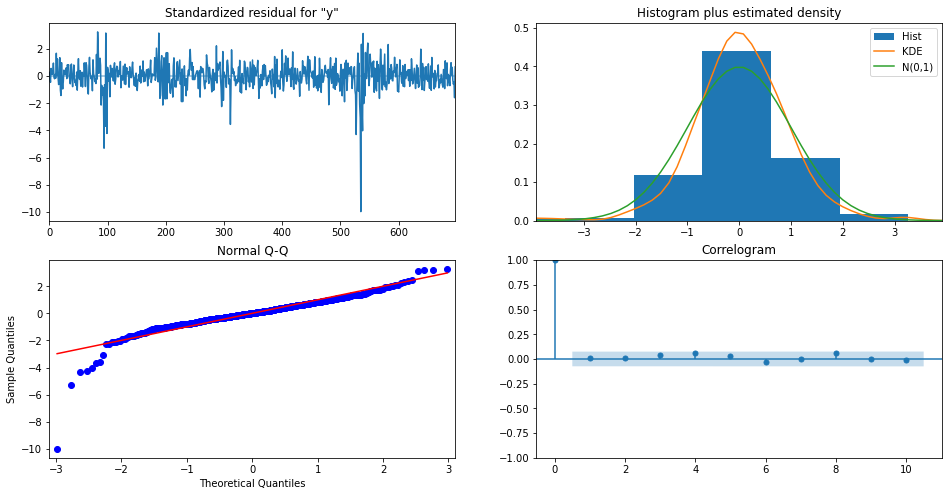

In [121]:
ordem_sazonal = (0,0,3,7)
ordem = (2,0,3)
resultados_sarima_ptr3 = sarima_table(df_train_ptr3, ordem, ordem_sazonal)

In [122]:
sarimax(df_train_itub4, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:5028.013271285039 - BIC:5041.61899509808
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:4313.698764858309 - BIC:4331.798883489683
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:3834.8872081128916 - BIC:3857.460771567254
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:2068.371058141936 - BIC:2086.5120232259906
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:2031.5674477874256 - BIC:2054.192596076643
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:1999.266066747001 - BIC:2026.3543428922362
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:2047.5731907808615 - BIC:2070.212980368974
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:2035.608202303634 - BIC:2062.7583802506947
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:2012.3601597815623 - BIC:2043.96314861767
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:2008.3186443442974 - BIC:2035.424671981771
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:2011.0852221809487 - BIC:2042.7089210913346


  8%|▊         | 1/12 [00:42<07:50, 42.81s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:2021.0654195628424 - BIC:2057.1831210898226
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:4177.419754764643 - BIC:4195.554910116376
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:3570.2387453863375 - BIC:3592.856556917085
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:3198.1762361746887 - BIC:3225.2556168401625
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:1907.289643217227 - BIC:1929.9585874068937
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:1829.5709463096014 - BIC:1856.7123201464985
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:1838.4980183154848 - BIC:1870.090629091871
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:1854.814083444825 - BIC:1881.9818309505604
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:1916.4047340544862 - BIC:1948.0696701975328
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:1814.0987502464748 - BIC:1850.2045911337732
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:1818.7669460494149 - BIC:1850.3906449598007
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:1819.8867518905495 - BIC:1856.0281220738477


 17%|█▋        | 2/12 [01:49<09:27, 56.75s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:1816.1739688318517 - BIC:1856.7930398300623
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:3811.5566394520483 - BIC:3834.21831091316
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:3434.3074344908164 - BIC:3461.439991279837
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:2903.530271226704 - BIC:2935.112488534217
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:1754.3746936216676 - BIC:1781.5686993750016
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:1666.8138940012773 - BIC:1698.4685435884683
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:1648.2223404167885 - BIC:1684.3163030539463
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:1783.324950905476 - BIC:1815.0206563288339
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:1890.975099268234 - BIC:1927.1518416535953
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:1663.794452268792 - BIC:1704.4001602355945
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:1674.395270729944 - BIC:1710.5366409132423
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:2037.6042976357066 - BIC:2078.2633390919173


 25%|██▌       | 3/12 [03:17<10:40, 71.13s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:1655.3439959151233 - BIC:1700.4614492115707
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:1359.1545013855393 - BIC:1377.295466469594
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:1348.0756805500982 - BIC:1370.7008288393156
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:1332.6508433779895 - BIC:1359.7391195232246
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:1358.5561430192906 - BIC:1381.2323493743588
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:1339.9633093718662 - BIC:1367.113487318927
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:1327.1941089500328 - BIC:1358.7970977861405
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:1342.4671677724336 - BIC:1369.6261369298584
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:1340.6071625427398 - BIC:1372.282370147644
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:1328.4099352862813 - BIC:1364.5276368132616
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:1328.2189443208422 - BIC:1359.832295853143
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:1328.3688060208303 - BIC:1364.498350629174


 33%|███▎      | 4/12 [03:54<07:40, 57.51s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:1329.5364826797777 - BIC:1370.1688968976305
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:1359.7601633480144 - BIC:1382.4291075376811
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:1350.269779211172 - BIC:1377.411153048069
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:1336.0746367007841 - BIC:1367.6672474771703
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:1359.0553604576298 - BIC:1386.25809348523
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:1340.2612412404305 - BIC:1371.9261773834771
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:1327.8073658775536 - BIC:1363.913206764852
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:1343.739638913601 - BIC:1375.4251029305967
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:1341.047993127965 - BIC:1377.236491577161
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:1329.0177597523073 - BIC:1369.6368307505181
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:1330.1645935169445 - BIC:1366.294138125288
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:1330.0000660431988 - BIC:1370.6458037275854


 42%|████▏     | 5/12 [04:34<05:59, 51.39s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:1330.867624312313 - BIC:1375.999925421436
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:1358.1840132703408 - BIC:1385.3780190236748
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:1347.6494527073366 - BIC:1379.3041022945276
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:1335.208350680398 - BIC:1371.302313317556
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:1357.5729184896634 - BIC:1389.29925853522
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:1339.9240933288152 - BIC:1376.1008357141764
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:1327.503613954289 - BIC:1368.1093219210916
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:1344.6073489459422 - BIC:1380.8193078225086
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:1340.4593194782826 - BIC:1381.158154661814
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:1328.6506781391704 - BIC:1373.7681314356178
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:1332.3577510194452 - BIC:1373.0034887038319
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:1331.0414647322887 - BIC:1376.2033954927183


 50%|█████     | 6/12 [05:27<05:11, 51.88s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:1346.9888314811826 - BIC:1396.6180301072745
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:1361.1247828089176 - BIC:1383.8009891639858
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:1342.1402061219276 - BIC:1369.2903840689883
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:1336.8055057070874 - BIC:1368.408494543195
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:1385.3338562510814 - BIC:1412.5453038771634
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:1366.5647696214248 - BIC:1398.239977226329
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:1347.9509090317579 - BIC:1384.068610558738
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:1341.7260448672876 - BIC:1373.4012524721918
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:1342.3754427860956 - BIC:1378.5756800488434
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:1349.9247807659165 - BIC:1390.5571949837693
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:1328.9610701053912 - BIC:1365.0787716323714
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:1333.0254550021464 - BIC:1373.6578692199992


 58%|█████▊    | 7/12 [06:25<04:29, 53.84s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:1350.303821986081 - BIC:1395.4509488948063
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:1357.1254382742695 - BIC:1384.3281713018696
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:1366.026786796095 - BIC:1397.6917229391415
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:1339.6724571428952 - BIC:1375.7782980301936
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:1360.2636063242537 - BIC:1392.0001281897871
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:1342.461395568547 - BIC:1378.649894017743
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:1331.5132469842115 - BIC:1372.1323179824221
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:1347.8032923372334 - BIC:1384.0035295999812
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:1352.9942277857015 - BIC:1393.7062885410471
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:1335.0002777688856 - BIC:1380.1325788780086
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:1331.2653781331019 - BIC:1371.8977923509547
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:1340.4611722498757 - BIC:1385.608299158601


 67%|██████▋   | 8/12 [07:18<03:34, 53.64s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:1333.8231486789753 - BIC:1383.4686798990106
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:1357.4923651064707 - BIC:1389.2187051520273
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:1349.410212809124 - BIC:1385.5869551944852
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:1337.265329293581 - BIC:1377.8710372603837
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:1356.5081907021286 - BIC:1392.7668650399073
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:1342.0317787769195 - BIC:1382.730613960451
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:1328.858637900852 - BIC:1373.9760911972994
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:1346.0849709862473 - BIC:1386.8102379068384
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:1343.4829422375751 - BIC:1388.7038702192767
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:1330.3054863311097 - BIC:1379.9346849572016
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:1333.0898600035134 - BIC:1378.2369869122388
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:1335.4960527550986 - BIC:1385.1578923546965


 75%|███████▌  | 9/12 [08:16<02:44, 54.98s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:1345.6430331338931 - BIC:1399.7839770896298
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:1363.2271701115692 - BIC:1390.4386177376512
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:1355.8349304083904 - BIC:1387.5101380132946
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:1341.389843379217 - BIC:1377.5075449061972
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:1361.7143039279683 - BIC:1393.4508257935017
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:1344.5587431697793 - BIC:1380.758980432527
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:1331.5469372694029 - BIC:1372.1793514872556
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:1342.5331919323407 - BIC:1378.7216903815367
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:1368.9074794454407 - BIC:1409.6195402007863
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:1351.8736888889516 - BIC:1397.020815797677
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:1330.1185590235086 - BIC:1370.7376300217193
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:1330.407162190299 - BIC:1375.539463299422


 83%|████████▎ | 10/12 [09:13<01:51, 55.68s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:1333.3620753633265 - BIC:1383.0076065833618
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:1365.0038324212019 - BIC:1396.7403542867353
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:1344.7837773529056 - BIC:1380.9722758021016
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:1339.1242791592938 - BIC:1379.7433501575047
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:1366.0758333419856 - BIC:1402.3461440454523
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:1350.0986890234362 - BIC:1390.8107497787819
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:1333.7191240577472 - BIC:1378.8514251668703
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:1349.4766830390922 - BIC:1390.1887437944379
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:1352.7328068382808 - BIC:1397.9684298997759
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:1336.830839422245 - BIC:1386.4763706422802
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:1334.4160067076514 - BIC:1379.5483078167745
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:1344.3050640594063 - BIC:1393.9505952794416


 92%|█████████▏| 11/12 [10:11<00:56, 56.26s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:1346.4003073956396 - BIC:1400.5590687265874
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:1511.867086859616 - BIC:1548.1257611973947
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:1452.5940323182103 - BIC:1493.2928675017417
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:1520.8656561622915 - BIC:1565.983109458739
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:1363.634222914097 - BIC:1404.4252315440983
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:1348.934373065849 - BIC:1394.1553010475507
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:1377.2658175146466 - BIC:1426.8950161407386
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:2179.0668990687536 - BIC:2224.3025221302487
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:1356.540026177242 - BIC:1406.2830469571136
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:1359.2659459283682 - BIC:1413.4068898841049
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:2199.3077982952523 - BIC:2248.953329515288
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:2126.050315186464 - BIC:2180.2090765174116


100%|██████████| 12/12 [11:43<00:00, 58.60s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:2015.4228740285387 - BIC:2074.07556331392
--- 703.1770806312561 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:    index parameters parameters_seasonal          aic          bic
0     41  (1, 0, 1)        (1, 0, 3, 7)  1327.194109  1358.797098


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001    742.040      0.000       0.997       1.002
ma.L1         -0.0303      0.028     -1.082      0.279      -0.085       0.025
ar.S.L7        0.9958      0.036     27.603      0.000       0.925       1.067
ma.S.L7       -0.8554      0.055    -15.419      0.000      -0.964      -0.747
ma.S.L14      -0.1198      0.049     -2.459      0.014      -0.215      -0.024
ma.S.L21      -0.0138      0.036     -0.382      0.702      -0.084       0.057
sigma2         0.4096      0.020     20.815      0.000       0.371       0.448
--- 3.6719648838043213 segundos ---


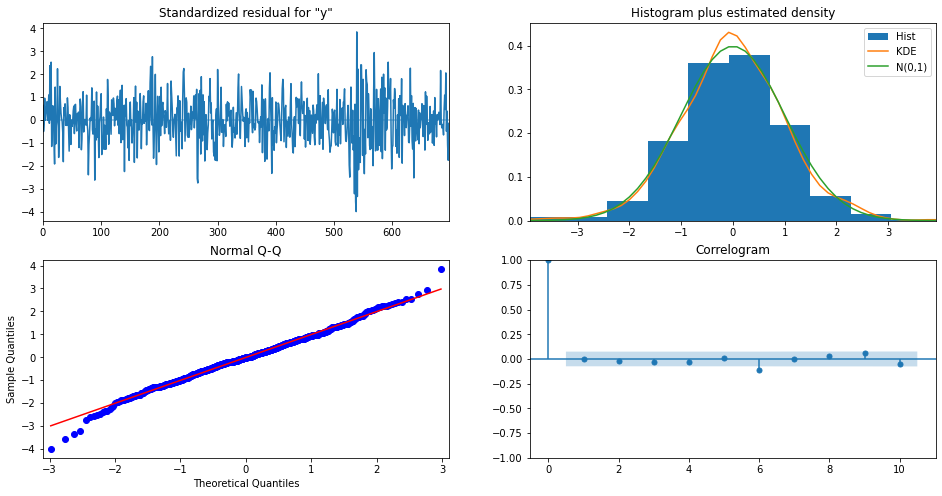

In [123]:
ordem_sazonal = (1,0,3,7)
ordem = (1,0,1)
resultados_sarima_itub4 = sarima_table(df_train_itub4, ordem, ordem_sazonal)

In [124]:
sarimax(df_train_bbdc4, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4557.453511715596 - BIC:4571.059235528636
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:3883.478327861837 - BIC:3901.578446493211
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:3402.641364910019 - BIC:3425.2149283643816
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:1758.9214210767104 - BIC:1777.062386160765
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:1736.3537147385064 - BIC:1758.9788630277237
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:1721.5620699505496 - BIC:1748.6503460957847
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:1745.049080211905 - BIC:1767.6888698000178
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:1738.679544205103 - BIC:1765.8297221521636
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:1716.7737799091879 - BIC:1748.3767687452955
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:1719.8070644196264 - BIC:1746.9130920571001
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:1719.5494069518195 - BIC:1751.1731058622054


  8%|▊         | 1/12 [00:43<08:01, 43.80s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:1732.7008190618967 - BIC:1768.818520588877
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:3730.3735340317476 - BIC:3748.508689383481
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:3529.9377447533384 - BIC:3552.555556284086
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:2819.7394624131903 - BIC:2846.818843078664
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:1535.3922814809875 - BIC:1558.0612256706543
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:1547.0097368190457 - BIC:1574.1511106559428
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:1507.0166127780603 - BIC:1538.6092235544465
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:1808.3296087486829 - BIC:1835.4973562544183
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:1523.4200326504586 - BIC:1555.0849687935051
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:1769.6105307476705 - BIC:1805.716371634969
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:1509.2709430591312 - BIC:1540.8946419695171
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:1511.1806160371075 - BIC:1547.3219862204057


 17%|█▋        | 2/12 [01:35<08:03, 48.30s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:1512.0598721151391 - BIC:1552.6789431133498
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:3394.2593781274527 - BIC:3416.9210495885645
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:3074.9020219378663 - BIC:3102.034578726887
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:2490.330797658867 - BIC:2521.91301496638
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:1571.668084096345 - BIC:1598.862089849679
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:1342.5436504428285 - BIC:1374.1983000300195
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:1328.3247036585844 - BIC:1364.4186662957422
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:1432.8631373775036 - BIC:1464.5588428008614
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:1342.9251298791678 - BIC:1379.101872264529
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:1328.0351179639556 - BIC:1368.6408259307582
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:1559.0700237403385 - BIC:1595.2113939236367
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:1546.1218905991948 - BIC:1586.7809320554052


 25%|██▌       | 3/12 [02:45<08:46, 58.47s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:1641.5483294049536 - BIC:1686.665782701401
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:1011.8542313984642 - BIC:1029.9951964825188
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:1008.9381959407399 - BIC:1031.5633442299572
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:994.4124220094124 - BIC:1021.5006981546476
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:1013.0189382121698 - BIC:1035.695144567238
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:1002.0323004268506 - BIC:1029.1824783739114
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:993.2179280577757 - BIC:1024.8209168938833
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:1003.3036848830983 - BIC:1030.4626540405231
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:1004.5213833061084 - BIC:1036.1965909110127
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:999.8801303839916 - BIC:1035.9978319109719
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:995.0536679877116 - BIC:1026.6670195200124
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:999.498801411439 - BIC:1035.6283460197826


 33%|███▎      | 4/12 [03:22<06:39, 49.96s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:1004.0966409642983 - BIC:1044.7290551821511
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:1012.8724561967897 - BIC:1035.5414003864564
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:1007.1729567449992 - BIC:1034.3143305818962
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:1003.8016429858606 - BIC:1035.3942537622468
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:1013.9439420705811 - BIC:1041.1466750981813
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:1002.8747943277422 - BIC:1034.5397304707888
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:994.2593368866949 - BIC:1030.3651777739933
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:1005.0833498025638 - BIC:1036.7688138195595
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:1004.8980162309759 - BIC:1041.086514680172
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:995.5826195734479 - BIC:1036.2016905716587
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:996.7967153455178 - BIC:1032.9262599538615
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:1003.4507893600705 - BIC:1044.0965270444572


 42%|████▏     | 5/12 [04:06<05:33, 47.69s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:1004.6586205678886 - BIC:1049.7909216770117
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:1012.6716004229124 - BIC:1039.8656061762465
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:1020.511283024168 - BIC:1052.165932611359
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:1006.8151060587347 - BIC:1042.9090686958925
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:1013.4463817824546 - BIC:1045.1727218280112
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:1002.5097295245266 - BIC:1038.6864719098878
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:995.5509921681357 - BIC:1036.1567001349383
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:1005.5023940159526 - BIC:1041.714352892519
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:1007.7735144587216 - BIC:1048.472349642253
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:998.3799199330971 - BIC:1043.4973732295443
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:999.1939572212509 - BIC:1039.8396949056375
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:1001.7621657934982 - BIC:1046.924096553928


 50%|█████     | 6/12 [04:56<04:50, 48.45s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:1000.2299809810513 - BIC:1049.8591796071432
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:1013.2465487089696 - BIC:1035.9227550640378
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:1004.6174566852834 - BIC:1031.7676346323442
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:998.5281654801886 - BIC:1030.1311543162963
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:1014.4206499327986 - BIC:1041.6320975588806
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:1003.7941255648766 - BIC:1035.4693331697808
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:995.1769732504376 - BIC:1031.2946747774179
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:1003.60961095575 - BIC:1035.2848185606542
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:1005.6372257073978 - BIC:1041.8374629701455
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:996.5903111028861 - BIC:1037.2227253207388
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:995.6740235026372 - BIC:1031.7917250296175
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:1002.169577948106 - BIC:1042.8019921659588


 58%|█████▊    | 7/12 [05:36<03:49, 45.84s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:1006.0052528197655 - BIC:1051.1523797284908
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:1014.6594776053273 - BIC:1041.8622106329274
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:1030.2848071793992 - BIC:1061.9497433224458
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:1004.3927313143411 - BIC:1040.4985722016395
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:1015.7468276909557 - BIC:1047.483349556489
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:1005.4483220214956 - BIC:1041.6368204706916
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:999.4962031738752 - BIC:1040.115274172086
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:1005.4212127593288 - BIC:1041.6214500220765
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:1009.240561550653 - BIC:1049.9526223059986
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:1005.293391145548 - BIC:1050.425692254671
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:998.1808231945884 - BIC:1038.8132374124411
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:1004.543607319885 - BIC:1049.6907342286104


 67%|██████▋   | 8/12 [06:28<03:10, 47.72s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:1005.7249544700832 - BIC:1055.3704856901186
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:1027.4098085412404 - BIC:1059.136148586797
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:1025.5986972256374 - BIC:1061.7754396109985
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:1015.3757784671482 - BIC:1055.9814864339507
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:1016.1377896658239 - BIC:1052.3964640036027
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:1010.8488339729191 - BIC:1051.5476691564504
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:998.5241971834755 - BIC:1043.6416504799229
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:1012.1667454252429 - BIC:1052.892012345834
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:1013.5810000309856 - BIC:1058.801928012687
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:1003.5515657859781 - BIC:1053.1807644120702
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:1006.4547224408329 - BIC:1051.6018493495583
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:1004.4322208720138 - BIC:1054.0940604716116


 75%|███████▌  | 9/12 [07:22<02:29, 49.71s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:1005.6824644537953 - BIC:1059.823408409532
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:1015.1553528251401 - BIC:1042.366800451222
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:1022.4181857116325 - BIC:1054.0933933165368
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:1005.2795156099354 - BIC:1041.3972171369157
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:1015.8388899916138 - BIC:1047.5754118571472
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:1005.5882238886867 - BIC:1041.7884611514344
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:997.2216448884177 - BIC:1037.8540591062704
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:1005.0333458713651 - BIC:1041.221844320561
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:1009.5309046301126 - BIC:1050.242965385458
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:1002.0100143567851 - BIC:1047.1571412655103
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:996.5861009562226 - BIC:1037.2051719544334
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:1003.8942452358115 - BIC:1049.0265463449346


 83%|████████▎ | 10/12 [08:17<01:42, 51.38s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:1003.0235531033288 - BIC:1052.6690843233641
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:1015.1102563104608 - BIC:1046.8467781759941
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:1024.5268410748113 - BIC:1060.7153395240073
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:1005.8675696255979 - BIC:1046.4866406238086
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:1013.6816650806853 - BIC:1049.9519757841522
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:1004.1368145934737 - BIC:1044.8488753488193
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:996.580180921912 - BIC:1041.712482031035
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:1003.9155363646032 - BIC:1044.6275971199489
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:1008.4826965062058 - BIC:1053.718319567701
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:1001.9320641589713 - BIC:1051.5775953790067
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:997.3083439055931 - BIC:1042.4406450147162
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:999.7120582755012 - BIC:1049.3575894955366


 92%|█████████▏| 11/12 [09:06<00:50, 50.54s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:1004.3591939159351 - BIC:1058.5179552468828
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:1036.5316841720246 - BIC:1072.7903585098034
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:1019.4304997597187 - BIC:1060.1293349432501
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:1013.7013336619219 - BIC:1058.8187869583692
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:1024.3222149774697 - BIC:1065.1132236074707
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:1015.7338761297723 - BIC:1060.9548041114738
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:1006.6792639344433 - BIC:1056.3084625605352
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:1014.6477614007584 - BIC:1059.8833844622536
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:1014.7886371852949 - BIC:1064.5316579651665
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:1009.4563975116198 - BIC:1063.5973414673565
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:1009.8365271091143 - BIC:1059.4820583291496
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:1011.1139863048069 - BIC:1065.2727476357545


100%|██████████| 12/12 [10:12<00:00, 51.04s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:1013.3119267286651 - BIC:1071.9646160140464
--- 612.5068926811218 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:    index parameters parameters_seasonal         aic          bic
0     41  (1, 0, 1)        (1, 0, 3, 7)  993.217928  1024.820917
2     38  (1, 0, 1)        (0, 0, 3, 7)  994.412422  1021.500698


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.002    608.256      0.000       0.996       1.003
ma.L1         -0.0614      0.025     -2.504      0.012      -0.109      -0.013
ar.S.L7        0.9967      0.059     16.779      0.000       0.880       1.113
ma.S.L7       -0.8612      0.072    -11.982      0.000      -1.002      -0.720
ma.S.L14      -0.1243      0.048     -2.586      0.010      -0.218      -0.030
ma.S.L21      -0.0074      0.035     -0.211      0.833      -0.076       0.062
sigma2         0.2483      0.009     26.530      0.000       0.230       0.267
--- 4.83538556098938 segundos ---


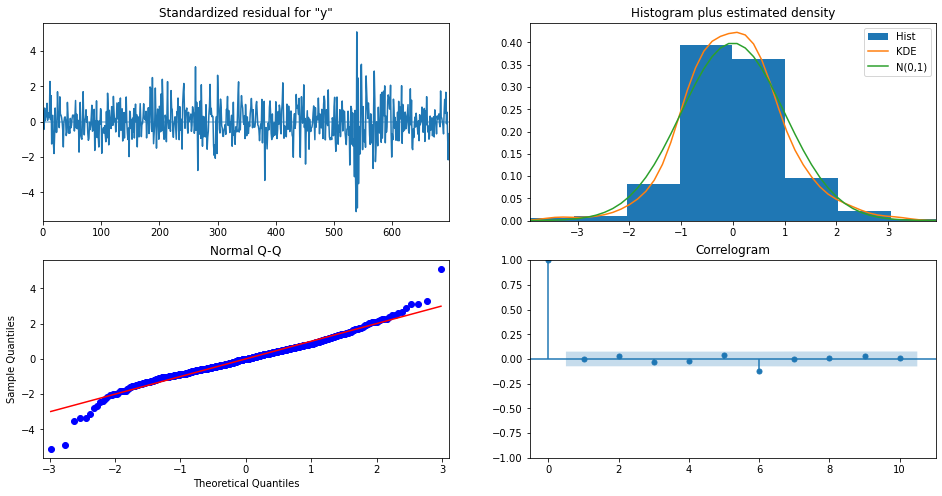

In [125]:
ordem_sazonal = (1,0,3,7)
ordem = (1,0,1)
resultados_sarima_bbdc4 = sarima_table(df_train_bbdc4, ordem, ordem_sazonal)

In [126]:
sarimax(df_train_abev3, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:4208.578294431727 - BIC:4222.184018244768
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:3620.1337284127794 - BIC:3638.233847044153
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:3033.9984930201917 - BIC:3056.5720564745543
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:1200.244723034042 - BIC:1218.3856881180966
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:1199.2492903950556 - BIC:1221.874438684273
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:1181.5728029943123 - BIC:1208.6610791395474
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:1192.991411470271 - BIC:1215.6312010583838
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:1192.7422842259994 - BIC:1219.89246217306
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:1183.3182892798582 - BIC:1214.9212781159658
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:1184.2132512536064 - BIC:1211.31927889108
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:1185.2333451260256 - BIC:1216.8570440364115


  8%|▊         | 1/12 [00:41<07:39, 41.81s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:1185.8232350530593 - BIC:1221.9409365800395
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:3363.51746869828 - BIC:3381.6526240500134
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:3242.7634792595454 - BIC:3265.381290790293
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:2725.8330629446737 - BIC:2752.9124436101474
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:1458.7572634356484 - BIC:1481.426207625315
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:955.7771263199152 - BIC:982.9185001568122
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:953.755630761765 - BIC:985.3482415381511
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:960.685271415759 - BIC:987.8530189214943
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:957.7776547878191 - BIC:989.4425909308657
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:955.3950835487768 - BIC:991.5009244360753
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:957.3761218829106 - BIC:988.9998207932965
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:956.6699307453883 - BIC:992.8113009286866


 17%|█▋        | 2/12 [01:37<08:16, 49.70s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:957.6331366455604 - BIC:998.2522076437712
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:3005.7157006571942 - BIC:3028.377372118306
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:2710.447070006964 - BIC:2737.579626795985
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:2090.4499234525797 - BIC:2122.0321407600927
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:780.0360812481472 - BIC:807.2300870014813
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:779.0154947584429 - BIC:810.670144345634
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:800.4490579185845 - BIC:836.5430205557423
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:781.1421294441808 - BIC:812.8378348675386
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:780.5419819861461 - BIC:816.7187243715073
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:779.93591550174 - BIC:820.5416234685426
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:778.4737056282044 - BIC:814.6150758115026
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:781.8324809838386 - BIC:822.4915224400492


 25%|██▌       | 3/12 [02:46<08:49, 58.82s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:786.4216868961628 - BIC:831.53914019261
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:395.7434813950589 - BIC:413.88444647911354
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:399.40457077716485 - BIC:422.02971906638214
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:408.24933777647783 - BIC:435.337613921713
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:397.5608135624499 - BIC:420.2370199175182
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:400.475032608908 - BIC:427.6252105559688
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:402.2256306951409 - BIC:433.82861953124865
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:400.2668342667563 - BIC:427.425803424181
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:402.5003538879633 - BIC:434.17556149286753
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:405.67571479648984 - BIC:441.79341632347007
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:402.311758378597 - BIC:433.92510991089773
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:403.3886591464869 - BIC:439.5182037548306


 33%|███▎      | 4/12 [03:24<06:44, 50.60s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:405.7854777959602 - BIC:446.417892013813
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:394.7513812085395 - BIC:417.4203253982062
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:408.5850286822481 - BIC:435.72640251914515
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:406.8525139625766 - BIC:438.44512473896276
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:396.6178382131503 - BIC:423.8205712407504
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:400.03748192449916 - BIC:431.70241806754575
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:401.4340925293187 - BIC:437.53993341661715
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:399.3967397147072 - BIC:431.08220373170275
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:401.9212970586645 - BIC:438.1097955078606
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:402.9643460086693 - BIC:443.58341700688004
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:401.12215431849 - BIC:437.25169892683374
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:402.1499729111105 - BIC:442.7957105954972


 42%|████▏     | 5/12 [04:06<05:30, 47.28s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:405.2331088439429 - BIC:450.365409953066
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:396.562713609277 - BIC:423.7567193626111
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:419.56398133487005 - BIC:451.2186309220611
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:409.6042609769519 - BIC:445.6982236141097
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:398.40447289881746 - BIC:430.13081294437393
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:401.7017687973831 - BIC:437.8785111827443
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:404.53252478225806 - BIC:445.1382327490606
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:400.80154681961596 - BIC:437.0135056961823
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:403.45718586498214 - BIC:444.1560210485135
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:404.50443256977735 - BIC:449.6218858662246
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:404.9040152146498 - BIC:445.5497528990365
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:403.8256285535626 - BIC:448.9875593139922


 50%|█████     | 6/12 [04:53<04:43, 47.27s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:406.6120696738428 - BIC:456.24126829993486
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:395.57580045486486 - BIC:418.25200680993316
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:402.36326822861304 - BIC:429.51344617567383
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:400.7530290429941 - BIC:432.35601787910184
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:399.24263223107596 - BIC:426.4540798571579
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:400.55081299676283 - BIC:432.2260206016671
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:402.9892468083875 - BIC:439.10694833536775
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:401.29152378742344 - BIC:432.9667313923277
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:402.45456865680075 - BIC:438.65480591954844
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:404.88104435347344 - BIC:445.5134585713262
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:403.3711110098742 - BIC:439.4888125368544
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:404.68867320725934 - BIC:445.3210874251121


 58%|█████▊    | 7/12 [05:31<03:40, 44.15s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:406.342272828363 - BIC:451.48939973708826
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:396.45376208761166 - BIC:423.6564951152117
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:407.5966884178731 - BIC:439.2616245609197
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:408.20405397277517 - BIC:444.30989486007365
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:398.73118587909454 - BIC:430.46770774462794
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:403.50342289418893 - BIC:439.69192134338505
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:403.2583072972449 - BIC:443.8773782954557
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:401.4606704047708 - BIC:437.6609076675185
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:403.60384957947065 - BIC:444.31591033481624
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:404.5979208814023 - BIC:449.73022199052537
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:403.4035021607819 - BIC:444.0359163786347
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:404.27072089125795 - BIC:449.41784779998324


 67%|██████▋   | 8/12 [06:26<03:11, 47.86s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:422.3874558747893 - BIC:472.03298709482465
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:399.3426014586897 - BIC:431.06894150424614
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:419.1537852660315 - BIC:455.3305276513927
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:411.6057888927006 - BIC:452.21149685950314
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:401.3098312892206 - BIC:437.5685056269994
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:406.5676742047877 - BIC:447.26650938831904
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:408.8130518800823 - BIC:453.93050517652955
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:409.0282711095523 - BIC:449.75353803014343
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:410.35064390541385 - BIC:455.5715718871154
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:412.2467101764595 - BIC:461.8759088025515
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:407.36909675650753 - BIC:452.5162236652328
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:411.14971831873356 - BIC:460.8115579183314


 75%|███████▌  | 9/12 [07:31<02:39, 53.06s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:413.9818852305353 - BIC:468.12282918627204
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:396.570297607543 - BIC:423.781745233625
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:419.3047077155752 - BIC:450.97991532047945
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:406.5000713253852 - BIC:442.6177728523654
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:398.55536726235005 - BIC:430.29188912788345
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:401.5987286522437 - BIC:437.7989659149914
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:404.9414508719971 - BIC:445.5738650898499
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:402.222914677955 - BIC:438.4114131271511
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:403.95807638578515 - BIC:444.67013714113074
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:404.6795527601769 - BIC:449.82667966890216
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:404.9446139137782 - BIC:445.56368491198896
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:408.79994576553685 - BIC:453.9322468746599


 83%|████████▎ | 10/12 [08:23<01:45, 52.92s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:407.480146340956 - BIC:457.1256775609914
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:395.6609802098345 - BIC:427.3975020753679
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:407.18291499952306 - BIC:443.3714134487192
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:404.6847830219734 - BIC:445.30385402018413
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:397.438169666857 - BIC:433.70848037032374
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:402.50151969339896 - BIC:443.21358044874455
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:402.62773173422136 - BIC:447.76003284334445
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:402.76156348935626 - BIC:443.47362424470185
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:403.74659234723663 - BIC:448.98221540873175
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:404.98520563145183 - BIC:454.6307368514872
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:403.2013041578092 - BIC:448.3336052669323
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:404.71520031057355 - BIC:454.3607315306089


 92%|█████████▏| 11/12 [09:11<00:51, 51.35s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:406.2186603323297 - BIC:460.3774216632774
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:403.48574534213236 - BIC:439.7444196799112
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:412.7455793272573 - BIC:453.44441451078865
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:418.3520421281403 - BIC:463.46949542458754
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:405.3493377335902 - BIC:446.14034636359133
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:410.3545126993763 - BIC:455.5754406810778
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:407.9299331101802 - BIC:457.5591317362722
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:407.9195877227669 - BIC:453.155210784262
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:426.07396899543807 - BIC:475.8169897753097
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:413.14449217687456 - BIC:467.28543613261127
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:408.9858503747588 - BIC:458.63138159479416
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:412.4406397293518 - BIC:466.5994010602995


100%|██████████| 12/12 [10:29<00:00, 52.47s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:436.7731502904121 - BIC:495.4258395757936
--- 629.6025238037109 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:    index parameters parameters_seasonal         aic         bic
0     48  (1, 0, 2)        (0, 0, 1, 7)  394.751381  417.420325
3     36  (1, 0, 1)        (0, 0, 1, 7)  395.743481  413.884446


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.001   1891.345      0.000       0.999       1.001
ma.L1         -0.0595      0.026     -2.269      0.023      -0.111      -0.008
ma.L2          0.0738      0.026      2.861      0.004       0.023       0.124
ma.S.L7        0.0249      0.036      0.695      0.487      -0.045       0.095
sigma2         0.1016      0.003     33.588      0.000       0.096       0.108
--- 0.8190374374389648 segundos ---


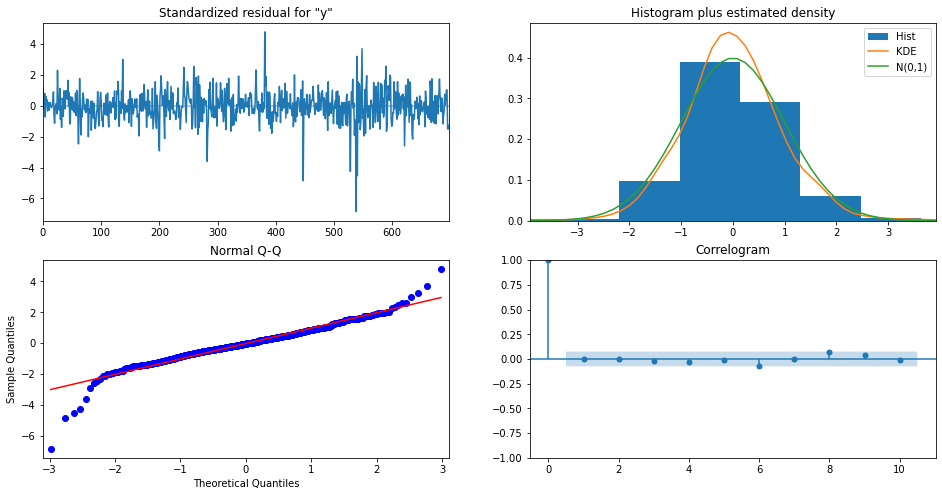

In [127]:
ordem_sazonal = (0, 0, 1, 7)
ordem = (1,0,2)
resultados_sarima_abev3 = sarima_table(df_train_abev3, ordem, ordem_sazonal)

In [128]:
sarimax(df_train_bbas3, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:5419.358329973261 - BIC:5432.9640537863015
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:4726.92861290851 - BIC:4745.028731539885
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:4281.472848025371 - BIC:4304.046411479733
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:2822.628098572625 - BIC:2840.7690636566795
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:2800.1564671129154 - BIC:2822.7816154021325
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:2795.804294795399 - BIC:2822.8925709406344
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:2807.0574667022474 - BIC:2829.69725629036
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:2798.832376963036 - BIC:2825.982554910097
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:2767.523641752578 - BIC:2799.1266305886857
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:2772.8913182488795 - BIC:2799.9973458863533
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:2774.365453213915 - BIC:2805.9891521243007


  8%|▊         | 1/12 [00:47<08:37, 47.05s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:2769.8626824133803 - BIC:2805.9803839403608
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:4608.155844835161 - BIC:4626.291000186894
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:4074.2822551912145 - BIC:4096.9000667219625
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:3732.2291550215505 - BIC:3759.3085356870242
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:2646.704279430387 - BIC:2669.373223620054
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:2615.984332659078 - BIC:2643.125706495975
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:2586.2039743366868 - BIC:2617.796585113073
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:2627.341748201752 - BIC:2654.5094957074875
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:2614.4336849524666 - BIC:2646.098621095513
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:2612.5532544226626 - BIC:2648.6590953099612
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:2594.6098883757913 - BIC:2626.233587286177
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:2599.767496273307 - BIC:2635.908866456605


 17%|█▋        | 2/12 [01:53<09:46, 58.68s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:2602.1600900171948 - BIC:2642.7791610154054
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:4317.806008732739 - BIC:4340.467680193851
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:3992.5693397856858 - BIC:4019.7018965747066
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:3391.169688417499 - BIC:3422.751905725012
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:2411.7536483897948 - BIC:2438.947654143129
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:2397.3208756697472 - BIC:2428.9755252569385
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:2416.8596904970577 - BIC:2452.9536531342155
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:2409.963208116992 - BIC:2441.65891354035
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:2393.11052827012 - BIC:2429.2872706554813
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:2757.4412660694957 - BIC:2798.0469740362983
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:2489.5298006613366 - BIC:2525.6711708446346
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:2380.6961591825348 - BIC:2421.3552006387454


 25%|██▌       | 3/12 [03:20<10:44, 71.62s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:2370.645662356923 - BIC:2415.7631156533703
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:2032.6170102137912 - BIC:2050.757975297846
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:2012.8131486112266 - BIC:2035.438296900444
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:2013.4417990905029 - BIC:2040.530075235738
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:2033.014556402294 - BIC:2055.6907627573623
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:2013.543965933207 - BIC:2040.6941438802676
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:1996.355670909612 - BIC:2027.9586597457196
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:2015.431794866941 - BIC:2042.5907640243656
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:2015.930357902611 - BIC:2047.6055655075152
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:1998.3549186788712 - BIC:2034.4726202058514
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:1998.4314425223342 - BIC:2030.044794054635
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:2002.3850362676421 - BIC:2038.5145808759858


 33%|███▎      | 4/12 [03:57<07:41, 57.74s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:2002.7499117978834 - BIC:2043.3823260157362
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:2031.3893323839459 - BIC:2054.0582765736126
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:2024.3235598211083 - BIC:2051.4649336580055
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:2018.793064664831 - BIC:2050.3856754412172
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:2031.9616215407352 - BIC:2059.1643545683355
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:2012.6865635313056 - BIC:2044.3514996743522
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:1993.5000094711597 - BIC:2029.6058503584582
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:2016.5585826203667 - BIC:2048.2440466373623
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:2015.4958204040386 - BIC:2051.684318853235
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:1999.6102401223966 - BIC:2040.2293111206072
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:1999.5388826656765 - BIC:2035.6684272740201
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:2005.8149541922323 - BIC:2046.460691876619


 42%|████▏     | 5/12 [04:39<06:04, 52.12s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:2000.8304794628932 - BIC:2045.9627805720163
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:2030.4856384965033 - BIC:2057.6796442498376
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:2010.2803121613417 - BIC:2041.9349617485327
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:2018.0697251145937 - BIC:2054.1636877517517
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:2031.1951225872049 - BIC:2062.921462632761
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:2011.0645716557167 - BIC:2047.2413140410779
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:1994.5257317784342 - BIC:2035.1314397452368
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:2017.6331678433 - BIC:2053.8451267198666
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:2012.571048552386 - BIC:2053.269883735917
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:1997.992645587836 - BIC:2043.1100988842834
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:2000.2572458028358 - BIC:2040.9029834872224
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:2006.8131724061395 - BIC:2051.975103166569


 50%|█████     | 6/12 [05:31<05:13, 52.18s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:1998.4811747928256 - BIC:2048.110373418918
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:2034.3412584560906 - BIC:2057.017464811159
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:2014.0869148016031 - BIC:2041.2370927486638
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:2009.992896402141 - BIC:2041.5958852382487
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:2034.616530919062 - BIC:2061.8279785451437
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:2015.6057682923588 - BIC:2047.280975897263
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:1998.6451944384294 - BIC:2034.7628959654096
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:2015.103664469819 - BIC:2046.7788720747233
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:2017.481395844406 - BIC:2053.6816331071536
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:2005.6587196994342 - BIC:2046.291133917287
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:1998.1861414352222 - BIC:2034.3038429622025
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:2001.1360932441648 - BIC:2041.7685074620176


 58%|█████▊    | 7/12 [06:09<03:57, 47.44s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:2005.8652469988185 - BIC:2051.012373907544
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:2033.4637000090324 - BIC:2060.6664330366325
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:2015.7387953594132 - BIC:2047.4037315024598
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:2015.5322127473298 - BIC:2051.6380536346282
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:2034.0452528067456 - BIC:2065.781774672279
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:2014.7660466982188 - BIC:2050.954545147415
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:1995.3329887782675 - BIC:2035.952059776478
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:2016.5157602174327 - BIC:2052.7159974801802
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:2019.306876885184 - BIC:2060.0189376405297
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:2003.3838565382912 - BIC:2048.5161576474143
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:1999.4114101181376 - BIC:2040.0438243359904
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:2005.1682273794327 - BIC:2050.315354288158


 67%|██████▋   | 8/12 [07:03<03:18, 49.57s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:2004.9021839497645 - BIC:2054.5477151698
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:2036.098700893151 - BIC:2067.8250409387074
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:2033.0622979363282 - BIC:2069.2390403216896
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:2021.092928026774 - BIC:2061.6986359935763
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:2027.137151991378 - BIC:2063.395826329157
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:2008.701953740829 - BIC:2049.4007889243603
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:1988.3137402491816 - BIC:2033.431193545629
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:2013.2353243914426 - BIC:2053.960591312034
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:2012.6094421260336 - BIC:2057.8303701077352
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:1991.8917965773026 - BIC:2041.5209952033945
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:1999.174473370627 - BIC:2044.3216002793524
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:1999.6995281291493 - BIC:2049.361367728747


 75%|███████▌  | 9/12 [08:00<02:35, 51.87s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:1996.132927154519 - BIC:2050.2738711102556
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:2036.5051492451225 - BIC:2063.7165968712043
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:2017.3612450441433 - BIC:2049.0364526490475
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:2014.0893973921395 - BIC:2050.2070989191197
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:2034.8458768818655 - BIC:2066.5823987473987
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:2017.4462423567113 - BIC:2053.646479619459
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:2003.2695639370831 - BIC:2043.901978154936
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:2015.3640539925761 - BIC:2051.552552441772
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:2019.9518499673554 - BIC:2060.663910722701
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:2006.0676018660704 - BIC:2051.2147287747957
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:2002.9339163480483 - BIC:2043.5529873462592
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:2003.919091901576 - BIC:2049.051393010699


 83%|████████▎ | 10/12 [08:51<01:43, 51.55s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:2005.9958648530837 - BIC:2055.6413960731193
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:2035.1456030445795 - BIC:2066.882124910113
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:2014.9520260371105 - BIC:2051.1405244863067
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:2011.0618386707781 - BIC:2051.680909668989
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:2035.6871420475634 - BIC:2071.9574527510304
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:2016.2337730281286 - BIC:2056.945833783474
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:1996.6719347127375 - BIC:2041.8042358218606
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:2016.34487381843 - BIC:2057.0569345737754
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:2018.0770782757063 - BIC:2063.3127013372014
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:2003.9271510719436 - BIC:2053.572682291979
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:1999.786420552908 - BIC:2044.9187216620312
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:2003.5712210616318 - BIC:2053.216752281667


 92%|█████████▏| 11/12 [09:46<00:52, 52.62s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:2002.9092420451439 - BIC:2057.0680033760914
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:2031.9668609039638 - BIC:2068.225535241743
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:2040.1856018749 - BIC:2080.884437058431
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:2021.7808392261159 - BIC:2066.898292522563
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:2043.14053089018 - BIC:2083.931539520181
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:2020.3138214896424 - BIC:2065.5347494713437
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:2002.3189135418397 - BIC:2051.948112167932
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:2021.0065253446992 - BIC:2066.2421484061942
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:2022.338997711995 - BIC:2072.0820184918666
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:1999.9684087088258 - BIC:2054.1093526645627
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:2008.0916391413948 - BIC:2057.7371703614303
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:2003.199383455818 - BIC:2057.3581447867655


100%|██████████| 12/12 [11:06<00:00, 55.53s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:2007.4339354141116 - BIC:2066.086624699493
--- 666.3139207363129 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:    index parameters parameters_seasonal          aic          bic
0    101  (2, 0, 3)        (1, 0, 3, 7)  1988.313740  2033.431194
6     41  (1, 0, 1)        (1, 0, 3, 7)  1996.355671  2027.958660


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0462      0.061      0.752      0.452      -0.074       0.166
ar.L2          0.9512      0.062     15.428      0.000       0.830       1.072
ma.L1          0.9536      0.055     17.434      0.000       0.846       1.061
ma.L2         -0.0311      0.040     -0.780      0.435      -0.109       0.047
ma.L3          0.0549      0.032      1.726      0.084      -0.007       0.117
ar.S.L7        0.9959      0.076     13.047      0.000       0.846       1.145
ma.S.L7       -0.8787      0.108     -8.173      0.000      -1.089      -0.668
ma.S.L14      -0.0865      0.052     -1.677      0.094      -0.188       0.015
ma.S.L21      -0.0429      0.038     -1.129      0.259      -0.117       0.032
sigma2         1.0021      0.207      4.849      0.000       0.597       1.407
--- 10.171960830688477 segundos ---


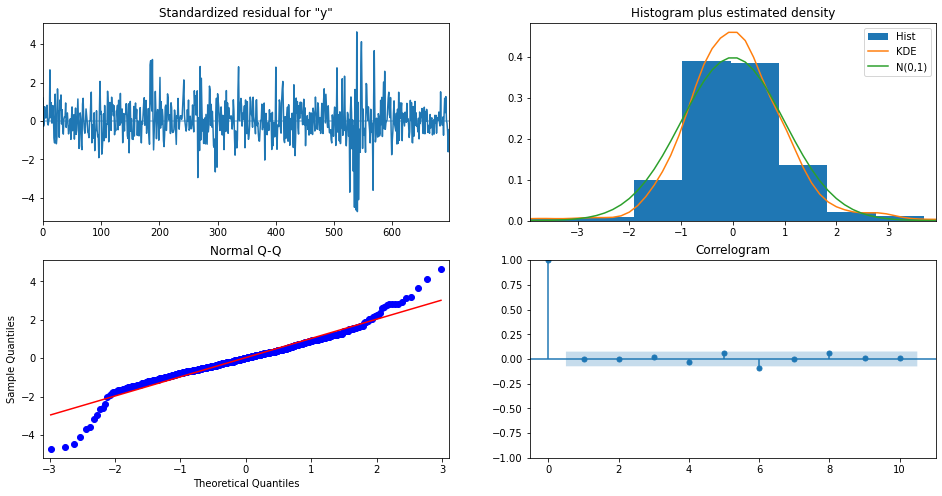

In [129]:
ordem_sazonal = (1,0,3,7)
ordem = (2,0,3)
resultados_sarima_bbas3 = sarima_table(df_train_bbas3, ordem, ordem_sazonal)

In [130]:
sarimax(df_train_itsa4, seasonal_pdq, pdq)

  0%|          | 0/12 [00:00<?, ?it/s]

SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:3562.208166820309 - BIC:3575.81389063335
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:2879.1703797803752 - BIC:2897.270498411749
SARIMA(0, 0, 1)x(0, 0, 3, 7)7 - AIC:2394.2071497080424 - BIC:2416.780713162405
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:674.0443078993687 - BIC:692.1852729834234
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:655.3160431036417 - BIC:677.9411913928591
SARIMA(0, 0, 1)x(1, 0, 3, 7)7 - AIC:635.378972702615 - BIC:662.4672488478502
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:660.8426478875151 - BIC:683.4824374756279
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:657.3142339468872 - BIC:684.464411893948
SARIMA(0, 0, 1)x(2, 0, 3, 7)7 - AIC:1141.1173654207998 - BIC:1172.7203542569075
SARIMA(0, 0, 1)x(3, 0, 1, 7)7 - AIC:638.4468169165972 - BIC:665.5528445540708
SARIMA(0, 0, 1)x(3, 0, 2, 7)7 - AIC:641.6767531079792 - BIC:673.300452018365


  8%|▊         | 1/12 [00:38<07:03, 38.51s/it]

SARIMA(0, 0, 1)x(3, 0, 3, 7)7 - AIC:1251.0966590827227 - BIC:1287.214360609703
SARIMA(0, 0, 2)x(0, 0, 1, 7)7 - AIC:2716.467911448728 - BIC:2734.6030668004614
SARIMA(0, 0, 2)x(0, 0, 2, 7)7 - AIC:2144.603207670517 - BIC:2167.2210192012644
SARIMA(0, 0, 2)x(0, 0, 3, 7)7 - AIC:1936.3372191447452 - BIC:1963.416599810219
SARIMA(0, 0, 2)x(1, 0, 1, 7)7 - AIC:452.0442245033812 - BIC:474.7131686930479
SARIMA(0, 0, 2)x(1, 0, 2, 7)7 - AIC:438.8954515628658 - BIC:466.03682539976285
SARIMA(0, 0, 2)x(1, 0, 3, 7)7 - AIC:433.6585591802152 - BIC:465.25116995660136
SARIMA(0, 0, 2)x(2, 0, 1, 7)7 - AIC:445.4173393141699 - BIC:472.5850868199052
SARIMA(0, 0, 2)x(2, 0, 2, 7)7 - AIC:440.85565983436754 - BIC:472.52059597741413
SARIMA(0, 0, 2)x(2, 0, 3, 7)7 - AIC:436.5122248117294 - BIC:472.61806569902785
SARIMA(0, 0, 2)x(3, 0, 1, 7)7 - AIC:436.38733516581453 - BIC:468.0110340762005
SARIMA(0, 0, 2)x(3, 0, 2, 7)7 - AIC:437.37965012091263 - BIC:473.5210203042108


 17%|█▋        | 2/12 [01:23<07:03, 42.38s/it]

SARIMA(0, 0, 2)x(3, 0, 3, 7)7 - AIC:437.9924995331336 - BIC:478.61157053134434
SARIMA(0, 0, 3)x(0, 0, 1, 7)7 - AIC:2367.350830209888 - BIC:2390.012501671
SARIMA(0, 0, 3)x(0, 0, 2, 7)7 - AIC:1848.6013379169826 - BIC:1875.7338947060036
SARIMA(0, 0, 3)x(0, 0, 3, 7)7 - AIC:1470.8594319612562 - BIC:1502.4416492687692
SARIMA(0, 0, 3)x(1, 0, 1, 7)7 - AIC:489.2928845397019 - BIC:516.486890293036
SARIMA(0, 0, 3)x(1, 0, 2, 7)7 - AIC:982.7877103867521 - BIC:1014.4423599739432
SARIMA(0, 0, 3)x(1, 0, 3, 7)7 - AIC:468.0825922927489 - BIC:504.17655492990673
SARIMA(0, 0, 3)x(2, 0, 1, 7)7 - AIC:497.725157611696 - BIC:529.4208630350538
SARIMA(0, 0, 3)x(2, 0, 2, 7)7 - AIC:581.0927546000944 - BIC:617.2694969854556
SARIMA(0, 0, 3)x(2, 0, 3, 7)7 - AIC:507.3621062030261 - BIC:547.9678141698287
SARIMA(0, 0, 3)x(3, 0, 1, 7)7 - AIC:254.93702941965833 - BIC:291.07839960295655
SARIMA(0, 0, 3)x(3, 0, 2, 7)7 - AIC:521.299756411596 - BIC:561.9587978678065


 25%|██▌       | 3/12 [02:31<08:06, 54.06s/it]

SARIMA(0, 0, 3)x(3, 0, 3, 7)7 - AIC:556.9348175090423 - BIC:602.0522708054896
SARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:-102.62081023594124 - BIC:-84.4798451518866
SARIMA(1, 0, 1)x(0, 0, 2, 7)7 - AIC:-97.67203787667772 - BIC:-75.04688958746041
SARIMA(1, 0, 1)x(0, 0, 3, 7)7 - AIC:-96.8039471881743 - BIC:-69.71567104293912
SARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:-102.08714596228643 - BIC:-79.41093960721813
SARIMA(1, 0, 1)x(1, 0, 2, 7)7 - AIC:-107.62354289708466 - BIC:-80.47336495002389
SARIMA(1, 0, 1)x(1, 0, 3, 7)7 - AIC:-108.2839230682348 - BIC:-76.68093423212709
SARIMA(1, 0, 1)x(2, 0, 1, 7)7 - AIC:-107.03821772186619 - BIC:-79.87924856444144
SARIMA(1, 0, 1)x(2, 0, 2, 7)7 - AIC:-107.2979217985251 - BIC:-75.62271419362085
SARIMA(1, 0, 1)x(2, 0, 3, 7)7 - AIC:-101.72943764286119 - BIC:-65.61173611588094
SARIMA(1, 0, 1)x(3, 0, 1, 7)7 - AIC:-105.6623943983217 - BIC:-74.04904286602095
SARIMA(1, 0, 1)x(3, 0, 2, 7)7 - AIC:-96.90078617755478 - BIC:-60.771241569211064


 33%|███▎      | 4/12 [03:12<06:29, 48.71s/it]

SARIMA(1, 0, 1)x(3, 0, 3, 7)7 - AIC:-87.02334833863569 - BIC:-46.390934120782916
SARIMA(1, 0, 2)x(0, 0, 1, 7)7 - AIC:-99.55775229375193 - BIC:-76.88880810408521
SARIMA(1, 0, 2)x(0, 0, 2, 7)7 - AIC:-79.40977368367736 - BIC:-52.268399846780284
SARIMA(1, 0, 2)x(0, 0, 3, 7)7 - AIC:-93.80521237086678 - BIC:-62.21260159448063
SARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:-99.40073976327449 - BIC:-72.19800673567443
SARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:-104.65974703246782 - BIC:-72.99481088942125
SARIMA(1, 0, 2)x(1, 0, 3, 7)7 - AIC:-96.8216648110195 - BIC:-60.71582392372105
SARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:-105.12882270157009 - BIC:-73.44335868457455
SARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:-102.93574940148787 - BIC:-66.74725095229178
SARIMA(1, 0, 2)x(2, 0, 3, 7)7 - AIC:-99.23065033909279 - BIC:-58.61157934088203
SARIMA(1, 0, 2)x(3, 0, 1, 7)7 - AIC:-97.39500075851464 - BIC:-61.26545615017093
SARIMA(1, 0, 2)x(3, 0, 2, 7)7 - AIC:-99.65153413334562 - BIC:-59.00579644895894


 42%|████▏     | 5/12 [03:59<05:38, 48.31s/it]

SARIMA(1, 0, 2)x(3, 0, 3, 7)7 - AIC:-84.90479720038724 - BIC:-39.77249609126417
SARIMA(1, 0, 3)x(0, 0, 1, 7)7 - AIC:-99.53144269198361 - BIC:-72.33743693864952
SARIMA(1, 0, 3)x(0, 0, 2, 7)7 - AIC:-78.52342277801488 - BIC:-46.86877319082381
SARIMA(1, 0, 3)x(0, 0, 3, 7)7 - AIC:-89.27262331467873 - BIC:-53.1786606775209
SARIMA(1, 0, 3)x(1, 0, 1, 7)7 - AIC:-98.87864216331627 - BIC:-67.15230211775983
SARIMA(1, 0, 3)x(1, 0, 2, 7)7 - AIC:-102.6380310511461 - BIC:-66.46128866578488
SARIMA(1, 0, 3)x(1, 0, 3, 7)7 - AIC:-95.72165951709164 - BIC:-55.11595155028909
SARIMA(1, 0, 3)x(2, 0, 1, 7)7 - AIC:-100.52301969195993 - BIC:-64.3110608153936
SARIMA(1, 0, 3)x(2, 0, 2, 7)7 - AIC:-100.32313760038298 - BIC:-59.62430241685161
SARIMA(1, 0, 3)x(2, 0, 3, 7)7 - AIC:-95.44683553360676 - BIC:-50.32938223715948
SARIMA(1, 0, 3)x(3, 0, 1, 7)7 - AIC:-95.40343410453121 - BIC:-54.75769642014453
SARIMA(1, 0, 3)x(3, 0, 2, 7)7 - AIC:-100.88768583089006 - BIC:-55.72575507046042


 50%|█████     | 6/12 [04:54<05:02, 50.50s/it]

SARIMA(1, 0, 3)x(3, 0, 3, 7)7 - AIC:-81.74953337144207 - BIC:-32.120334745350064
SARIMA(2, 0, 1)x(0, 0, 1, 7)7 - AIC:-101.3941309173257 - BIC:-78.7179245622574
SARIMA(2, 0, 1)x(0, 0, 2, 7)7 - AIC:-85.73049011325179 - BIC:-58.580312166191014
SARIMA(2, 0, 1)x(0, 0, 3, 7)7 - AIC:-102.97238251141661 - BIC:-71.3693936753089
SARIMA(2, 0, 1)x(1, 0, 1, 7)7 - AIC:-101.31562846662257 - BIC:-74.10418084054062
SARIMA(2, 0, 1)x(1, 0, 2, 7)7 - AIC:-104.21155719689199 - BIC:-72.53634959198774
SARIMA(2, 0, 1)x(1, 0, 3, 7)7 - AIC:-101.39497288712815 - BIC:-65.2772713601479
SARIMA(2, 0, 1)x(2, 0, 1, 7)7 - AIC:-104.29559595549614 - BIC:-72.6203883505919
SARIMA(2, 0, 1)x(2, 0, 2, 7)7 - AIC:-105.30904575637402 - BIC:-69.10880849362633
SARIMA(2, 0, 1)x(2, 0, 3, 7)7 - AIC:-101.82343785327522 - BIC:-61.191023635422454
SARIMA(2, 0, 1)x(3, 0, 1, 7)7 - AIC:-104.31950145892681 - BIC:-68.20179993194657
SARIMA(2, 0, 1)x(3, 0, 2, 7)7 - AIC:-102.36657455415667 - BIC:-61.7341603363039


 58%|█████▊    | 7/12 [05:36<03:58, 47.78s/it]

SARIMA(2, 0, 1)x(3, 0, 3, 7)7 - AIC:-99.58251163760016 - BIC:-54.435384728874865
SARIMA(2, 0, 2)x(0, 0, 1, 7)7 - AIC:-98.12941037486793 - BIC:-70.92667734726787
SARIMA(2, 0, 2)x(0, 0, 2, 7)7 - AIC:-81.7527212465959 - BIC:-50.087785103549315
SARIMA(2, 0, 2)x(0, 0, 3, 7)7 - AIC:-91.61098121406926 - BIC:-55.5051403267708
SARIMA(2, 0, 2)x(1, 0, 1, 7)7 - AIC:-97.60006277786903 - BIC:-65.86354091233562
SARIMA(2, 0, 2)x(1, 0, 2, 7)7 - AIC:-102.73241043354095 - BIC:-66.54391198434485
SARIMA(2, 0, 2)x(1, 0, 3, 7)7 - AIC:-102.06749416168272 - BIC:-61.44842316347196
SARIMA(2, 0, 2)x(2, 0, 1, 7)7 - AIC:-104.05238518503867 - BIC:-67.85214792229098
SARIMA(2, 0, 2)x(2, 0, 2, 7)7 - AIC:-100.27955736152103 - BIC:-59.56749660617542
SARIMA(2, 0, 2)x(2, 0, 3, 7)7 - AIC:-85.47388740329166 - BIC:-40.34158629416859
SARIMA(2, 0, 2)x(3, 0, 1, 7)7 - AIC:-94.86491587281367 - BIC:-54.2325016549609
SARIMA(2, 0, 2)x(3, 0, 2, 7)7 - AIC:-98.47135482347497 - BIC:-53.32422791474967


 67%|██████▋   | 8/12 [06:29<03:18, 49.54s/it]

SARIMA(2, 0, 2)x(3, 0, 3, 7)7 - AIC:-93.9012353216982 - BIC:-44.255704101662815
SARIMA(2, 0, 3)x(0, 0, 1, 7)7 - AIC:-97.42360328094415 - BIC:-65.69726323538771
SARIMA(2, 0, 3)x(0, 0, 2, 7)7 - AIC:-81.05011886800743 - BIC:-44.873376482646215
SARIMA(2, 0, 3)x(0, 0, 3, 7)7 - AIC:-89.51490971554531 - BIC:-48.90920174874277
SARIMA(2, 0, 3)x(1, 0, 1, 7)7 - AIC:-100.2472025977001 - BIC:-63.9885282599213
SARIMA(2, 0, 3)x(1, 0, 2, 7)7 - AIC:-98.39135249017481 - BIC:-57.692517306643445
SARIMA(2, 0, 3)x(1, 0, 3, 7)7 - AIC:-98.57011368211164 - BIC:-53.45266038566436
SARIMA(2, 0, 3)x(2, 0, 1, 7)7 - AIC:-99.95476289985403 - BIC:-59.22949597926287
SARIMA(2, 0, 3)x(2, 0, 2, 7)7 - AIC:-96.74515120287488 - BIC:-51.52422322117336
SARIMA(2, 0, 3)x(2, 0, 3, 7)7 - AIC:-94.9062616350952 - BIC:-45.2770630090032
SARIMA(2, 0, 3)x(3, 0, 1, 7)7 - AIC:-101.96258354147399 - BIC:-56.81545663274869
SARIMA(2, 0, 3)x(3, 0, 2, 7)7 - AIC:-97.15402277558238 - BIC:-47.49218317598455


 75%|███████▌  | 9/12 [07:26<02:35, 51.67s/it]

SARIMA(2, 0, 3)x(3, 0, 3, 7)7 - AIC:-90.93251030157879 - BIC:-36.79156634584206
SARIMA(3, 0, 1)x(0, 0, 1, 7)7 - AIC:-99.40441116560636 - BIC:-72.19296353952441
SARIMA(3, 0, 1)x(0, 0, 2, 7)7 - AIC:-78.43495583258934 - BIC:-46.7597482276851
SARIMA(3, 0, 1)x(0, 0, 3, 7)7 - AIC:-92.81368938402333 - BIC:-56.69598785704309
SARIMA(3, 0, 1)x(1, 0, 1, 7)7 - AIC:-97.65424352140093 - BIC:-65.91772165586752
SARIMA(3, 0, 1)x(1, 0, 2, 7)7 - AIC:-101.65874970417494 - BIC:-65.45851244142725
SARIMA(3, 0, 1)x(1, 0, 3, 7)7 - AIC:-99.7600906561802 - BIC:-59.12767643832743
SARIMA(3, 0, 1)x(2, 0, 1, 7)7 - AIC:-92.5975520838372 - BIC:-56.409053634641104
SARIMA(3, 0, 1)x(2, 0, 2, 7)7 - AIC:-100.61469232448091 - BIC:-59.9026315691353
SARIMA(3, 0, 1)x(2, 0, 3, 7)7 - AIC:-90.62261636485759 - BIC:-45.475489456132294
SARIMA(3, 0, 1)x(3, 0, 1, 7)7 - AIC:-102.88609851074463 - BIC:-62.26702751253387
SARIMA(3, 0, 1)x(3, 0, 2, 7)7 - AIC:-97.72236089365684 - BIC:-52.59005978453378


 83%|████████▎ | 10/12 [08:22<01:46, 53.12s/it]

SARIMA(3, 0, 1)x(3, 0, 3, 7)7 - AIC:-92.69860407653306 - BIC:-43.05307285649768
SARIMA(3, 0, 2)x(0, 0, 1, 7)7 - AIC:-97.09852550546897 - BIC:-65.36200363993557
SARIMA(3, 0, 2)x(0, 0, 2, 7)7 - AIC:-93.43802643571576 - BIC:-57.24952798651966
SARIMA(3, 0, 2)x(0, 0, 3, 7)7 - AIC:-92.26791981590974 - BIC:-51.648848817698976
SARIMA(3, 0, 2)x(1, 0, 1, 7)7 - AIC:-107.30310209048712 - BIC:-71.03279138702037
SARIMA(3, 0, 2)x(1, 0, 2, 7)7 - AIC:-100.55187143371454 - BIC:-59.83981067836893
SARIMA(3, 0, 2)x(1, 0, 3, 7)7 - AIC:-101.0942260237256 - BIC:-55.961924914602534
SARIMA(3, 0, 2)x(2, 0, 1, 7)7 - AIC:-100.56773634881762 - BIC:-59.85567559347201
SARIMA(3, 0, 2)x(2, 0, 2, 7)7 - AIC:-99.96372319990604 - BIC:-54.72810013841092
SARIMA(3, 0, 2)x(2, 0, 3, 7)7 - AIC:-96.45691461333038 - BIC:-46.811383393295
SARIMA(3, 0, 2)x(3, 0, 1, 7)7 - AIC:-98.595335903369 - BIC:-53.46303479424594
SARIMA(3, 0, 2)x(3, 0, 2, 7)7 - AIC:-99.82554306108631 - BIC:-50.18001184105093


 92%|█████████▏| 11/12 [09:12<00:52, 52.15s/it]

SARIMA(3, 0, 2)x(3, 0, 3, 7)7 - AIC:-94.28240737193288 - BIC:-40.12364604098519
SARIMA(3, 0, 3)x(0, 0, 1, 7)7 - AIC:-98.54295437245894 - BIC:-62.284280034680144
SARIMA(3, 0, 3)x(0, 0, 2, 7)7 - AIC:-70.40157561540796 - BIC:-29.7027404318766
SARIMA(3, 0, 3)x(0, 0, 3, 7)7 - AIC:-89.0776622598304 - BIC:-43.960208963383124
SARIMA(3, 0, 3)x(1, 0, 1, 7)7 - AIC:-98.16447533650464 - BIC:-57.37346670650349
SARIMA(3, 0, 3)x(1, 0, 2, 7)7 - AIC:-99.58635636127687 - BIC:-54.36542837957535
SARIMA(3, 0, 3)x(1, 0, 3, 7)7 - AIC:-96.96282681599315 - BIC:-47.33362818990115
SARIMA(3, 0, 3)x(2, 0, 1, 7)7 - AIC:-97.82576197471553 - BIC:-52.590138913220414
SARIMA(3, 0, 3)x(2, 0, 2, 7)7 - AIC:-90.10990442990304 - BIC:-40.36688365003137
SARIMA(3, 0, 3)x(2, 0, 3, 7)7 - AIC:-89.13422670104833 - BIC:-34.9932827453116
SARIMA(3, 0, 3)x(3, 0, 1, 7)7 - AIC:-90.18498651434723 - BIC:-40.53945529431185
SARIMA(3, 0, 3)x(3, 0, 2, 7)7 - AIC:-88.38600621068352 - BIC:-34.227244879735835


100%|██████████| 12/12 [10:28<00:00, 52.36s/it]

SARIMA(3, 0, 3)x(3, 0, 3, 7)7 - AIC:-88.25032264579015 - BIC:-29.597633360408693
--- 628.271036863327 seconds ---
A melhor combinação que traz o mínimo de AIC e BIC:     index parameters parameters_seasonal         aic        bic
0      41  (1, 0, 1)        (1, 0, 3, 7) -108.283923 -76.680934
18     36  (1, 0, 1)        (0, 0, 1, 7) -102.620810 -84.479845


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.001   1160.169      0.000       0.998       1.001
ma.L1         -0.0414      0.026     -1.619      0.105      -0.092       0.009
ma.S.L7        8.9466      2.385      3.751      0.000       4.272      13.622
sigma2         0.0006      0.000      1.883      0.060   -2.53e-05       0.001
--- 0.6241328716278076 segundos ---


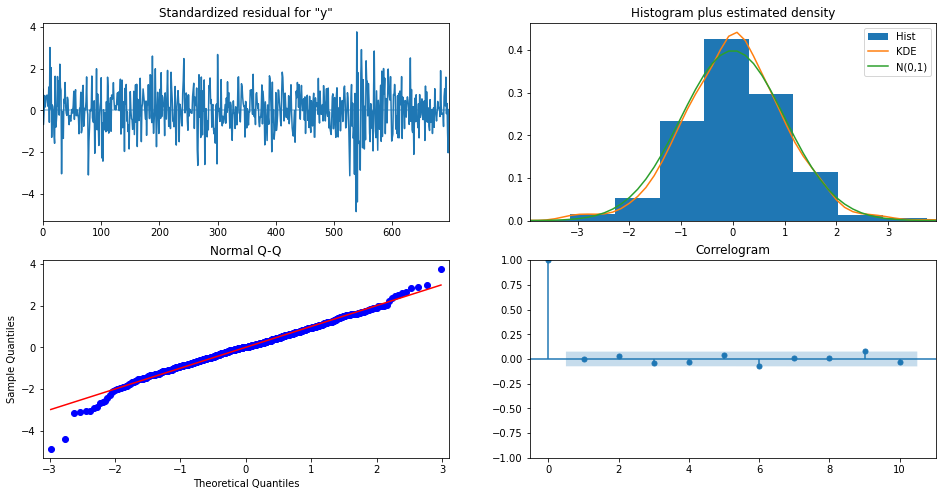

In [131]:
ordem_sazonal = (0,0,1,7)
ordem = (1,0,1)
resultados_sarima_itsa4 = sarima_table(df_train_itsa4, ordem, ordem_sazonal)

# Realizar a tabela do Sarima para outras empresas

#### Obter previsões 150 dias à frente do df de treino com ARIMA Sazonal

In [132]:
def metricas_sarima(df_test,results):
    pred = results.get_forecast(steps=292)
    y_forecasted = pred.predicted_mean
    y_forecasted = np.where(y_forecasted<0.0,0, y_forecasted)
    y_truth = df_test.close.values.squeeze()
    mse_sarima = ((y_truth-y_forecasted) ** 2).mean()
    rmse_sarima = np.sqrt(mse_sarima)
    mape_sarima = np.mean(np.abs((y_truth-y_forecasted) / y_truth))*100
    
    print('O MSE dessa previsão é {}'.format(round(mse_sarima, 2)))
    print('O RMSE dessa previsão é {}'.format(round(rmse_sarima, 2)))
    print('O MAPE dessa previsão é {}'.format(round(mape_sarima, 2)))
    return mse_sarima, rmse_sarima, mape_sarima

In [133]:
mse_vale_sarima, rmse_vale_sarima, mape_vale_sarima = metricas_sarima(df_test_vale,resultados_sarima_vale)

O MSE dessa previsão é 1321.07
O RMSE dessa previsão é 36.35
O MAPE dessa previsão é 33.16


In [134]:
mse_ptr4_sarima, rmse_ptr4_sarima, mape_ptr4_sarima = metricas_sarima(df_test_ptr4,resultados_sarima_ptr4)

O MSE dessa previsão é 69.32
O RMSE dessa previsão é 8.33
O MAPE dessa previsão é 29.17


In [135]:
mse_ptr3_sarima, rmse_ptr3_sarima, mape_ptr3_sarima = metricas_sarima(df_test_ptr3,resultados_sarima_ptr3)

O MSE dessa previsão é 81.36
O RMSE dessa previsão é 9.02
O MAPE dessa previsão é 30.57


In [136]:
mse_itub4_sarima, rmse_itub4_sarima, mape_itub4_sarima = metricas_sarima(df_test_itub4,resultados_sarima_itub4)

O MSE dessa previsão é 33.47
O RMSE dessa previsão é 5.79
O MAPE dessa previsão é 17.27


In [137]:
mse_bbdc4_sarima, rmse_bbdc4_sarima, mape_bbdc4_sarima = metricas_sarima(df_test_bbdc4,resultados_sarima_bbdc4)

O MSE dessa previsão é 21.79
O RMSE dessa previsão é 4.67
O MAPE dessa previsão é 19.73


In [138]:
mse_abev3_sarima, rmse_abev3_sarima, mape_abev3_sarima = metricas_sarima(df_test_bbdc4,resultados_sarima_abev3)

O MSE dessa previsão é 72.93
O RMSE dessa previsão é 8.54
O MAPE dessa previsão é 39.36


In [139]:
mse_bbas3_sarima, rmse_bbas3_sarima, mape_bbas3_sarima = metricas_sarima(df_test_bbas3,resultados_sarima_bbas3)

O MSE dessa previsão é 26.14
O RMSE dessa previsão é 5.11
O MAPE dessa previsão é 14.0


In [140]:
mse_itsa4_sarima, rmse_itsa4_sarima, mape_itsa4_sarima = metricas_sarima(df_test_itsa4,resultados_sarima_itsa4)

O MSE dessa previsão é 3.79
O RMSE dessa previsão é 1.95
O MAPE dessa previsão é 17.64


## Arima 

# Realizar o treinamento do Arima para outras empresas

In [141]:
def arima(df_treino, pdq):
    start_time = time.time()
    for param in tqdm(pdq):
        try:
            arima = ARIMA(df_treino.close.values,
                          order=param)
            
            results_arima = arima.fit()
                
            print('ARIMA{} - AIC:{} - BIC:{}'.format(param, results_arima.aic, results_arima.bic))
        except:
            continue

    print("--- %s seconds ---" % (time.time() - start_time))


In [142]:
def arima_table(df_treino, ordem):
    start_time = time.time()
    
    arima = ARIMA(df_treino['close'], order=ordem)
    results_arima = arima.fit()

    
    
    print(results_arima.summary())
    
   
    
    print("--- %s seconds ---" % (time.time() - start_time))
    return results_arima

In [143]:
arima(df_train_vale, pdq)

 25%|██▌       | 3/12 [00:00<00:01,  6.06it/s]

ARIMA(0, 0, 1) - AIC:3667.3312112564317 - BIC:3680.975868564719
ARIMA(0, 0, 2) - AIC:3283.9670480698087 - BIC:3302.159924480858
ARIMA(0, 0, 3) - AIC:3017.464718068446 - BIC:3040.205813582258


 42%|████▏     | 5/12 [00:00<00:01,  5.92it/s]

ARIMA(1, 0, 1) - AIC:2376.6143454905755 - BIC:2394.807221901625
ARIMA(1, 0, 2) - AIC:2376.520724377511 - BIC:2399.2618198913233


 58%|█████▊    | 7/12 [00:01<00:00,  5.23it/s]

ARIMA(1, 0, 3) - AIC:2378.2017128424895 - BIC:2405.491027459064
ARIMA(2, 0, 1) - AIC:2376.7185780941218 - BIC:2399.459673607934


 83%|████████▎ | 10/12 [00:01<00:00,  6.54it/s]

ARIMA(3, 0, 1) - AIC:2376.166510192361 - BIC:2403.455824808935


100%|██████████| 12/12 [00:02<00:00,  5.68it/s]

ARIMA(3, 0, 2) - AIC:2378.0067241201214 - BIC:2409.844257839458
--- 2.1173267364501953 seconds ---


In [144]:
ordem = (3,0,1)
resultados_arima_vale = arima_table(df_train_vale, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 1)   Log Likelihood               -1182.083
Method:                       css-mle   S.D. of innovations              1.313
Date:                Sat, 27 Aug 2022   AIC                           2376.167
Time:                        11:34:12   BIC                           2403.456
Sample:                             0   HQIC                          2386.717
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          51.0494      2.271     22.474      0.000      46.597      55.501
ar.L1.close     0.1760      0.199      0.886      0.376      -0.214       0.566
ar.L2.close     0.6354      0.185      3.444    

In [145]:
arima(df_train_ptr4,pdq)

 17%|█▋        | 2/12 [00:00<00:00, 13.12it/s]

ARIMA(0, 0, 1) - AIC:3194.1471784584955 - BIC:3207.7918357667827
ARIMA(0, 0, 2) - AIC:2725.558051782182 - BIC:2743.750928193231


 33%|███▎      | 4/12 [00:00<00:00, 13.75it/s]

ARIMA(1, 0, 1) - AIC:1463.989029788736 - BIC:1482.1819061997853
ARIMA(1, 0, 2) - AIC:1462.6810307053604 - BIC:1485.4221262191722


 50%|█████     | 6/12 [00:00<00:00,  7.47it/s]

ARIMA(1, 0, 3) - AIC:1459.2499260537766 - BIC:1486.5392406703509


 58%|█████▊    | 7/12 [00:00<00:00,  5.95it/s]

ARIMA(2, 0, 1) - AIC:1465.4104248949166 - BIC:1488.1515204087284


 67%|██████▋   | 8/12 [00:01<00:00,  4.57it/s]

ARIMA(2, 0, 2) - AIC:1455.874153475425 - BIC:1483.1634680919992


 75%|███████▌  | 9/12 [00:01<00:00,  3.33it/s]

ARIMA(2, 0, 3) - AIC:1450.1973472592517 - BIC:1482.0348809785883


 83%|████████▎ | 10/12 [00:02<00:00,  2.73it/s]

ARIMA(3, 0, 1) - AIC:1456.2346004871174 - BIC:1483.5239151036917


 92%|█████████▏| 11/12 [00:03<00:00,  1.88it/s]

ARIMA(3, 0, 2) - AIC:1449.5103123251133 - BIC:1481.3478460444499


100%|██████████| 12/12 [00:04<00:00,  2.95it/s]

ARIMA(3, 0, 3) - AIC:1448.1287486860792 - BIC:1484.5145015081782
--- 4.073718309402466 seconds ---


In [146]:
ordem = (3,0,3)
resultados_arima_ptr4 = arima_table(df_train_ptr4, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 3)   Log Likelihood                -716.064
Method:                       css-mle   S.D. of innovations              0.673
Date:                Sat, 27 Aug 2022   AIC                           1448.129
Time:                        11:34:17   BIC                           1484.515
Sample:                             0   HQIC                          1462.196
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.8726      1.481     15.447      0.000      19.970      25.775
ar.L1.close     0.9878      0.087     11.355      0.000       0.817       1.158
ar.L2.close     0.7204      0.090      8.037    

In [147]:
arima(df_train_ptr3, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 15.55it/s]

ARIMA(0, 0, 1) - AIC:3369.4884183318886 - BIC:3383.133075640176
ARIMA(0, 0, 2) - AIC:2886.868683473415 - BIC:2905.0615598844643


 33%|███▎      | 4/12 [00:00<00:00, 14.27it/s]

ARIMA(1, 0, 1) - AIC:1577.2606369838127 - BIC:1595.453513394862
ARIMA(1, 0, 2) - AIC:1573.7393702182383 - BIC:1596.48046573205


 58%|█████▊    | 7/12 [00:00<00:00,  6.63it/s]

ARIMA(1, 0, 3) - AIC:1567.95192928396 - BIC:1595.2412439005343
ARIMA(2, 0, 1) - AIC:1578.5129830101578 - BIC:1601.2540785239696


 67%|██████▋   | 8/12 [00:01<00:00,  4.73it/s]

ARIMA(2, 0, 2) - AIC:1566.8875789840936 - BIC:1594.1768936006679


 75%|███████▌  | 9/12 [00:01<00:00,  3.49it/s]

ARIMA(2, 0, 3) - AIC:1560.4961355363025 - BIC:1592.333669255639


 83%|████████▎ | 10/12 [00:02<00:00,  3.06it/s]

ARIMA(3, 0, 1) - AIC:1567.2372654015558 - BIC:1594.52658001813


 92%|█████████▏| 11/12 [00:03<00:00,  1.47it/s]

ARIMA(3, 0, 2) - AIC:1553.0881857939567 - BIC:1584.9257195132932


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

ARIMA(3, 0, 3) - AIC:1559.5422049021204 - BIC:1595.9279577242194
--- 4.326641798019409 seconds ---


In [148]:
ordem = (3,0,2)
resultados_arima_ptr3 = arima_table(df_train_ptr3, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood                -769.544
Method:                       css-mle   S.D. of innovations              0.724
Date:                Sat, 27 Aug 2022   AIC                           1553.088
Time:                        11:34:23   BIC                           1584.926
Sample:                             0   HQIC                          1565.397
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          24.1792      2.371     10.198      0.000      19.532      28.826
ar.L1.close     1.9829      0.019    104.909      0.000       1.946       2.020
ar.L2.close    -1.8957      0.031    -61.779    

In [149]:
arima(df_train_itub4, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 15.24it/s]

ARIMA(0, 0, 1) - AIC:3293.952316097475 - BIC:3307.596973405762
ARIMA(0, 0, 2) - AIC:2759.207774962989 - BIC:2777.4006513740383


 33%|███▎      | 4/12 [00:00<00:00,  9.63it/s]

ARIMA(0, 0, 3) - AIC:2355.9073628398232 - BIC:2378.6484583536353
ARIMA(1, 0, 1) - AIC:1385.865396264833 - BIC:1404.0582726758823
ARIMA(1, 0, 2) - AIC:1387.8604805385803 - BIC:1410.6015760523921


 50%|█████     | 6/12 [00:00<00:01,  5.99it/s]

ARIMA(1, 0, 3) - AIC:1388.3874609409875 - BIC:1415.6767755575618


 58%|█████▊    | 7/12 [00:01<00:00,  5.26it/s]

ARIMA(2, 0, 1) - AIC:1387.4187550995134 - BIC:1410.1598506133253


 67%|██████▋   | 8/12 [00:01<00:00,  4.33it/s]

ARIMA(2, 0, 2) - AIC:1389.402795800757 - BIC:1416.6921104173314


 75%|███████▌  | 9/12 [00:01<00:00,  3.64it/s]

ARIMA(2, 0, 3) - AIC:1390.309342270385 - BIC:1422.1468759897216


 83%|████████▎ | 10/12 [00:02<00:00,  3.17it/s]

ARIMA(3, 0, 1) - AIC:1384.0607080509337 - BIC:1411.350022667508


 92%|█████████▏| 11/12 [00:03<00:00,  2.16it/s]

ARIMA(3, 0, 2) - AIC:1372.667791717955 - BIC:1404.5053254372915


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

ARIMA(3, 0, 3) - AIC:1387.264497369194 - BIC:1423.650250191293
--- 3.8234877586364746 seconds ---


In [150]:
ordem = (3,0,2)
resultados_arima_itub4 = arima_table(df_train_itub4, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood                -679.334
Method:                       css-mle   S.D. of innovations              0.638
Date:                Sat, 27 Aug 2022   AIC                           1372.668
Time:                        11:34:28   BIC                           1404.505
Sample:                             0   HQIC                          1384.976
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          30.2917      2.454     12.344      0.000      25.482      35.101
ar.L1.close    -0.7871      0.079     -9.953      0.000      -0.942      -0.632
ar.L2.close     0.8671      0.023     38.443    

In [151]:
arima(df_train_bbdc4, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 13.01it/s]

ARIMA(0, 0, 1) - AIC:3118.5250813236753 - BIC:3132.1697386319624
ARIMA(0, 0, 2) - AIC:2569.304500059921 - BIC:2587.4973764709703


 33%|███▎      | 4/12 [00:00<00:00,  9.02it/s]

ARIMA(0, 0, 3) - AIC:2123.09451986351 - BIC:2145.835615377322
ARIMA(1, 0, 1) - AIC:1033.4163501875855 - BIC:1051.609226598635


 42%|████▏     | 5/12 [00:00<00:00,  7.44it/s]

ARIMA(1, 0, 2) - AIC:1034.3433316035907 - BIC:1057.0844271174026


 58%|█████▊    | 7/12 [00:01<00:00,  5.64it/s]

ARIMA(1, 0, 3) - AIC:1035.0313617668533 - BIC:1062.3206763834276
ARIMA(2, 0, 1) - AIC:1034.1655793259483 - BIC:1056.9066748397602


 67%|██████▋   | 8/12 [00:01<00:00,  4.84it/s]

ARIMA(2, 0, 2) - AIC:1035.875358655193 - BIC:1063.1646732717672


 75%|███████▌  | 9/12 [00:01<00:00,  3.68it/s]

ARIMA(2, 0, 3) - AIC:1037.0056847480164 - BIC:1068.843218467353


 83%|████████▎ | 10/12 [00:02<00:00,  3.83it/s]

ARIMA(3, 0, 1) - AIC:1035.938455214597 - BIC:1063.2277698311714


 92%|█████████▏| 11/12 [00:02<00:00,  2.61it/s]

ARIMA(3, 0, 2) - AIC:1028.5978732892597 - BIC:1060.4354070085963


100%|██████████| 12/12 [00:03<00:00,  3.17it/s]

ARIMA(3, 0, 3) - AIC:1029.3636110607918 - BIC:1065.7493638828905
--- 3.7850635051727295 seconds ---


In [152]:
ordem = (3,0,2)
resultados_arima_bbdc4 = arima_table(df_train_bbdc4, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood                -507.299
Method:                       css-mle   S.D. of innovations              0.499
Date:                Sat, 27 Aug 2022   AIC                           1028.598
Time:                        11:34:32   BIC                           1060.435
Sample:                             0   HQIC                          1040.907
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.1587      2.186      9.678      0.000      16.874      25.444
ar.L1.close    -0.1965      0.082     -2.395      0.017      -0.357      -0.036
ar.L2.close     0.3780      0.096      3.955    

In [153]:
arima(df_train_abev3, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 15.57it/s]

ARIMA(0, 0, 1) - AIC:2711.588830660544 - BIC:2725.233487968831
ARIMA(0, 0, 2) - AIC:2107.3464136114476 - BIC:2125.539290022497


 33%|███▎      | 4/12 [00:00<00:00,  8.04it/s]

ARIMA(0, 0, 3) - AIC:1664.4066871952712 - BIC:1687.147782709083
ARIMA(1, 0, 1) - AIC:400.8010854429074 - BIC:418.9939618539569


 42%|████▏     | 5/12 [00:00<00:01,  6.68it/s]

ARIMA(1, 0, 2) - AIC:398.931150522699 - BIC:421.67224603651084


 58%|█████▊    | 7/12 [00:01<00:00,  5.32it/s]

ARIMA(1, 0, 3) - AIC:400.51203847299007 - BIC:427.8013530895643
ARIMA(2, 0, 1) - AIC:400.3738175796884 - BIC:423.11491309350026


 67%|██████▋   | 8/12 [00:01<00:00,  4.68it/s]

ARIMA(2, 0, 2) - AIC:400.68724357290967 - BIC:427.9765581894839


 75%|███████▌  | 9/12 [00:01<00:00,  3.49it/s]

ARIMA(2, 0, 3) - AIC:402.0539412991393 - BIC:433.8914750184759


 83%|████████▎ | 10/12 [00:02<00:00,  3.52it/s]

ARIMA(3, 0, 1) - AIC:400.8973383608304 - BIC:428.18665297740466


 92%|█████████▏| 11/12 [00:02<00:00,  2.60it/s]

ARIMA(3, 0, 2) - AIC:398.69739168635374 - BIC:430.53492540569033


100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

ARIMA(3, 0, 3) - AIC:399.472541951523 - BIC:435.858294773622
--- 3.593331813812256 seconds ---


In [154]:
ordem = (3,0,2)

resultados_arima_abev3 = arima_table(df_train_abev3, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood                -192.349
Method:                       css-mle   S.D. of innovations              0.318
Date:                Sat, 27 Aug 2022   AIC                            398.697
Time:                        11:34:37   BIC                            430.535
Sample:                             0   HQIC                           411.006
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.3636      2.212      7.851      0.000      13.029      21.698
ar.L1.close     0.0528      0.064      0.827      0.408      -0.072       0.178
ar.L2.close     0.0725      0.083      0.874    

In [155]:
arima(df_train_bbas3, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 12.25it/s]

ARIMA(0, 0, 1) - AIC:4133.498397889953 - BIC:4147.143055198239
ARIMA(0, 0, 2) - AIC:3607.674117206542 - BIC:3625.8669936175916


 33%|███▎      | 4/12 [00:00<00:00,  9.09it/s]

ARIMA(0, 0, 3) - AIC:3151.809759402649 - BIC:3174.550854916461
ARIMA(1, 0, 1) - AIC:2068.1507257511507 - BIC:2086.3436021622


 42%|████▏     | 5/12 [00:00<00:01,  6.94it/s]

ARIMA(1, 0, 2) - AIC:2067.942281375707 - BIC:2090.683376889519


 58%|█████▊    | 7/12 [00:01<00:00,  5.65it/s]

ARIMA(1, 0, 3) - AIC:2069.317934763524 - BIC:2096.6072493800984
ARIMA(2, 0, 1) - AIC:2069.2330323222645 - BIC:2091.9741278360766


 67%|██████▋   | 8/12 [00:01<00:00,  4.04it/s]

ARIMA(2, 0, 2) - AIC:2069.6057496240423 - BIC:2096.8950642406166


 75%|███████▌  | 9/12 [00:01<00:00,  3.20it/s]

ARIMA(2, 0, 3) - AIC:2060.517304428109 - BIC:2092.354838147446


 83%|████████▎ | 10/12 [00:02<00:00,  2.72it/s]

ARIMA(3, 0, 1) - AIC:2066.722771123504 - BIC:2094.0120857400784


 92%|█████████▏| 11/12 [00:02<00:00,  2.43it/s]

ARIMA(3, 0, 2) - AIC:2052.9568593781073 - BIC:2084.794393097444


100%|██████████| 12/12 [00:03<00:00,  3.21it/s]

ARIMA(3, 0, 3) - AIC:2054.6333579345865 - BIC:2091.019110756685
--- 3.7387168407440186 seconds ---


In [156]:
ordem = (3,0,2)

resultados_arima_bbas3 = arima_table(df_train_bbas3, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood               -1019.478
Method:                       css-mle   S.D. of innovations              1.039
Date:                Sat, 27 Aug 2022   AIC                           2052.957
Time:                        11:34:41   BIC                           2084.794
Sample:                             0   HQIC                          2065.266
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          38.1070      4.745      8.031      0.000      28.807      47.407
ar.L1.close    -0.6711      0.102     -6.611      0.000      -0.870      -0.472
ar.L2.close     0.8603      0.028     31.252    

In [157]:
arima(df_train_itsa4, pdq)

 17%|█▋        | 2/12 [00:00<00:00, 13.52it/s]

ARIMA(0, 0, 1) - AIC:1722.7793510265215 - BIC:1736.4240083348086
ARIMA(0, 0, 2) - AIC:1193.7204007854232 - BIC:1211.9132771964726


 33%|███▎      | 4/12 [00:00<00:00,  8.89it/s]

ARIMA(0, 0, 3) - AIC:819.2811593546617 - BIC:842.0222548684735
ARIMA(1, 0, 1) - AIC:-100.67153522328499 - BIC:-82.4786588122355


 42%|████▏     | 5/12 [00:00<00:01,  6.77it/s]

ARIMA(1, 0, 2) - AIC:-100.10060285823101 - BIC:-77.35950734441914


 58%|█████▊    | 7/12 [00:01<00:00,  5.49it/s]

ARIMA(1, 0, 3) - AIC:-99.70036688748178 - BIC:-72.41105227090755
ARIMA(2, 0, 1) - AIC:-99.83080962835265 - BIC:-77.08971411454078


 67%|██████▋   | 8/12 [00:01<00:00,  4.77it/s]

ARIMA(2, 0, 2) - AIC:-98.7043136617408 - BIC:-71.41499904516657


 75%|███████▌  | 9/12 [00:01<00:00,  3.88it/s]

ARIMA(2, 0, 3) - AIC:-97.70430910323512 - BIC:-65.86677538389851


 83%|████████▎ | 10/12 [00:02<00:00,  3.81it/s]

ARIMA(3, 0, 1) - AIC:-98.54276802311097 - BIC:-71.25345340653674


 92%|█████████▏| 11/12 [00:02<00:00,  2.79it/s]

ARIMA(3, 0, 2) - AIC:-107.94659343976537 - BIC:-76.10905972042876


100%|██████████| 12/12 [00:05<00:00,  2.12it/s]

ARIMA(3, 0, 3) - AIC:-98.89491905464502 - BIC:-62.509166232546036
--- 5.673031806945801 seconds ---


In [158]:
ordem = (3,0,2)

resultados_arima_itsa4 = arima_table(df_train_itsa4, ordem)

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                  698
Model:                     ARMA(3, 2)   Log Likelihood                  60.973
Method:                       css-mle   S.D. of innovations              0.221
Date:                Sat, 27 Aug 2022   AIC                           -107.947
Time:                        11:34:48   BIC                            -76.109
Sample:                             0   HQIC                           -95.638
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.5157      0.726     14.489      0.000       9.093      11.938
ar.L1.close    -0.7628      0.101     -7.540      0.000      -0.961      -0.565
ar.L2.close     0.8573      0.024     35.992    

In [159]:
def metricas_arima(df_test, results_arima):
    pred = results_arima.forecast(steps=292)[0]
    y_forecasted = np.mean(pred)
    y_forecasted = np.where(y_forecasted<0.0,0, y_forecasted)
    y_truth = df_test.close.values.squeeze()
    mse_arima = ((y_truth-y_forecasted) ** 2).mean()
    rmse_arima = np.sqrt(mse_arima)
    mape_arima = np.mean(np.abs((y_truth-y_forecasted) / y_truth))*100
    
    print('O MSE dessa previsão é {}'.format(round(mse_arima, 2)))
    print('O RMSE dessa previsão é {}'.format(round(rmse_arima, 2)))
    print('O MAPE dessa previsão é {}'.format(round(mape_arima, 2)))
    return mse_arima, rmse_arima, mape_arima

# Realizar as métricas do Arima para outras empresas

In [160]:
mse_arima_vale, rmse_arima_vale,mape_arima_vale = metricas_arima(df_test_vale,resultados_arima_vale)

O MSE dessa previsão é 1817.62
O RMSE dessa previsão é 42.63
O MAPE dessa previsão é 40.73


In [161]:
mse_arima_petr4, rmse_arima_petr4, mape_arima_petr4 = metricas_arima(df_test_ptr4,resultados_arima_ptr4)

O MSE dessa previsão é 24.72
O RMSE dessa previsão é 4.97
O MAPE dessa previsão é 16.25


In [162]:
mse_arima_ptr3, rmse_arima_ptr3, mape_arima_ptr3 = metricas_arima(df_test_ptr3,resultados_arima_ptr3)

O MSE dessa previsão é 26.59
O RMSE dessa previsão é 5.16
O MAPE dessa previsão é 15.89


In [163]:
mse_arima_itub4, rmse_arima_itub4, mape_arima_itub4 = metricas_arima(df_test_itub4,resultados_arima_itub4)

O MSE dessa previsão é 9.9
O RMSE dessa previsão é 3.15
O MAPE dessa previsão é 9.6


In [164]:
mse_arima_bbdc4, rmse_arima_bbdc4, mape_arima_bbdc4 = metricas_arima(df_test_bbdc4,resultados_arima_bbdc4)

O MSE dessa previsão é 5.81
O RMSE dessa previsão é 2.41
O MAPE dessa previsão é 9.12


In [165]:
mse_arima_bbas3, rmse_arima_bbas3, mape_arima_bbas3 = metricas_arima(df_test_bbas3,resultados_arima_bbas3)

O MSE dessa previsão é 17.53
O RMSE dessa previsão é 4.19
O MAPE dessa previsão é 12.19


In [166]:
mse_arima_abev3, rmse_arima_abev3, mape_arima_abev3 = metricas_arima(df_test_abev3,resultados_arima_abev3)

O MSE dessa previsão é 3.33
O RMSE dessa previsão é 1.83
O MAPE dessa previsão é 8.47


In [167]:
mse_arima_itsa4, rmse_arima_itsa4, mape_arima_itsa4 = metricas_arima(df_test_itsa4,resultados_arima_itsa4)

O MSE dessa previsão é 0.51
O RMSE dessa previsão é 0.72
O MAPE dessa previsão é 5.8


In [168]:
# Plot residual errors
def plot_residuos (results_arima):
    residuals = pd.DataFrame(results_arima.resid)

    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0], figsize=(16,4))
    residuals.plot(kind='kde', title='Density', ax=ax[1], figsize=(16,4))

    plt.show()

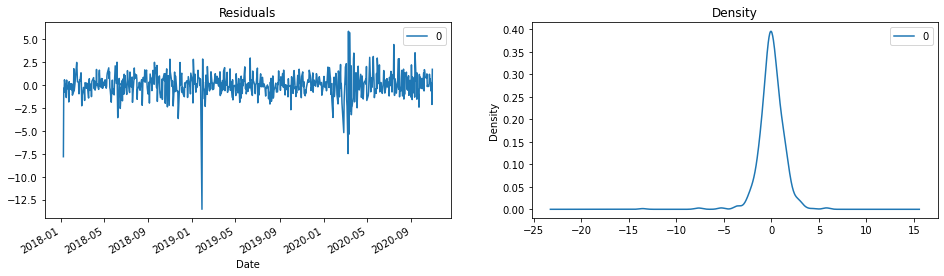

In [169]:
plot_residuos(resultados_arima_vale)

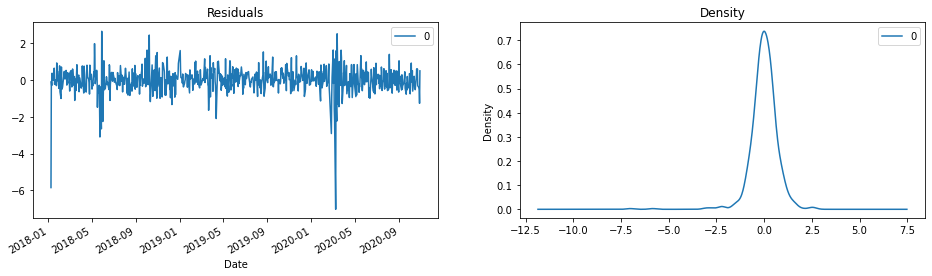

In [170]:
plot_residuos(resultados_arima_ptr4)

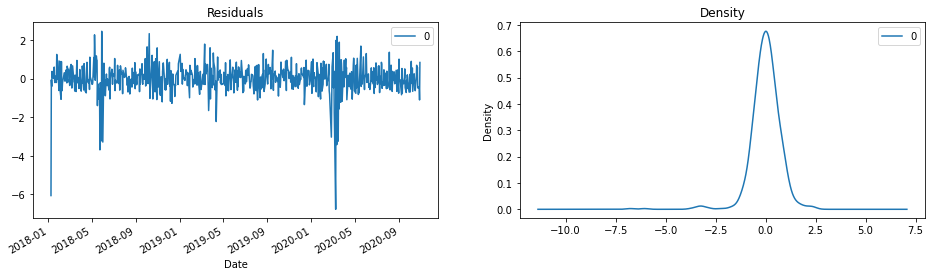

In [171]:
plot_residuos(resultados_arima_ptr3)

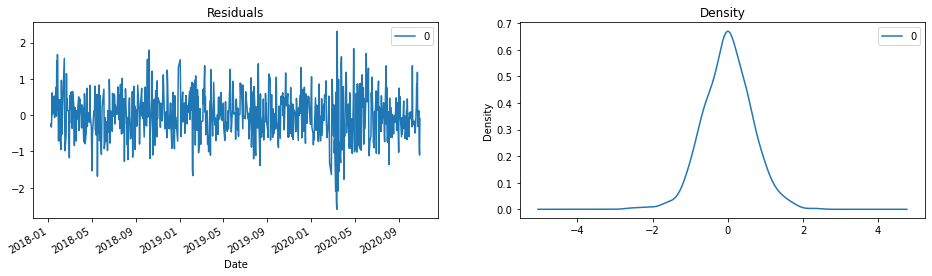

In [172]:
plot_residuos(resultados_arima_itub4)

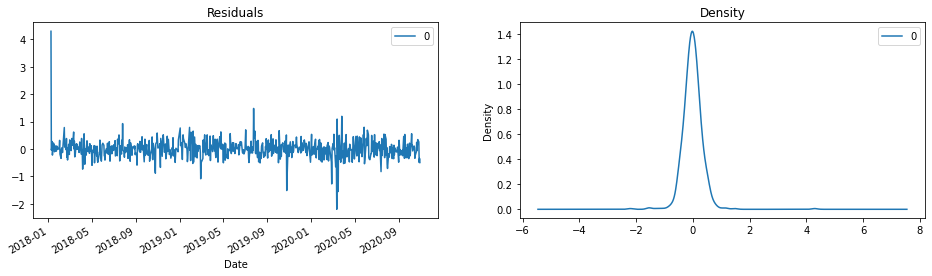

In [173]:
plot_residuos(resultados_arima_abev3)

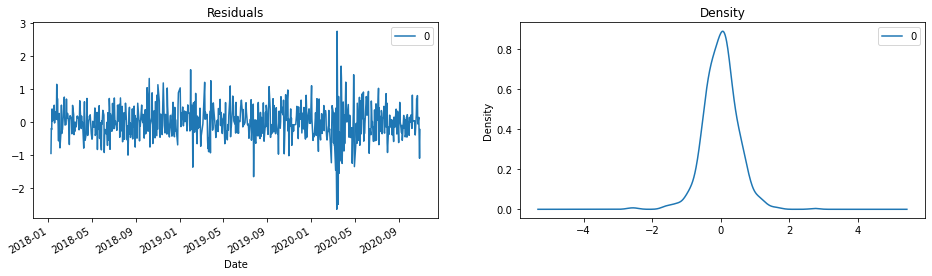

In [174]:
plot_residuos(resultados_arima_bbdc4)

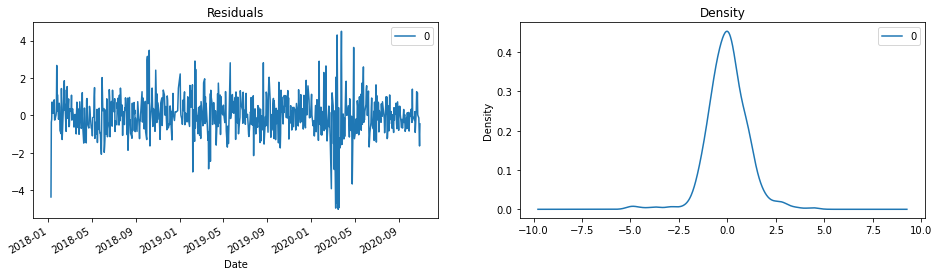

In [175]:
plot_residuos(resultados_arima_bbas3)

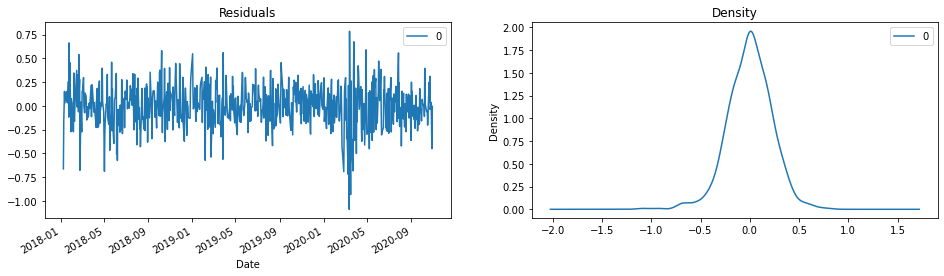

In [176]:
plot_residuos(resultados_arima_itsa4)

## Plot de Predição do Prophet

In [177]:
def plot_predict_prophet(df_treino, df_teste, results_prophet, indice): 
    
   
    prophet_forecast_series = pd.Series(results_prophet.y_pred.values, index=df_teste.index)
    
    
    results_prophet.y_pred_lower.values
    results_prophet.y_pred_upper.values
    
   
    lower_series = pd.Series(results_prophet.y_pred_lower.values, index=df_teste.index)
    upper_series = pd.Series(results_prophet.y_pred_upper.values, index=df_teste.index)
    
    
    
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(df_treino['close'], label='training')
    plt.plot(df_teste['close'], color = 'blue', label='Actual Stock Price')
    plt.plot(prophet_forecast_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('Predição das ações da {} através do modelo Prophet'.format(indice))
    plt.xlabel('Time')
    plt.ylabel('Preço Atual')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

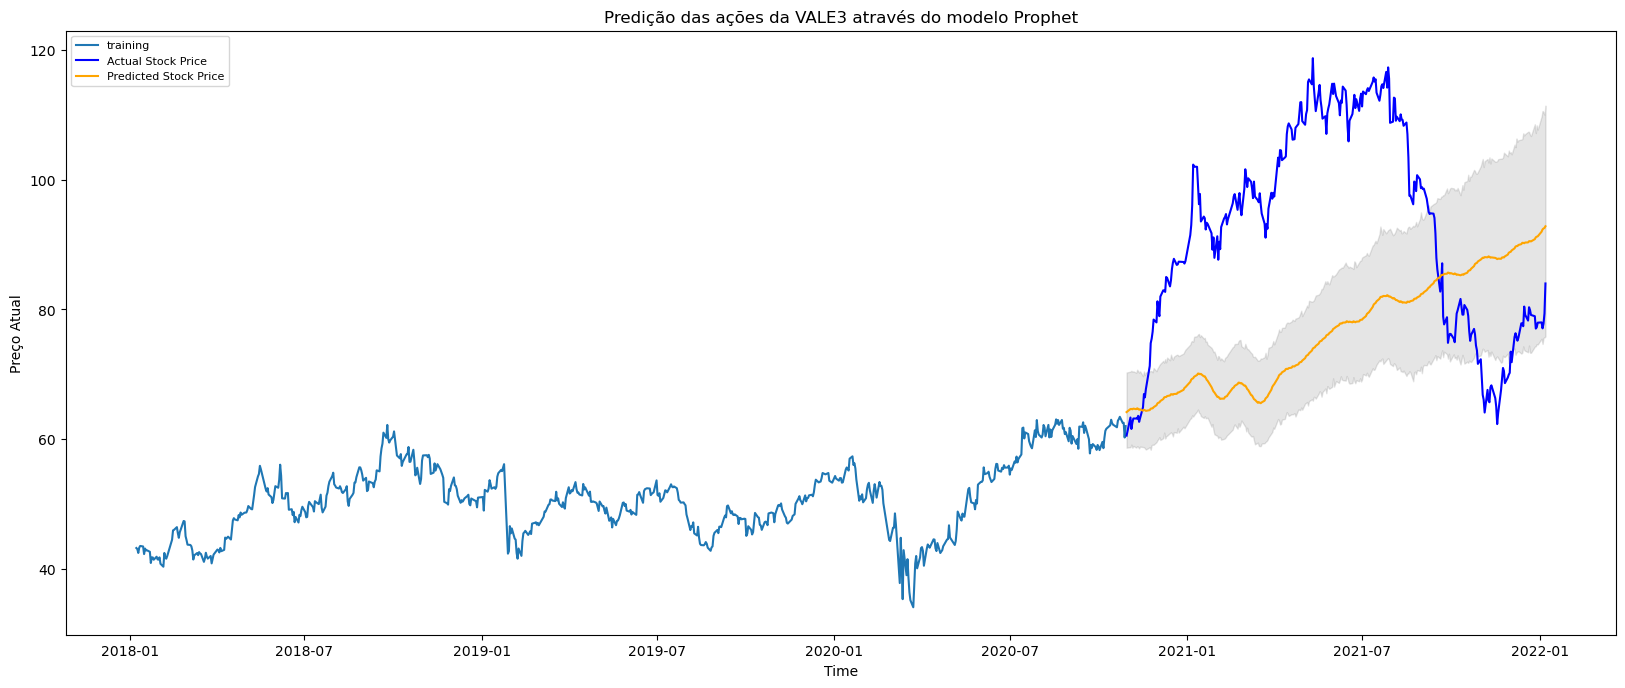

In [178]:
plot_predict_prophet(df_train_vale, df_test_vale, resultados_vale_prophet, 'VALE3')

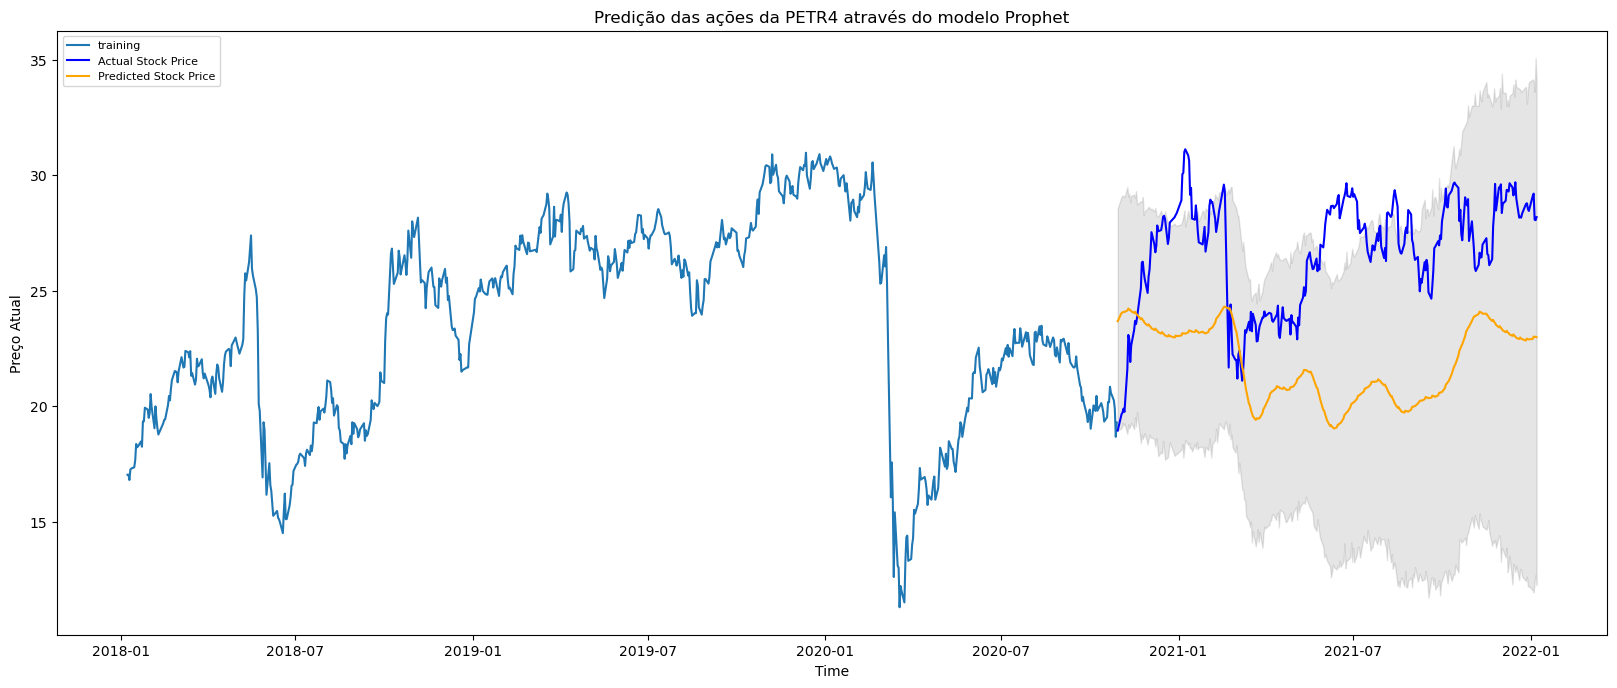

In [179]:
plot_predict_prophet(df_train_ptr4, df_test_ptr4, resultados_petr4_prophet, 'PETR4')

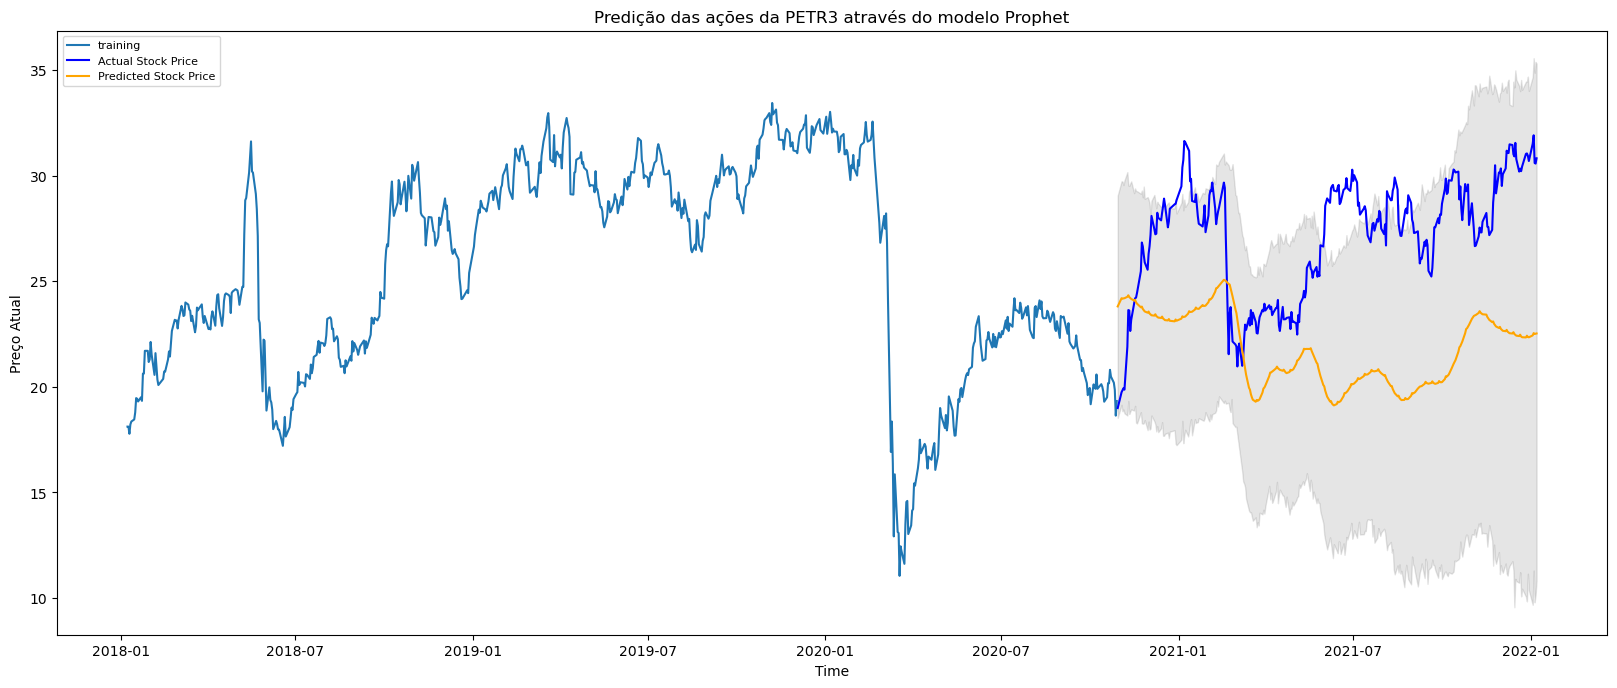

In [180]:
plot_predict_prophet(df_train_ptr3, df_test_ptr3, resultados_petr3_prophet, 'PETR3')

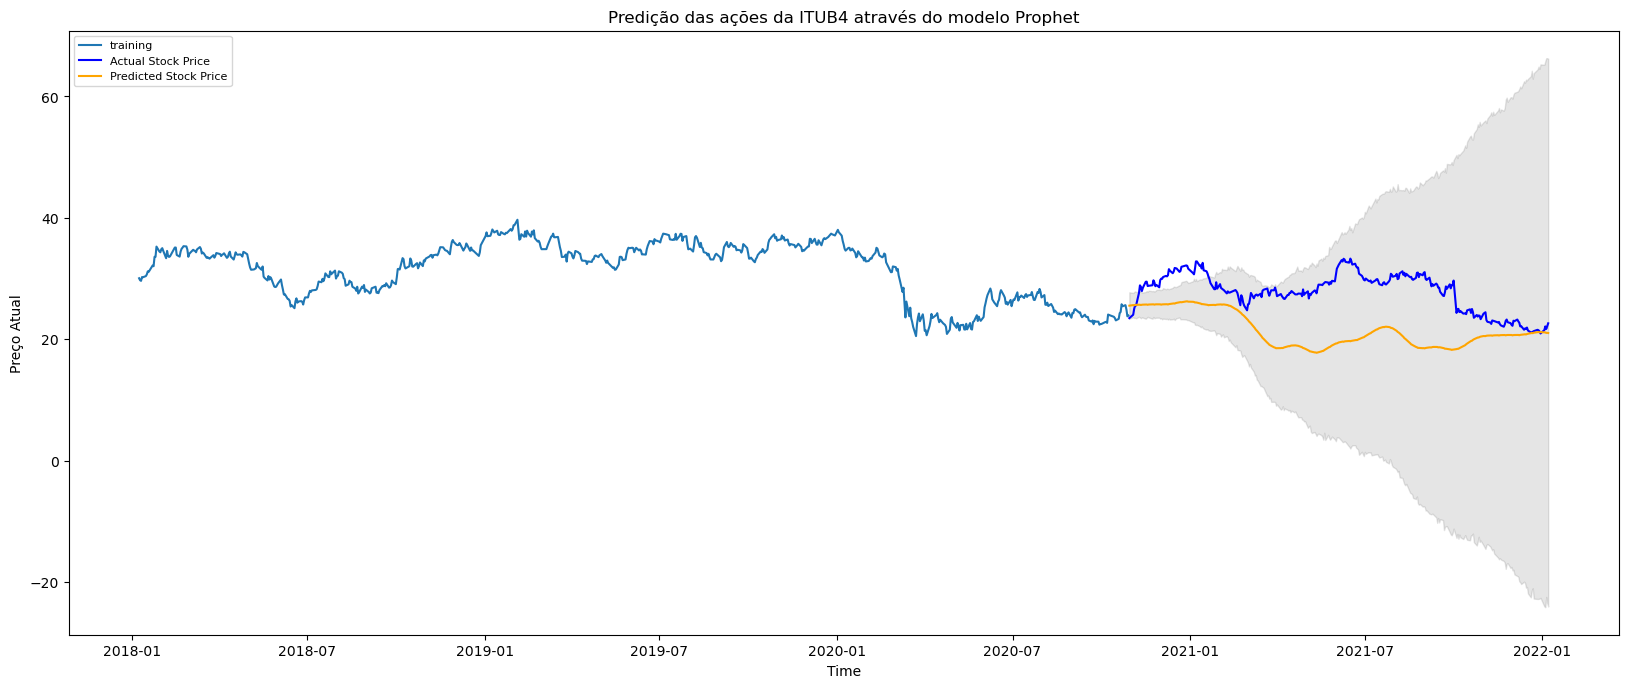

In [181]:
plot_predict_prophet(df_train_itub4 , df_test_itub4, resultados_itub4_prophet, 'ITUB4')

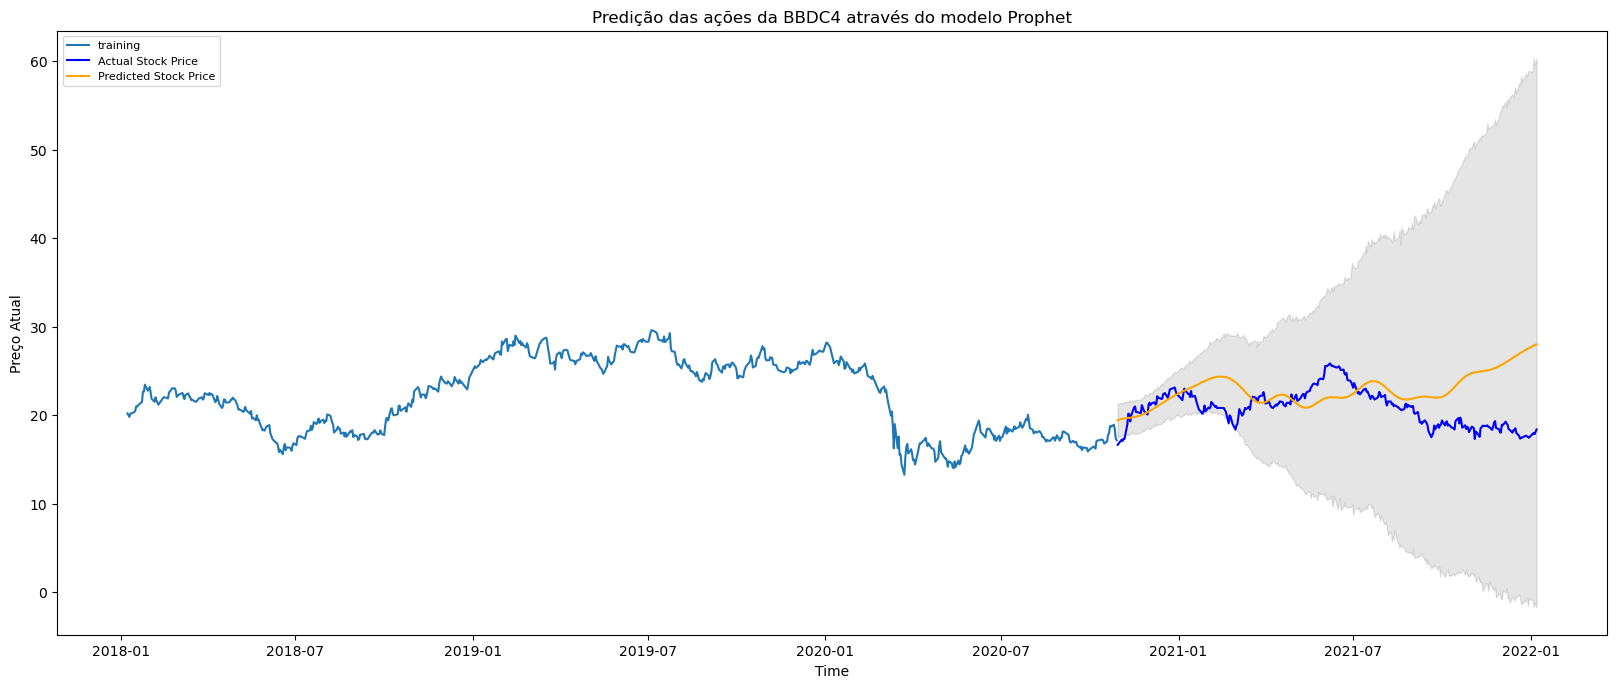

In [182]:
plot_predict_prophet(df_train_bbdc4, df_test_bbdc4, resultados_bbdc4_prophet, 'BBDC4')

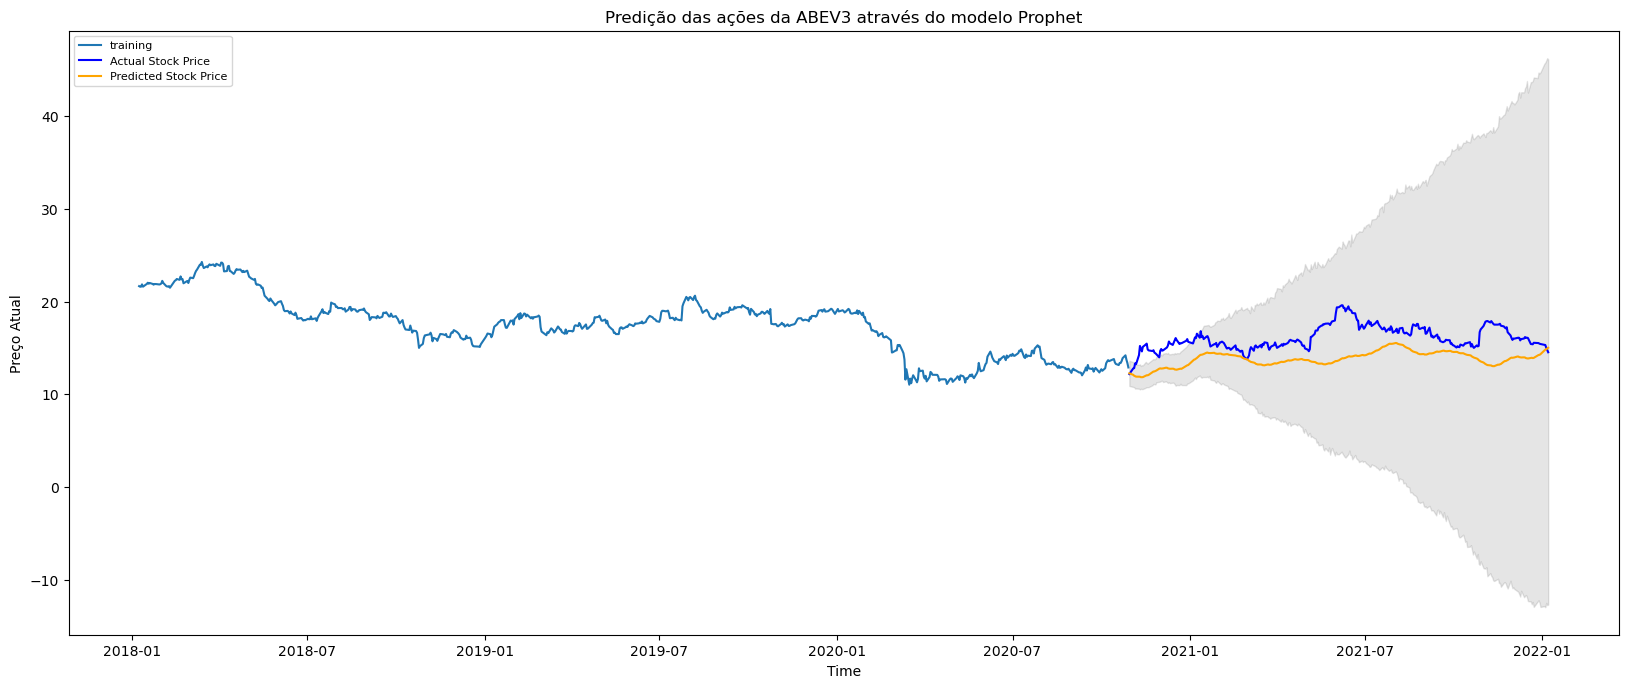

In [183]:
plot_predict_prophet(df_train_abev3, df_test_abev3, resultados_abev3_prophet, 'ABEV3')

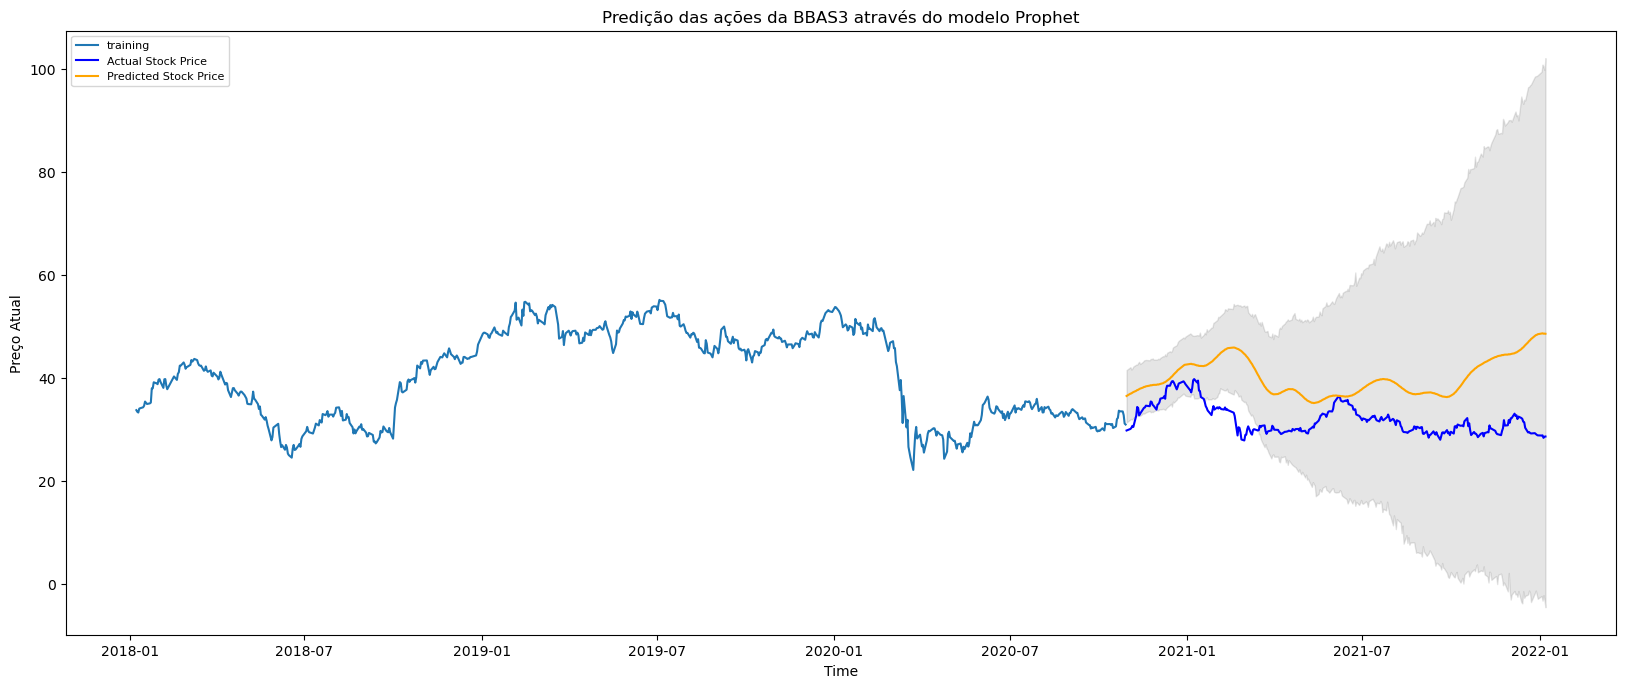

In [184]:
plot_predict_prophet(df_train_bbas3, df_test_bbas3, resultados_bbas3_prophet, 'BBAS3')

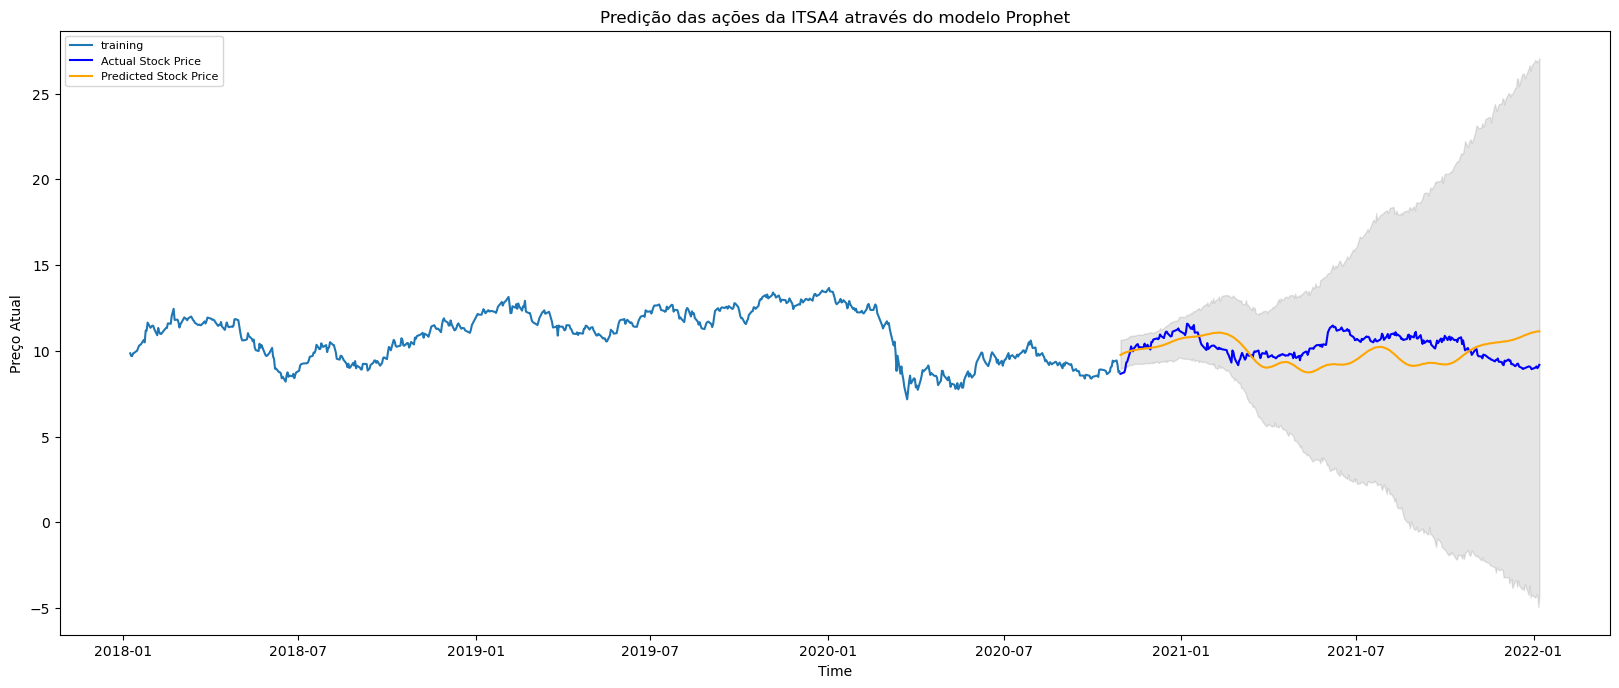

In [185]:
plot_predict_prophet(df_train_itsa4, df_test_itsa4, resultados_itsa4_prophet, 'ITSA4')

## Plot de Predição do Sarima

In [186]:
def plot_predict_sarima(df_treino, df_teste, results_sarima, indice): 
    
    sarima_forecast = results_sarima.get_forecast(steps=292) 
    pred = sarima_forecast.predicted_mean
    pred = np.where(pred<0.0,0, pred)
    sarima_forecast_series = pd.Series(pred, index=df_teste.index)
    
       
    conf = sarima_forecast.conf_int(alpha=0.05) # 95% intervalo de confiança
    lower_series = pd.Series(conf[:, 0], index=df_teste.index)
    upper_series = pd.Series(conf[:, 1], index=df_teste.index)
    

    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(df_treino['close'], label='training')
    plt.plot(df_teste['close'], color = 'blue', label='Actual Stock Price')
    plt.plot(sarima_forecast_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('Predição das ações da {} através do modelo Sarima'.format(indice))
    plt.xlabel('Time')
    plt.ylabel('Preço Atual')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

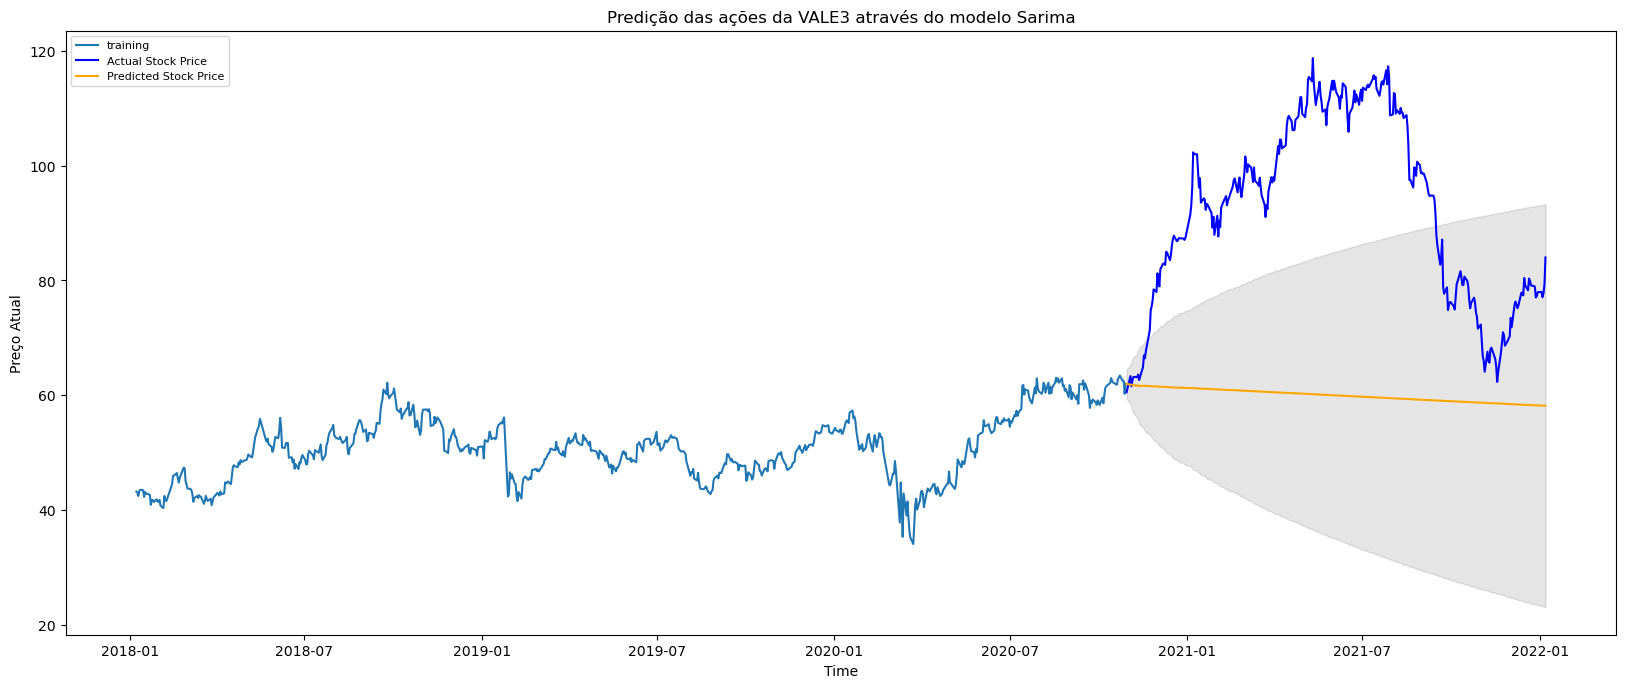

In [187]:
plot_predict_sarima(df_train_vale, df_test_vale, resultados_sarima_vale, 'VALE3')

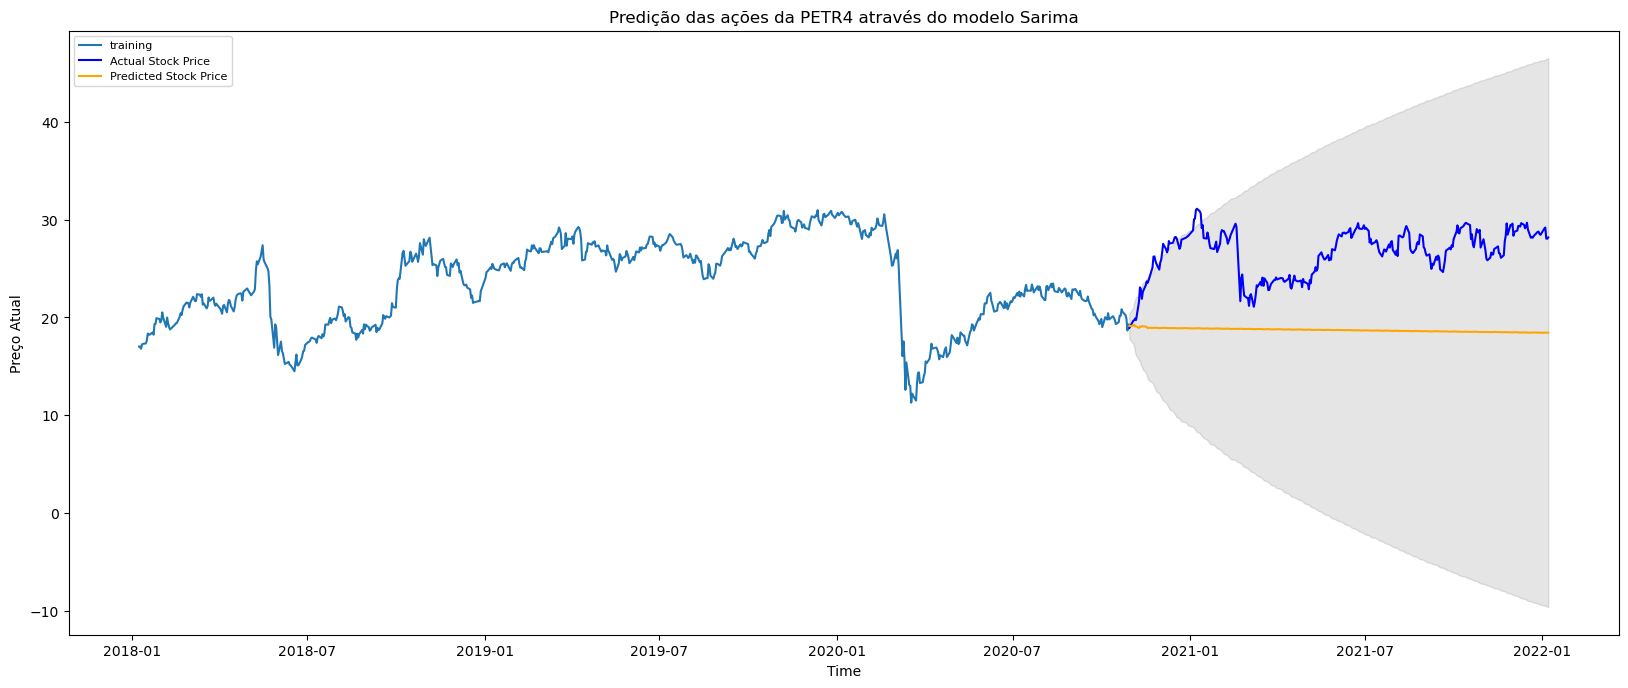

In [188]:
plot_predict_sarima(df_train_ptr4, df_test_ptr4, resultados_sarima_ptr4 , 'PETR4')

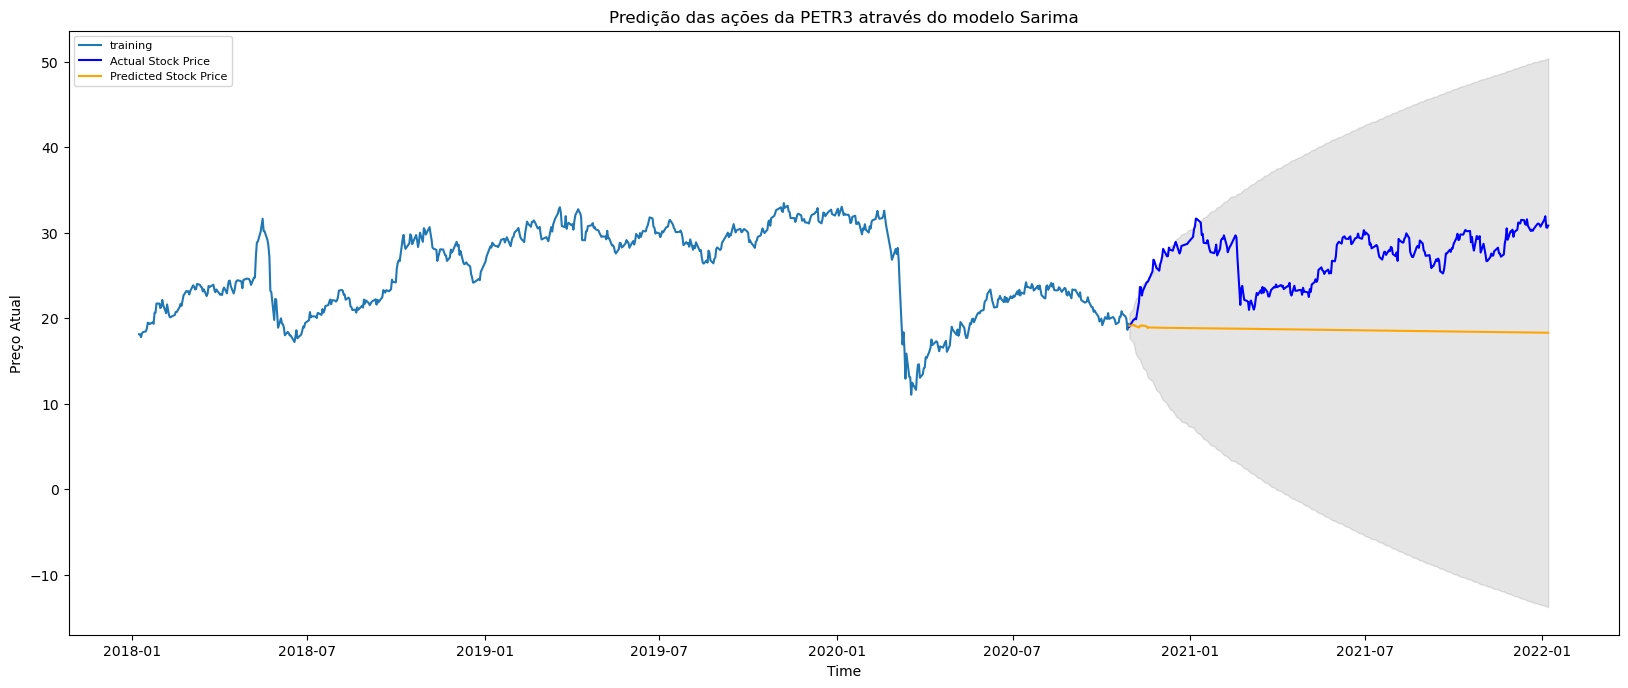

In [189]:
plot_predict_sarima(df_train_ptr3, df_test_ptr3, resultados_sarima_ptr3 , 'PETR3')

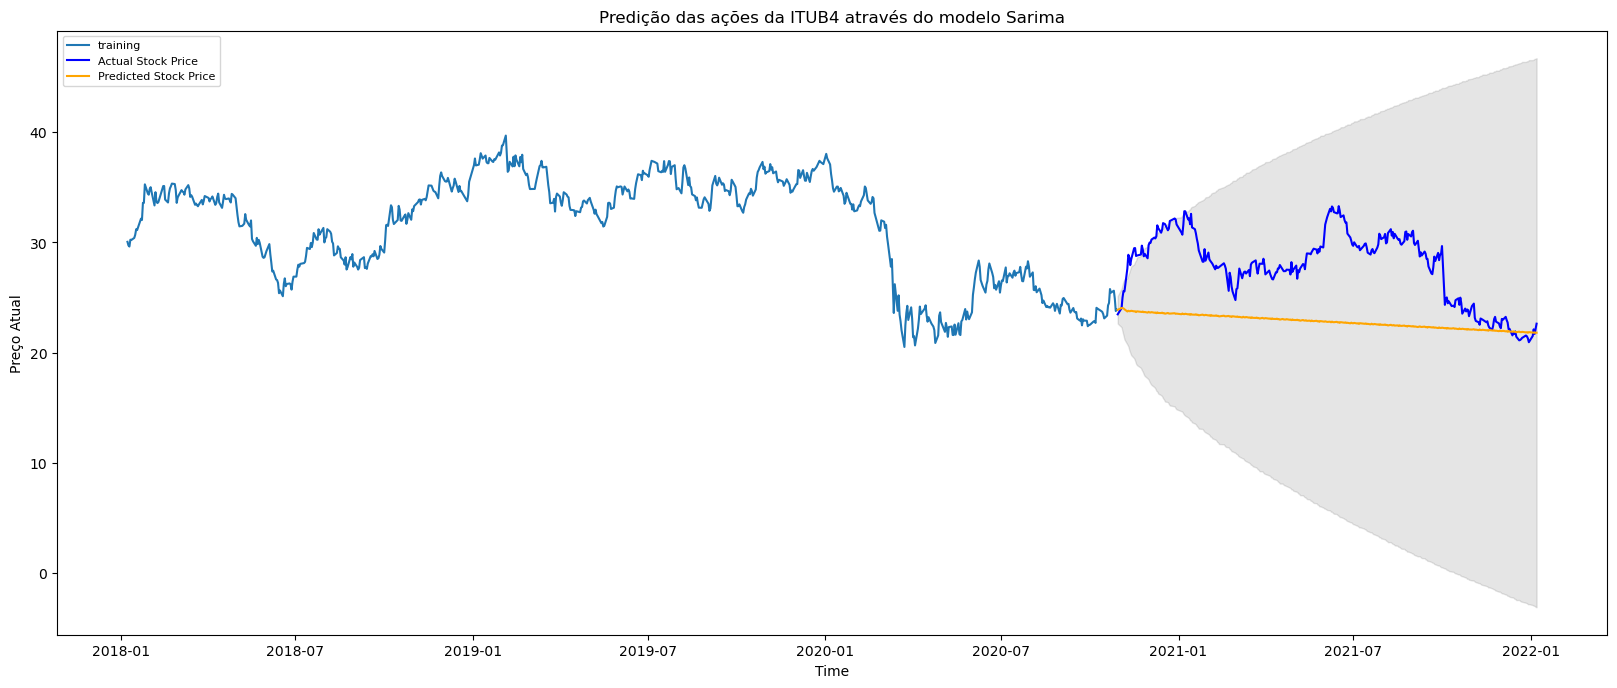

In [190]:
plot_predict_sarima(df_train_itub4, df_test_itub4, resultados_sarima_itub4, 'ITUB4')

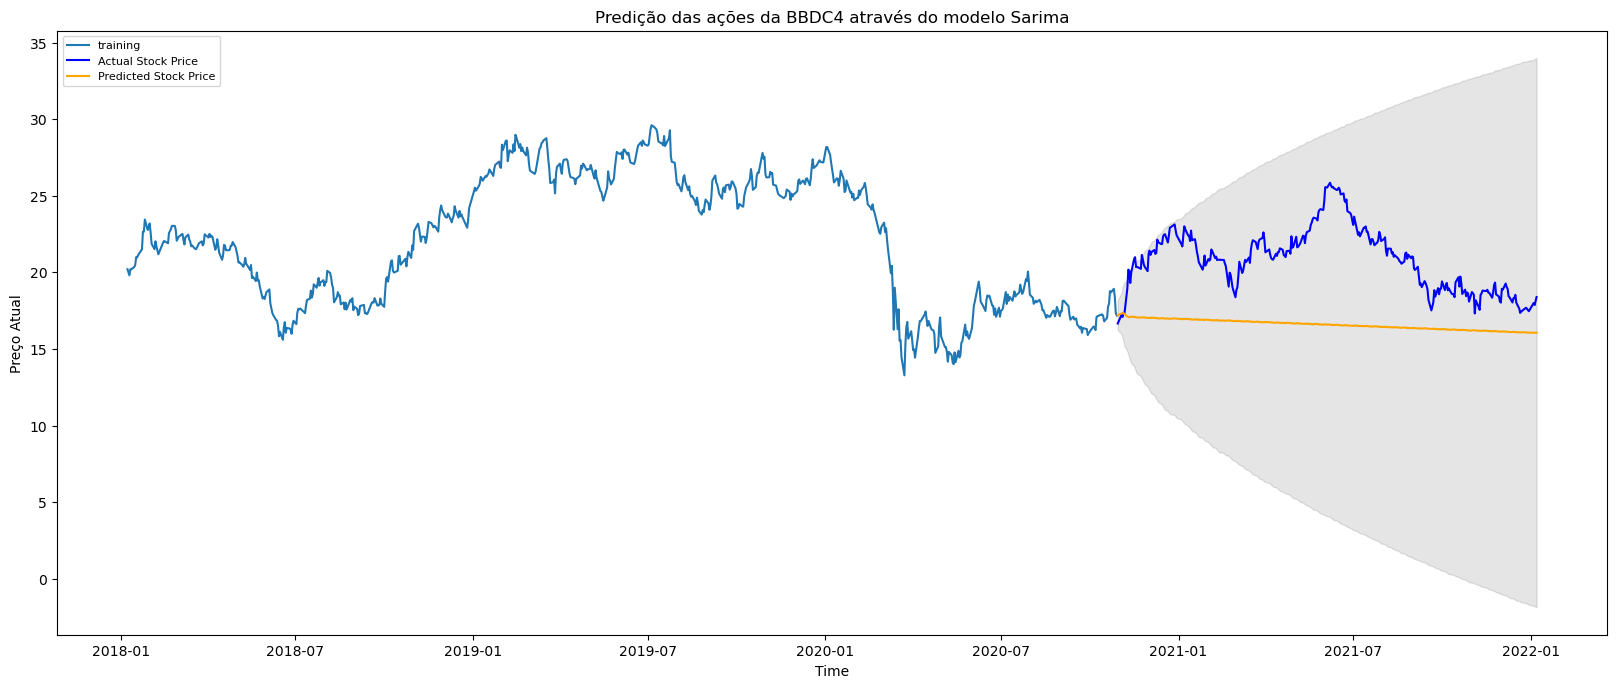

In [191]:
plot_predict_sarima(df_train_bbdc4, df_test_bbdc4, resultados_sarima_bbdc4 , 'BBDC4')

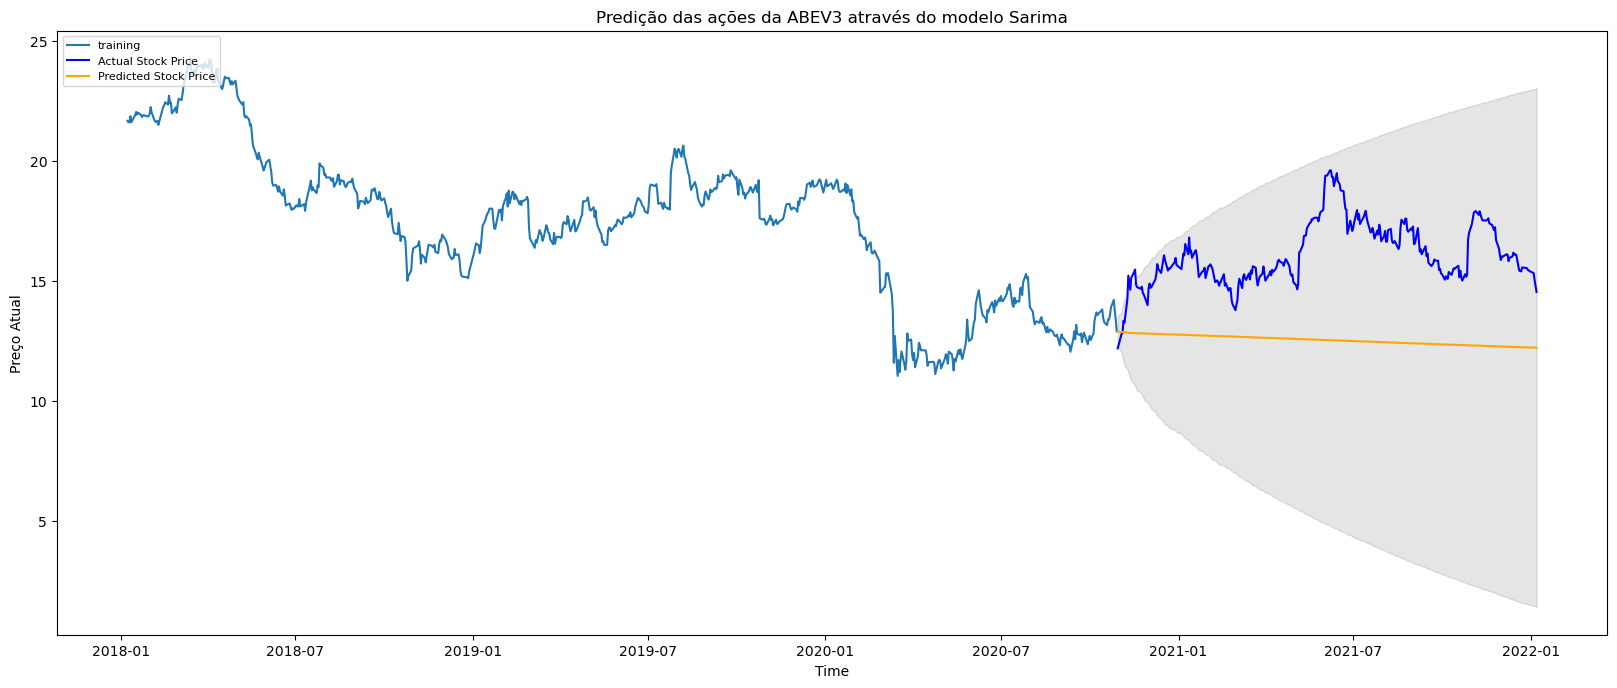

In [192]:
plot_predict_sarima(df_train_abev3, df_test_abev3, resultados_sarima_abev3 , 'ABEV3')

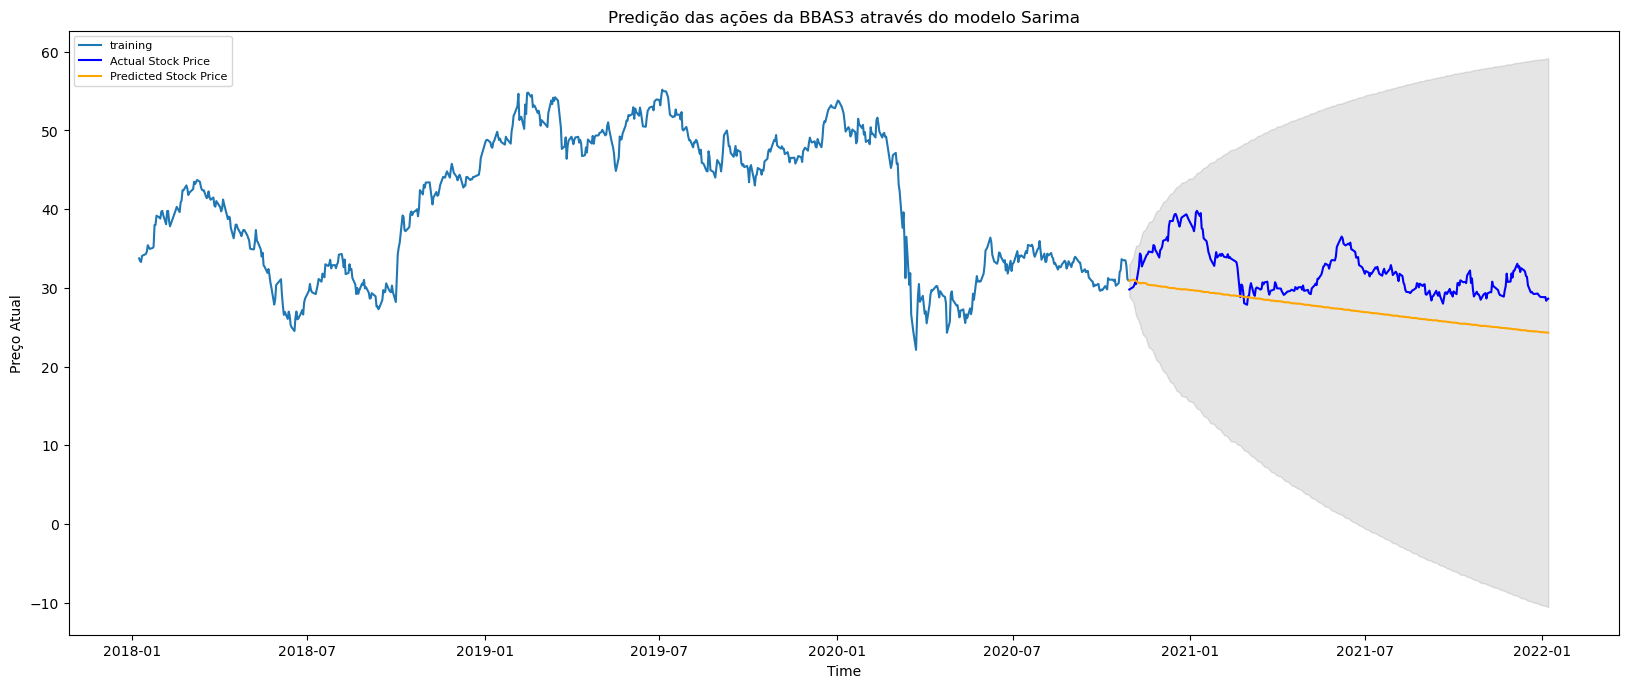

In [193]:
plot_predict_sarima(df_train_bbas3, df_test_bbas3, resultados_sarima_bbas3 , 'BBAS3')

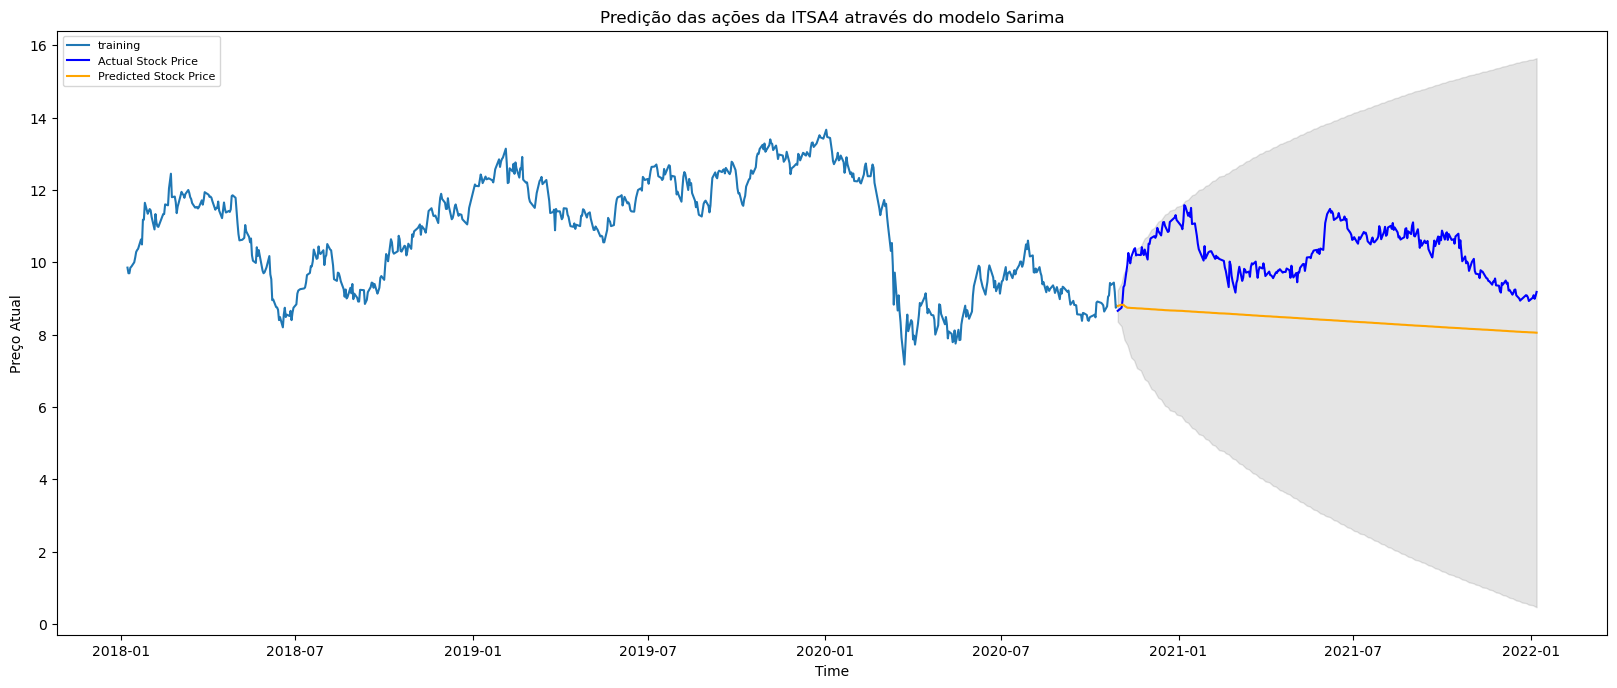

In [194]:
plot_predict_sarima(df_train_itsa4, df_test_itsa4, resultados_sarima_itsa4 , 'ITSA4')

## Plot de Predição do Arima

In [195]:
def plot_predict_arima(df_treino, df_teste, results_arima, indice): 
    fc, se, conf = results_arima.forecast(292,alpha=0.05)  # 95% intervalo de confiança
    fc = np.where(fc<0.0,0,fc)
    fc_series = pd.Series(fc, index=df_teste.index)
    
    #fc_series = np.where(fc_series<0.0,0, fc_series)

    lower_series = pd.Series(conf[:, 0], index=df_teste.index)
    upper_series = pd.Series(conf[:, 1], index=df_teste.index)
    
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(df_treino['close'], label='training')
    plt.plot(df_teste['close'], color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('Predição das ações da {} através do modelo Arima'.format(indice))
    plt.xlabel('Time')
    plt.ylabel('Preço Atual')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

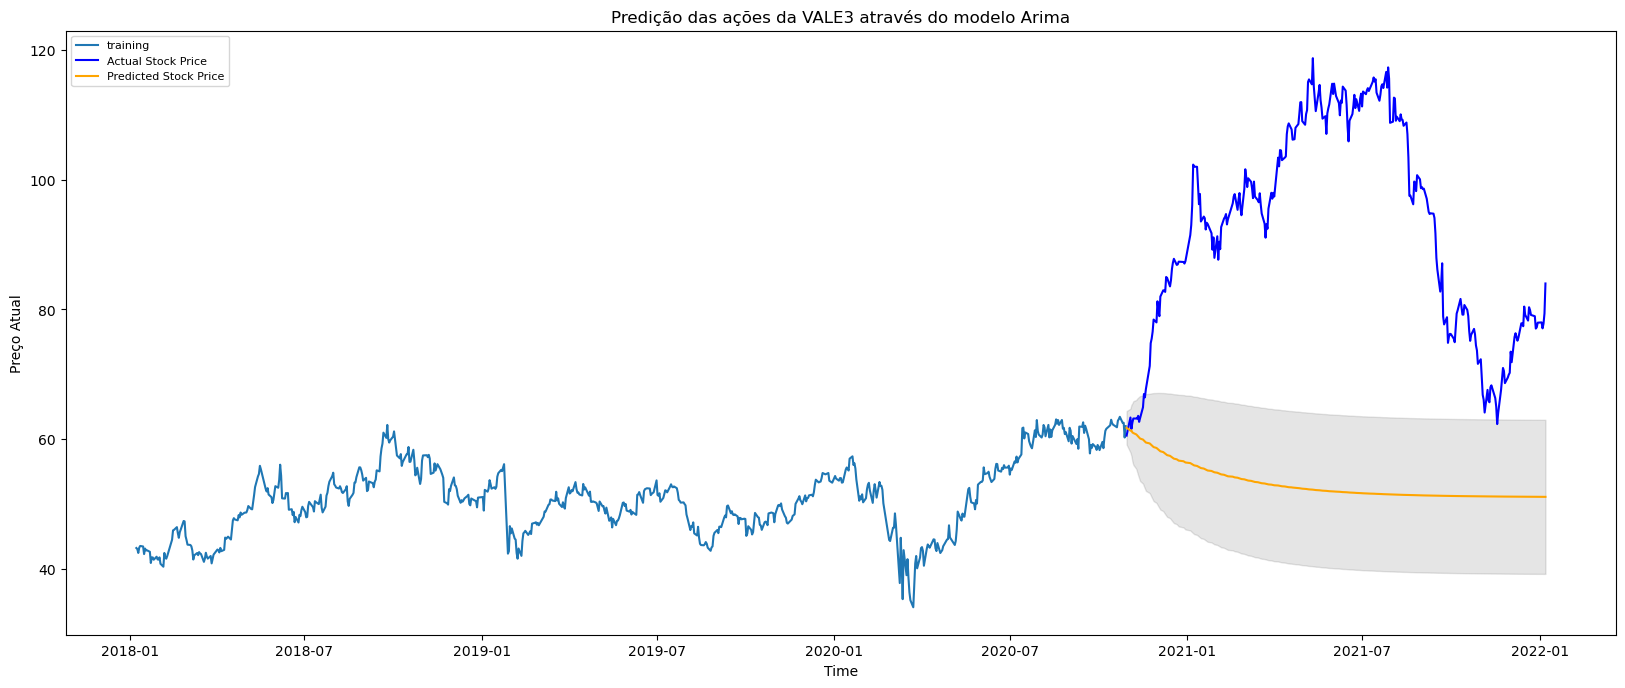

In [196]:
plot_predict_arima(df_train_vale, df_test_vale, resultados_arima_vale, 'VALE3')

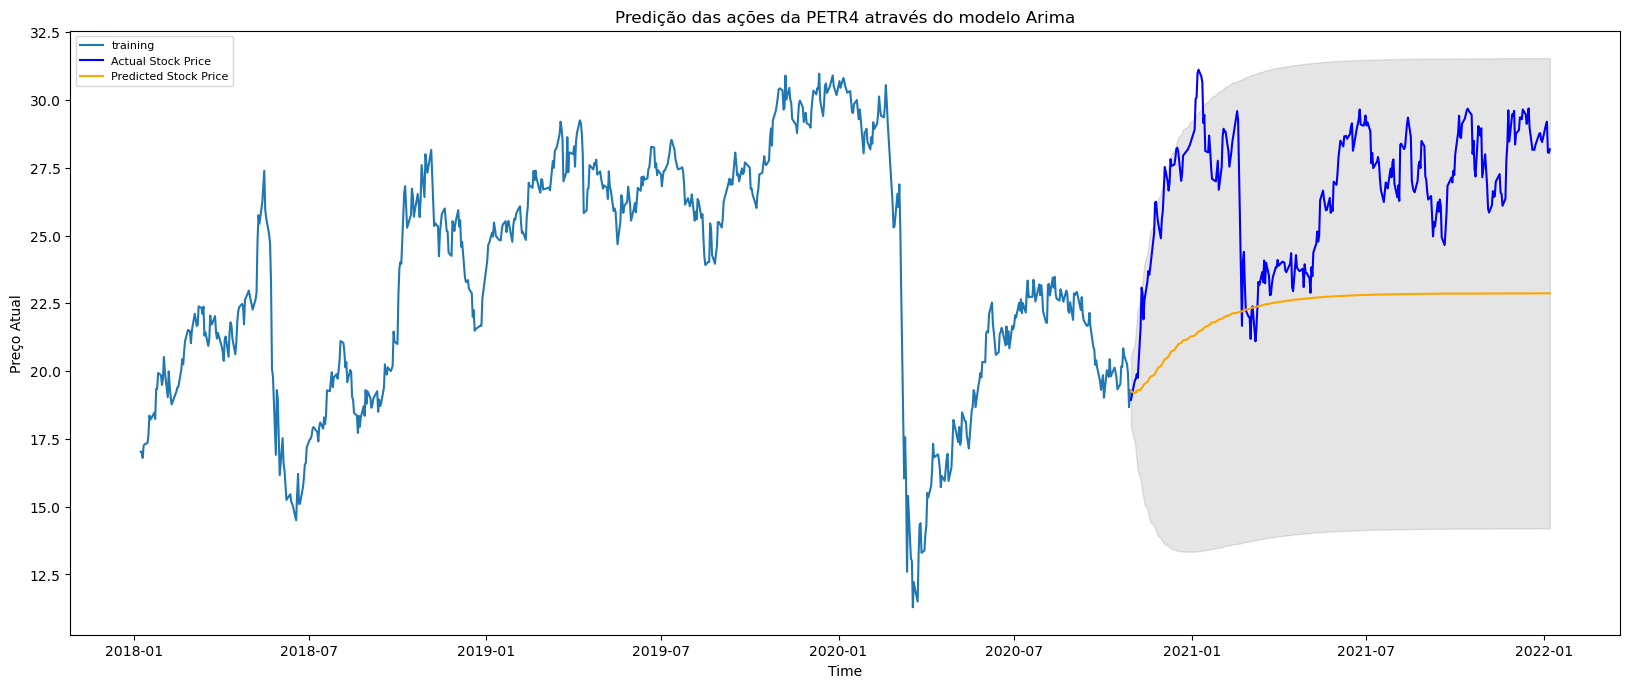

In [197]:
plot_predict_arima(df_train_ptr4, df_test_ptr4, resultados_arima_ptr4 , 'PETR4')

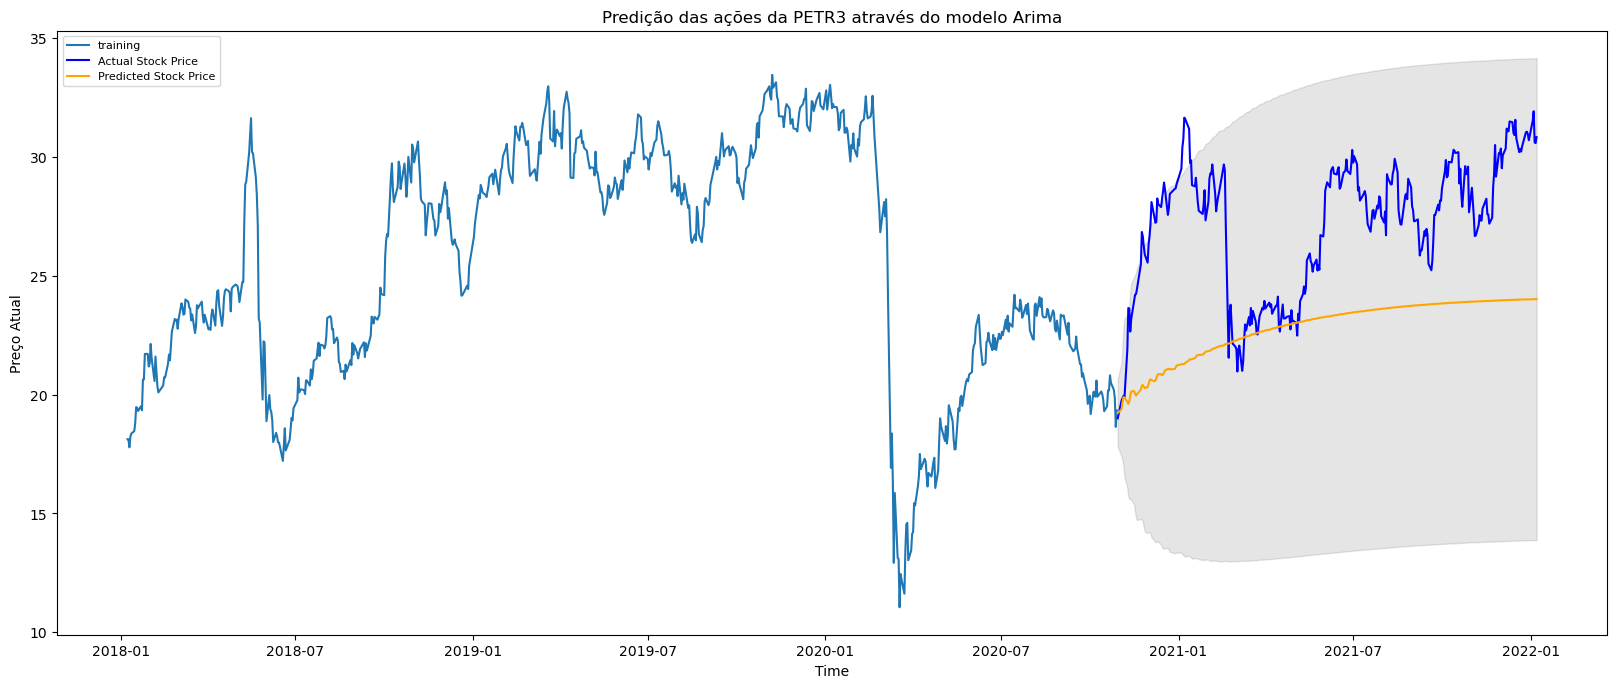

In [198]:
plot_predict_arima(df_train_ptr3, df_test_ptr3, resultados_arima_ptr3 , 'PETR3')

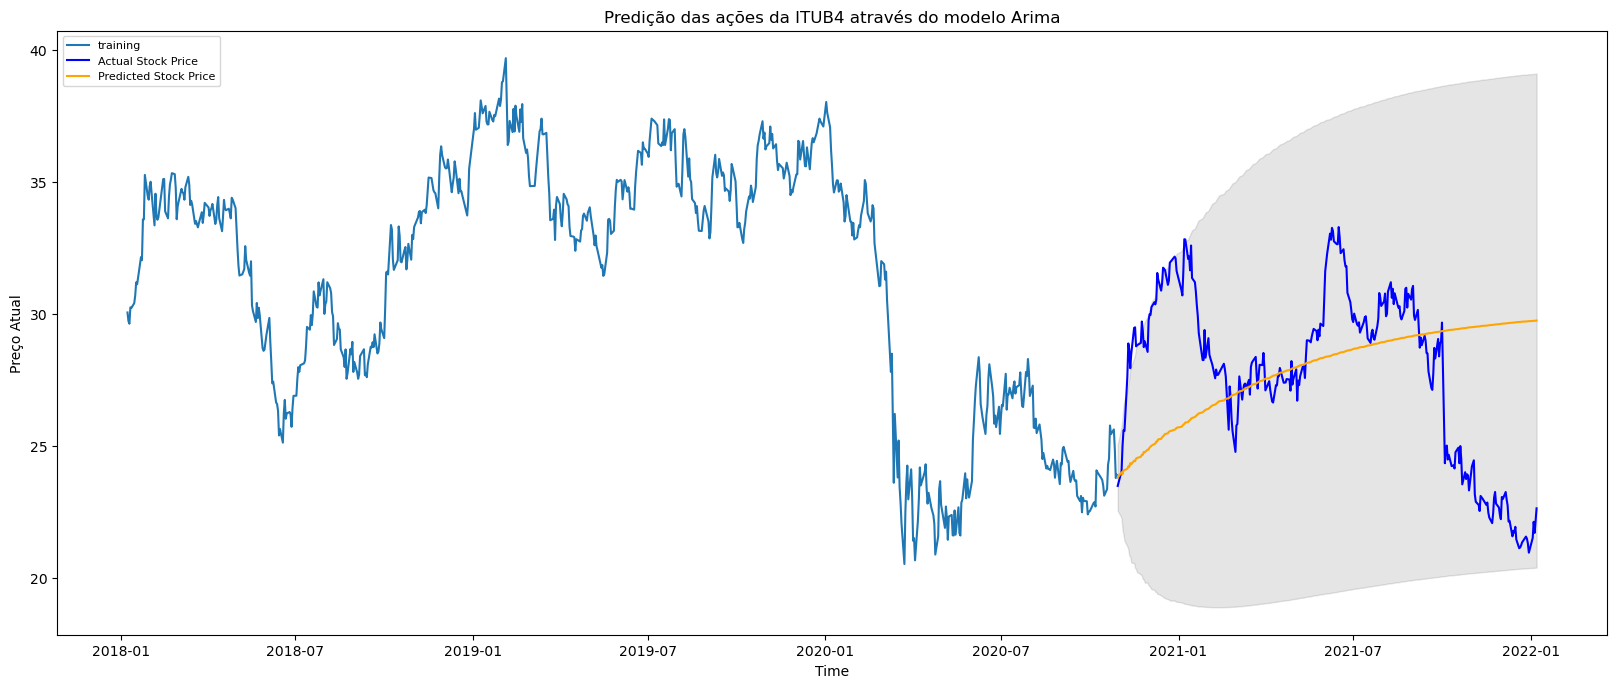

In [199]:
plot_predict_arima(df_train_itub4, df_test_itub4, resultados_arima_itub4, 'ITUB4')

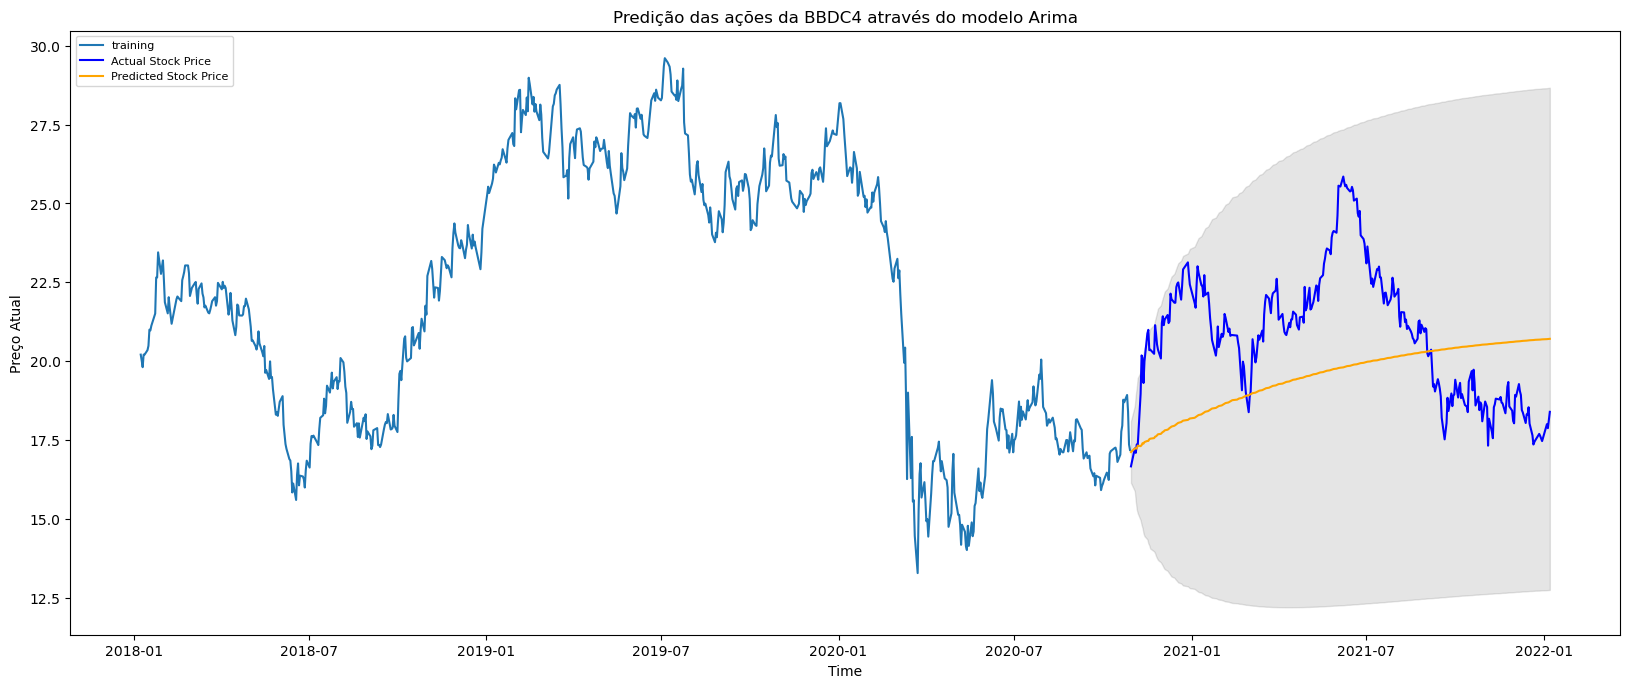

In [200]:
plot_predict_arima(df_train_bbdc4, df_test_bbdc4, resultados_arima_bbdc4 , 'BBDC4')

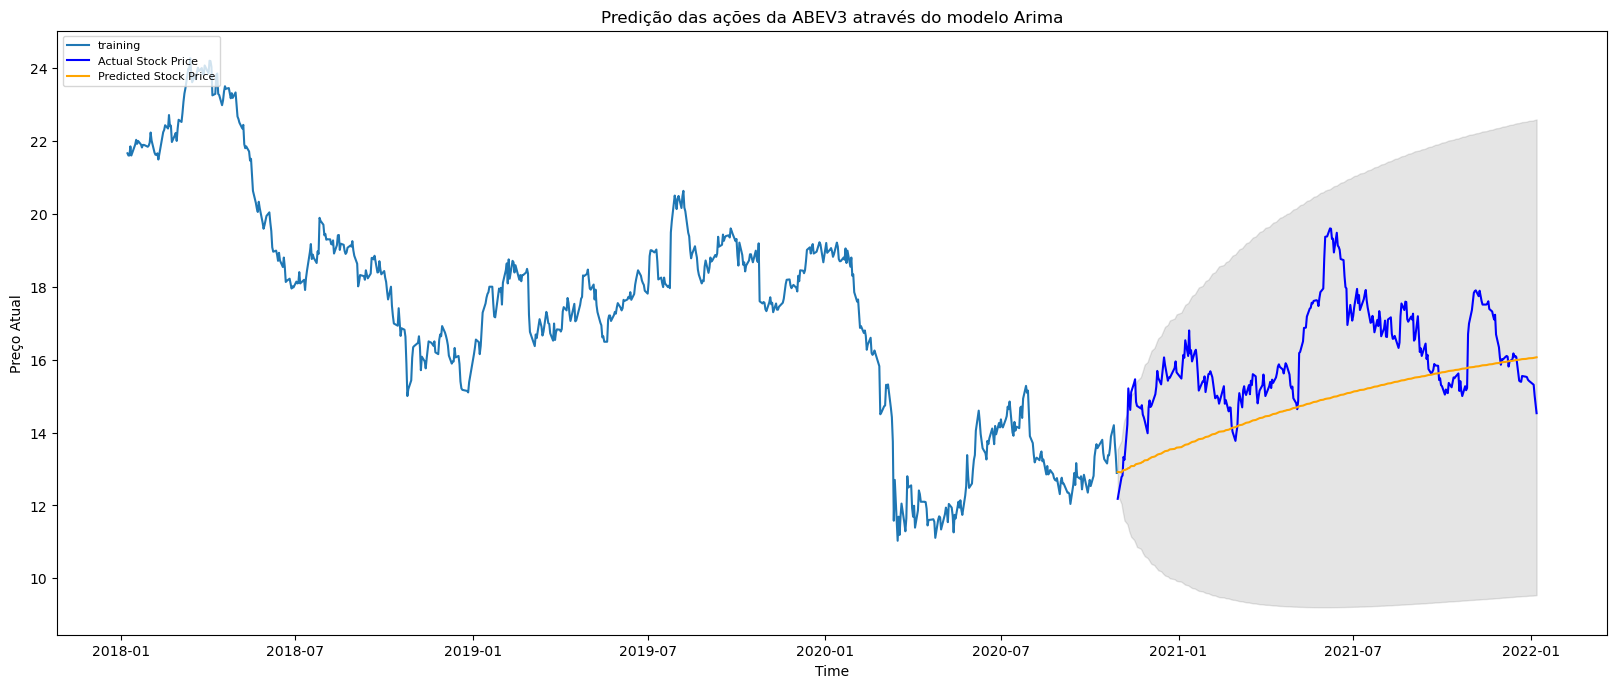

In [201]:
plot_predict_arima(df_train_abev3, df_test_abev3, resultados_arima_abev3 , 'ABEV3')

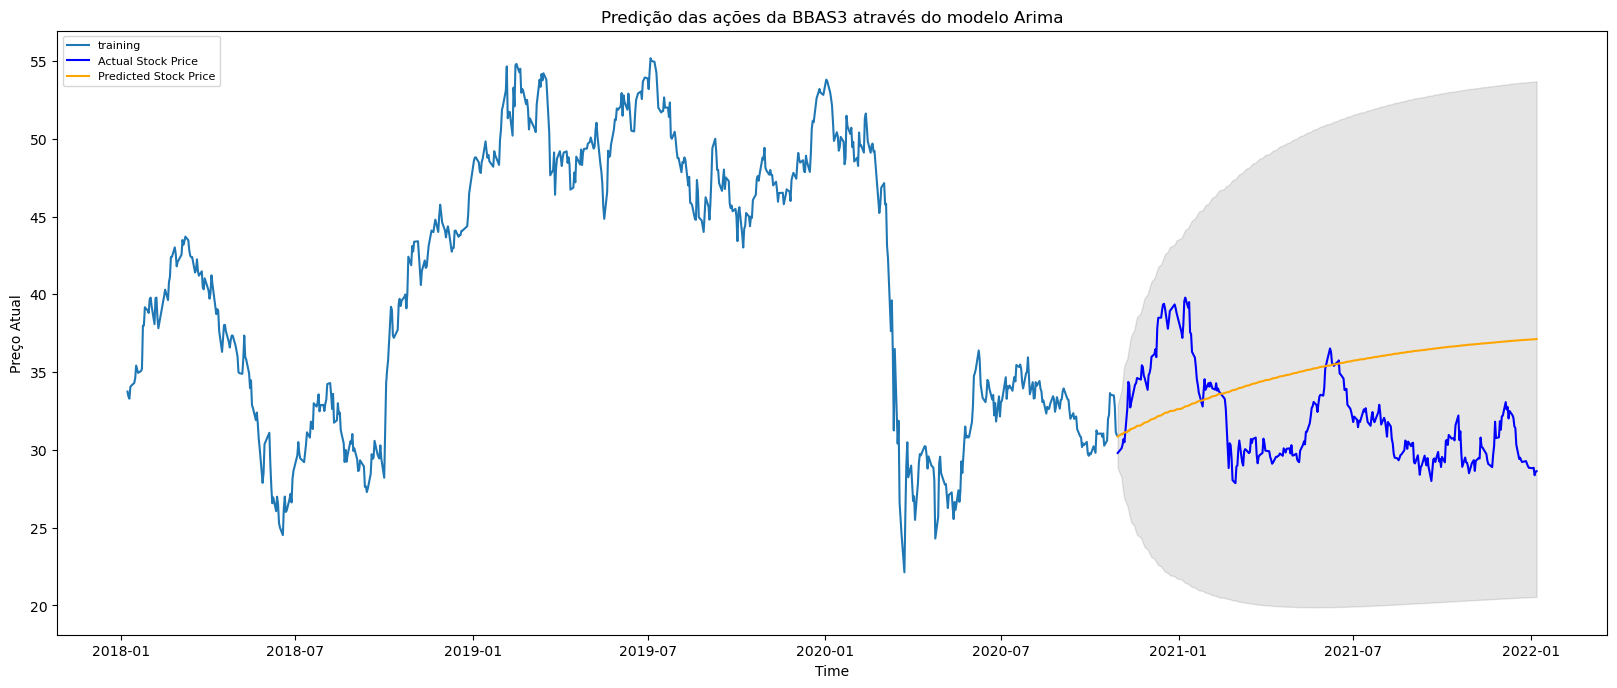

In [202]:
plot_predict_arima(df_train_bbas3, df_test_bbas3, resultados_arima_bbas3 , 'BBAS3')

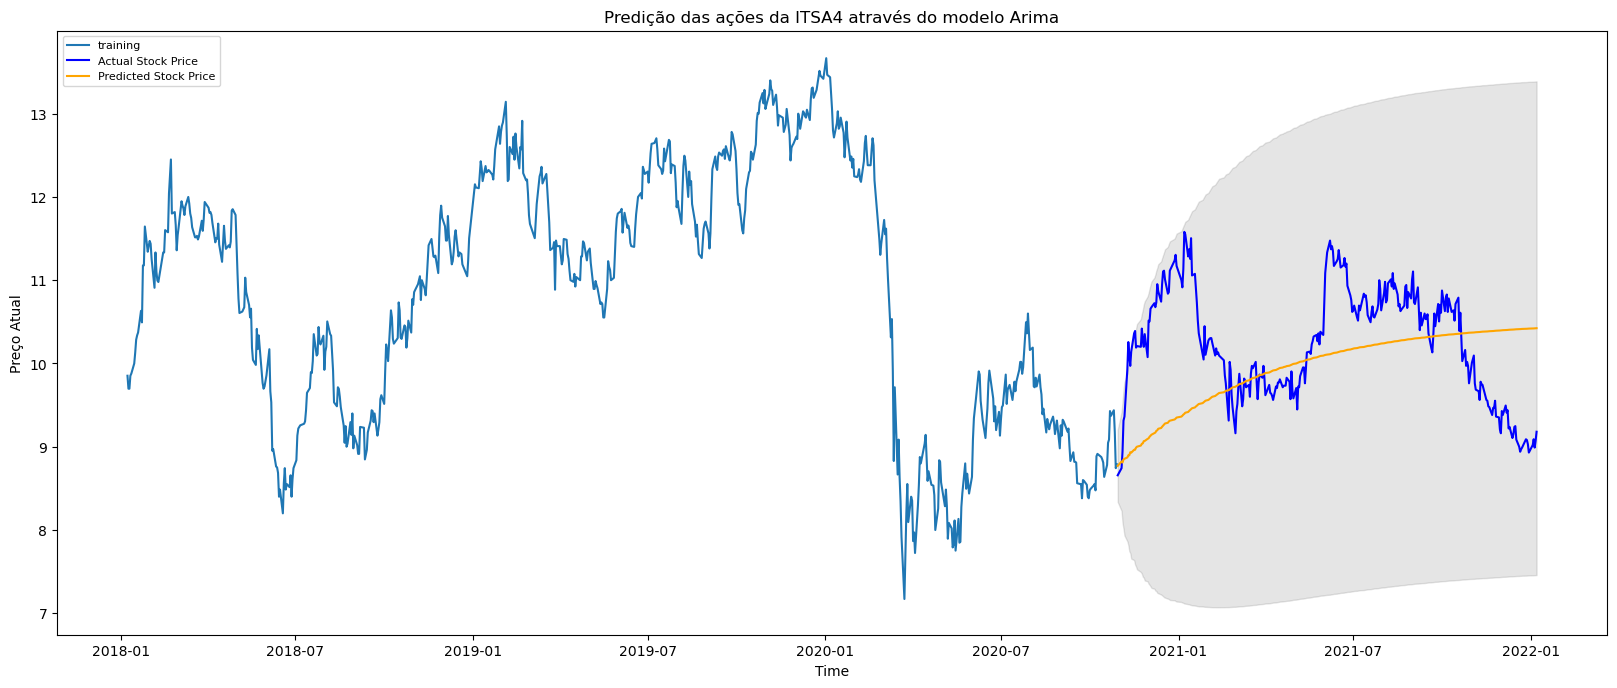

In [203]:
plot_predict_arima(df_train_itsa4, df_test_itsa4, resultados_arima_itsa4 , 'ITSA4')

## Resultados das métricas Arima / Sarima / Prophet

In [204]:
def results_metrics(mse_arima, rmse_arima, mape_arima, mse_sarima, rmse_sarima, mape_sarima, mse_prophet, rmse_prophet, 
                    mape_prophet):
    resultados = {"Resultados MSE Arima": mse_arima,
                   "Resultados MSE SARIMA:": mse_sarima, 
                   "Resultados MSE Prophet:": mse_prophet,
                   "Resultados RMSE Arima:": rmse_arima, 
                   "Resultados RMSE SARIMA:": rmse_sarima,
                   "Resultados RMSE Prophet:": rmse_prophet, 
                   "Resultados MAPE Arima:": mape_arima,
                   "Resultados MAPE SARIMA:": mape_sarima,                                    
                   "Resultados MAPE Prophet:": mape_prophet}
    return resultados

In [205]:
results_metrics_vale = results_metrics(mse_arima_vale, rmse_arima_vale, mape_arima_vale,
mse_vale_sarima, rmse_vale_sarima, mape_vale_sarima,
mse_vale_prophet, rmse_vale_prophet, mape_vale_prophet)

In [206]:
for k,v in results_metrics_vale.items():
    print (k,v)

Resultados MSE Arima 1817.6219542094486
Resultados MSE SARIMA: 1321.0716541671256
Resultados MSE Prophet: 637.8419709885225
Resultados RMSE Arima: 42.63357777866465
Resultados RMSE SARIMA: 36.34654941211237
Resultados RMSE Prophet: 25.255533472657483
Resultados MAPE Arima: 40.73434611230679
Resultados MAPE SARIMA: 33.16153173802207
Resultados MAPE Prophet: 0.23582996863790465


In [207]:
results_metrics_petr4 = results_metrics(mse_arima_petr4, rmse_arima_petr4, mape_arima_petr4,
mse_ptr4_sarima, rmse_ptr4_sarima, mape_ptr4_sarima,
mse_petr4_prophet, rmse_petr4_prophet, mape_petr4_prophet)

In [208]:
for k,v in results_metrics_petr4.items():
    print (k,v)

Resultados MSE Arima 24.71506565851851
Resultados MSE SARIMA: 69.31959911754437
Resultados MSE Prophet: 31.379725059637256
Resultados RMSE Arima: 4.971424912288076
Resultados RMSE SARIMA: 8.325839244036866
Resultados RMSE Prophet: 5.601760889188083
Resultados MAPE Arima: 16.249209359945173
Resultados MAPE SARIMA: 29.167547868983185
Resultados MAPE Prophet: 0.18746833262534415


In [209]:
results_metrics_petr3 = results_metrics(mse_arima_ptr3, rmse_arima_ptr3, mape_arima_ptr3,
mse_vale_sarima, rmse_vale_sarima, mape_vale_sarima,
 mse_petr3_prophet, rmse_petr3_prophet, mape_petr3_prophet)

In [210]:
for k,v in results_metrics_petr3.items():
    print (k,v)

Resultados MSE Arima 26.585832765861355
Resultados MSE SARIMA: 1321.0716541671256
Resultados MSE Prophet: 39.67004068769326
Resultados RMSE Arima: 5.156145145926494
Resultados RMSE SARIMA: 36.34654941211237
Resultados RMSE Prophet: 6.298415728394979
Resultados MAPE Arima: 15.890420743232486
Resultados MAPE SARIMA: 33.16153173802207
Resultados MAPE Prophet: 0.20348954982886489


In [211]:
results_metrics_itub4 = results_metrics(mse_arima_itub4, rmse_arima_itub4, mape_arima_itub4,
mse_itub4_sarima, rmse_itub4_sarima, mape_itub4_sarima,
 mse_itub4_prophet, rmse_itub4_prophet, mape_itub4_prophet)

In [212]:
for k,v in results_metrics_itub4.items():
    print (k,v)

Resultados MSE Arima 9.895151597835069
Resultados MSE SARIMA: 33.46964845285564
Resultados MSE Prophet: 55.89691289210998
Resultados RMSE Arima: 3.1456559884760233
Resultados RMSE SARIMA: 5.785295882913478
Resultados RMSE Prophet: 7.4764238036717785
Resultados MAPE Arima: 9.596744125016773
Resultados MAPE SARIMA: 17.27403377850462
Resultados MAPE Prophet: 0.224109404075925


In [213]:
results_metrics_bbdc4 = results_metrics(mse_arima_bbdc4, rmse_arima_bbdc4, mape_arima_bbdc4,
mse_bbdc4_sarima, rmse_bbdc4_sarima, mape_bbdc4_sarima,
 mse_bbdc4_prophet, rmse_bbdc4_prophet, mape_bbdc4_prophet)

In [214]:
for k,v in results_metrics_bbdc4.items():
    print (k,v)

Resultados MSE Arima 5.806103449175229
Resultados MSE SARIMA: 21.788115156914674
Resultados MSE Prophet: 14.925973777047611
Resultados RMSE Arima: 2.4095857422335545
Resultados RMSE SARIMA: 4.6677741115990905
Resultados RMSE Prophet: 3.8634147819057185
Resultados MAPE Arima: 9.122949602984297
Resultados MAPE SARIMA: 19.733320510926838
Resultados MAPE Prophet: 0.14774778881234565


In [215]:
results_metrics_abev3= results_metrics(mse_arima_abev3, rmse_arima_abev3, mape_arima_abev3,
mse_abev3_sarima, rmse_abev3_sarima, mape_abev3_sarima,
mse_abev3_prophet, rmse_abev3_prophet, mape_abev3_prophet)

In [216]:
for k,v in results_metrics_abev3.items():
    print (k,v)

Resultados MSE Arima 3.333345849336934
Resultados MSE SARIMA: 72.9341055216527
Resultados MSE Prophet: 14.925973777047611
Resultados RMSE Arima: 1.8257452859960872
Resultados RMSE SARIMA: 8.540146692045324
Resultados RMSE Prophet: 3.8634147819057185
Resultados MAPE Arima: 8.466150344913272
Resultados MAPE SARIMA: 39.36296342953266
Resultados MAPE Prophet: 0.14774778881234565


In [217]:
results_metrics_bbas3= results_metrics(mse_arima_bbas3, rmse_arima_bbas3, mape_arima_bbas3,
mse_bbas3_sarima, rmse_bbas3_sarima, mape_bbas3_sarima,
mse_bbas3_prophet, rmse_bbas3_prophet, mape_bbas3_prophet)

In [218]:
for k,v in results_metrics_bbas3.items():
    print (k,v)

Resultados MSE Arima 17.534291699891384
Resultados MSE SARIMA: 26.14454762790495
Resultados MSE Prophet: 87.21612593871967
Resultados RMSE Arima: 4.187396768863847
Resultados RMSE SARIMA: 5.11317392897063
Resultados RMSE Prophet: 9.338957433178484
Resultados MAPE Arima: 12.187123690975916
Resultados MAPE SARIMA: 13.998785581052406
Resultados MAPE Prophet: 0.26534265499517934


In [219]:
results_metrics_itsa4= results_metrics(mse_arima_itsa4, rmse_arima_itsa4, mape_arima_itsa4,
mse_itsa4_sarima, rmse_itsa4_sarima, mape_itsa4_sarima,
mse_itsa4_prophet, rmse_itsa4_prophet, mape_itsa4_prophet)

In [220]:
for k,v in results_metrics_itsa4.items():
    print (k,v)

Resultados MSE Arima 0.5113390919427496
Resultados MSE SARIMA: 3.791202602675525
Resultados MSE Prophet: 1.2290241081526652
Resultados RMSE Arima: 0.7150797801243926
Resultados RMSE SARIMA: 1.9471010766458747
Resultados RMSE Prophet: 1.108613597315433
Resultados MAPE Arima: 5.802997641421249
Resultados MAPE SARIMA: 17.644645232957515
Resultados MAPE Prophet: 0.09379713317480594


In [221]:
def plot_metricas (resultados_metrica, indice):
    plt.rc('figure', figsize=(14, 6))
    
    keys = list(resultados_metrica.keys())
    vals = [float(resultados_metrica[k]) for k in keys]
    grafico = sns.barplot(x=keys, y=vals)
    grafico.set_xticklabels(grafico.get_xticklabels(),rotation=45)
    grafico.bar_label(grafico.containers[0])
    grafico.set(title=f' Gráfico de métricas do índice {indice}');
    plt.show

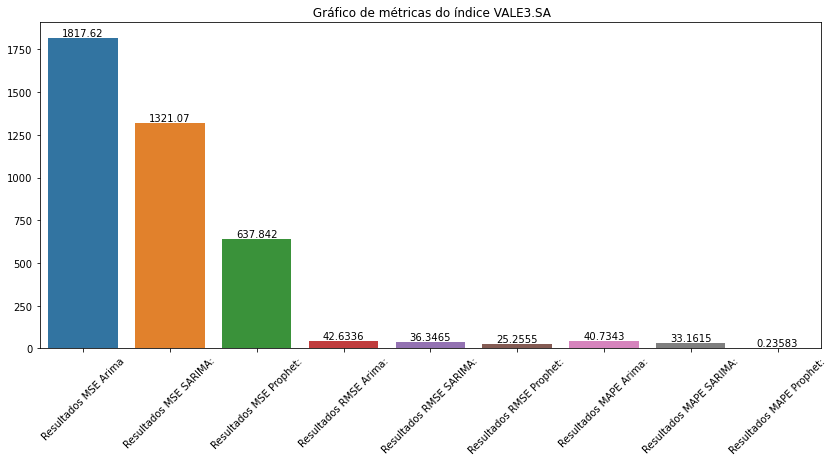

In [222]:
indice= "VALE3.SA"
plot_metricas(results_metrics_vale,indice)

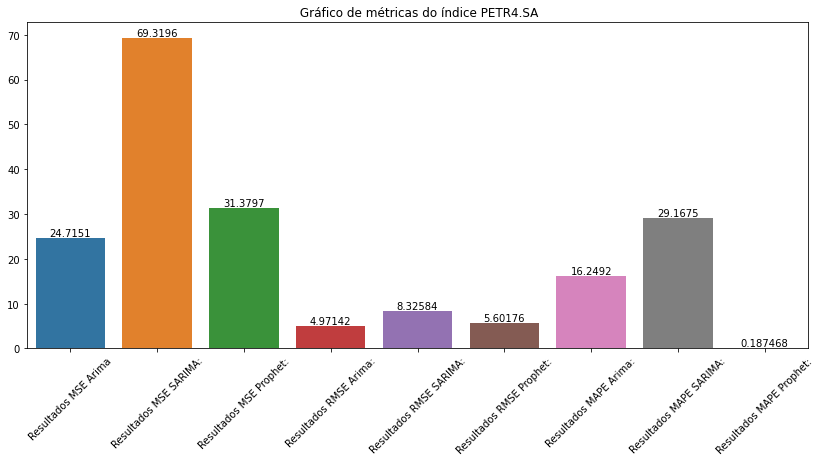

In [223]:
indice= "PETR4.SA"
plot_metricas(results_metrics_petr4,indice)

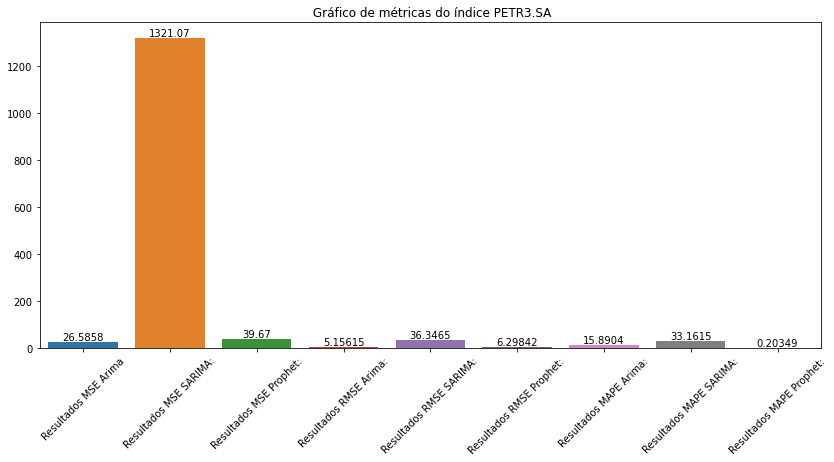

In [224]:
indice= "PETR3.SA"
plot_metricas(results_metrics_petr3,indice)

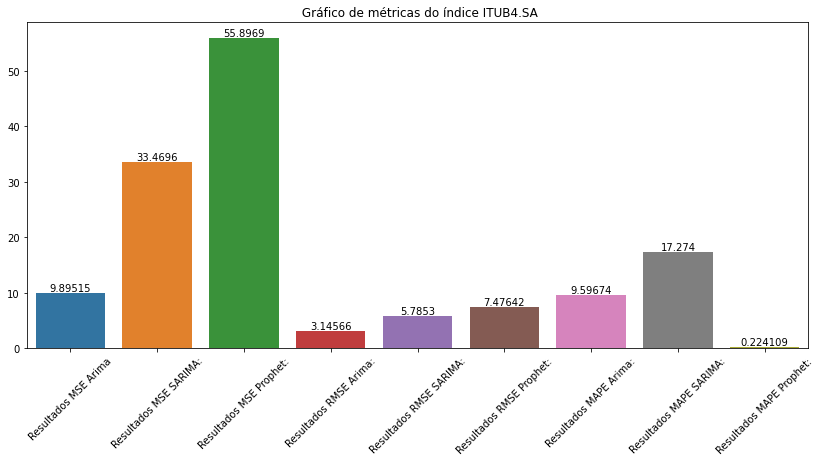

In [225]:
indice= "ITUB4.SA"
plot_metricas(results_metrics_itub4,indice)

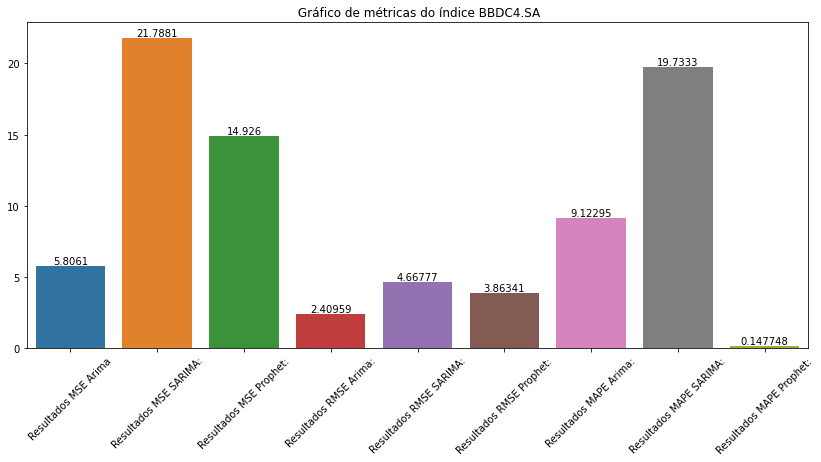

In [226]:
indice= "BBDC4.SA"
plot_metricas(results_metrics_bbdc4,indice)

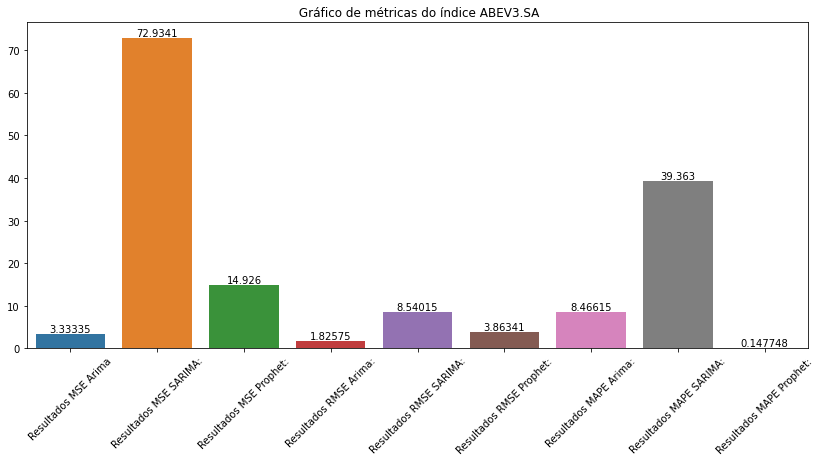

In [227]:
indice= "ABEV3.SA"
plot_metricas(results_metrics_abev3,indice)

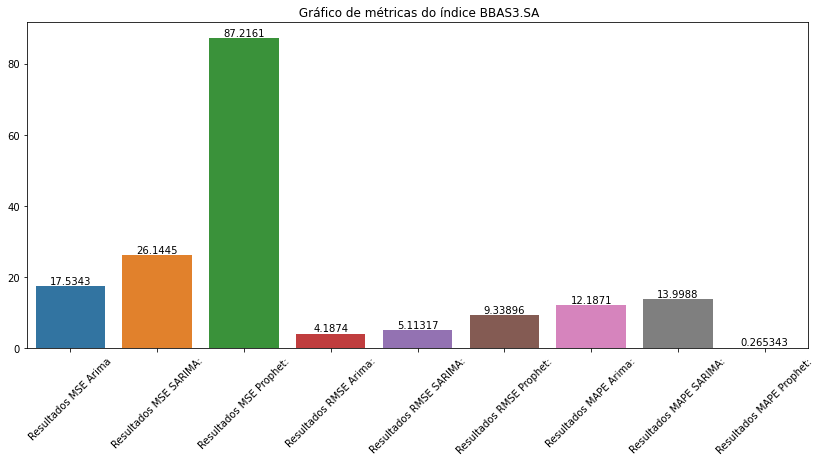

In [228]:
indice= "BBAS3.SA"
plot_metricas(results_metrics_bbas3,indice)

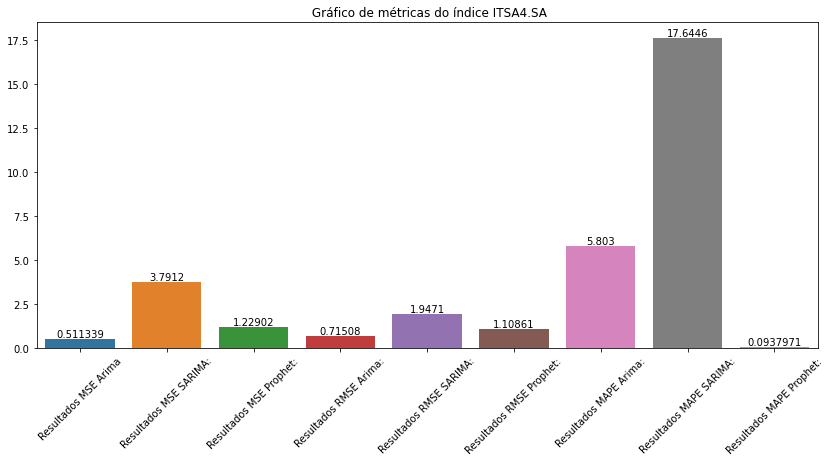

In [229]:
indice= "ITSA4.SA"
plot_metricas(results_metrics_itsa4,indice)